# Drone Detection System Using Computer Vision

---

## Research Question

**How can drone detection in images or video frames using computer vision techniques help security, surveillance, airspace monitoring, and wildlife protection?**

---

## Expected Data Source
- **Primary Dataset**: [Roboflow Drone Detection Dataset](https://universe.roboflow.com/ahmedmohsen/drone-detection-new-peksv)
- **Local Dataset Path**: [Drone Dataset](https://github.com/atewari-bot/drone-image-classification/blob/main/data/drone-dataset-sample.zip)

---

## Expected Techniques for Analysis

### 1. **Dataset Collection and Annotation**
- Image collection from various sources
- Proper labeling and annotation of drone objects
- Quality assurance and validation

### 2. **Data Preprocessing**
- Image resizing and normalization
- Data augmentation techniques
- Noise reduction and enhancement

### 3. **Detection Framework Selection**
- **YOLO (You Only Look Once)**: Real-time detection
- **Faster R-CNN**: High accuracy detection
- **Custom CNN**: Tailored architecture
- Trade-off analysis between efficiency and accuracy

### 4. **Model Configuration and Training**
- Neural network architecture design
- Hyperparameter optimization
- Training with appropriate loss functions

### 5. **Model Evaluation**
- Classification metrics (Precision, Recall, F1-score)
- Mean Average Precision (mAP)
- Confusion matrix analysis

### 6. **Deployment and Monitoring**
- Model deployment strategies
- Performance monitoring
- Retraining protocols

---

## Expected Results

The trained model should achieve:
- **High accuracy** in drone detection and localization
- **Strong performance metrics**: Precision, Recall, mAP
- **Real-time processing capability** for video frames
- **Robust detection** across various environmental conditions

---

## Importance of This Research

### Security and Safety Benefits
- **Civilian Protection**: Detecting potentially armed drones
- **Critical Infrastructure**: Safeguarding airports, government facilities
- **Privacy Protection**: Identifying unauthorized surveillance drones
- **Airspace Management**: Ensuring safe aviation operations

### Wildlife Conservation
- **Precision Detection**: Avoiding false positives that could harm wildlife
- **Conservation Monitoring**: Protecting endangered species from unauthorized surveillance
- **Habitat Preservation**: Minimizing disruption to natural environments

In [245]:
%%capture
%pip install pandas
%pip install matplotlib
%pip install seaborn
%pip install tensorflow
%pip install sklearn
%pip install opencv-python
%pip install zipfile
%pip install scikit-image

In [246]:
import zipfile
import io
import os
import sys
import time
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from matplotlib.patches import Rectangle
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, make_scorer, precision_score, recall_score, f1_score, precision_recall_curve, average_precision_score

from collections import Counter, defaultdict
from scipy import stats as scipy_stats
from skimage import filters, segmentation, measure, feature
from skimage.feature import local_binary_pattern, hog
from skimage.color import rgb2gray
from skimage.util import img_as_ubyte

from tensorflow import keras
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, InputLayer, Reshape, BatchNormalization, Dropout, Input
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.optimizers import Adam
from keras.losses import SparseCategoricalCrossentropy
from keras.metrics import SparseCategoricalAccuracy
from keras.losses import MeanSquaredError
from keras.metrics import MeanAbsoluteError

In [247]:
# Configuration and constants
zip_path = "data/drone-dataset-sample.zip"
train_base_folder = "drone-dataset-sample/train"
test_base_folder = "drone-dataset-sample/test"
valid_base_folder = "drone-dataset-sample/valid"
img_size = (224, 224)
MAX_BOXES = 10
class_names = ['AIRPLANE', 'DRONE', 'HELICOPTER', 'BIRD']
NUM_CLASSES = len(class_names)
EPOCHS = 50
BATCH_SIZE = 32
SMALL_BATCH_SIZE = 8
run_grid_search = True
score_df = pd.DataFrame(index = [
        'RandomForestClassifier',
        'Optimized RandomForest',
        'CNN',
        'CNN Denoised'
    ], columns = [
        'Model Train Time',
        'MSE Train', 'MSE Test',
        'Acc Train', 'Acc Test',
        'MAE Train', 'MAE Test',
        'Precision Train', 'Precision Test',
        'Recall Train', 'Recall Test',
        'F1 Train', 'F1 Test'])

model_training_time = []

mse_train_models = []
mae_train_models = []
acc_train_models = []
precision_train_models = []
recall_train_models = []
f1_train_models = []

mse_val_models = []
mae_val_models = []
acc_val_models = []
precision_val_models = []
recall_val_models = []
f1_val_models = []

mse_test_models = []
mae_test_models = []
acc_test_models = []
precision_test_models = []
recall_test_models = []
f1_test_models = []

In [248]:
# Global declarations
# Initialize loss and metric functions
mse_loss = MeanSquaredError()
mae_loss = MeanAbsoluteError()
imbalance_ratio = 1.0
eda_results = {}

# Data Preparation

# Load data (Images and Labels)

In [249]:
# Parsing Yolo Labels
def parse_yolo_label(txt):
    '''
    Parse YOLO label format to numpy array
    '''
    boxes = []
    for line in txt.strip().split("\n"):
        if line.strip():  # Skip empty lines
            parts = line.split()
            if len(parts) >= 5:
                cls, x, y, w, h = map(float, parts[:5])
                boxes.append([cls, x, y, w, h])
    return np.array(boxes, dtype=np.float32)

# Loading images and label files from .zip dataset
def load_image_and_label(zip_ref, img_path):
    '''
    Load image and label from zip file
    '''
    if img_path.endswith(".jpg") or img_path.endswith(".png"):
        label_path = img_path.replace("/images/", "/labels/").replace(".jpg", ".txt").replace(".png", ".txt")

        # Load and preprocess image
        try:
            with zip_ref.open(img_path) as img_file:
                image = Image.open(img_file).convert("RGB").resize(img_size)
                image_np = np.array(image) / 255.0
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            return None, None

        # Load and parse label
        try:
            with zip_ref.open(label_path) as label_file:
                txt = label_file.read().decode("utf-8")
                if len(txt.strip()) == 0:
                    # For empty label files, infer class from filename/path
                    if "AIRPLANE" in img_path.upper():
                        labels = np.array([[0, 0.5, 0.5, 0.3, 0.3]], dtype=np.float32)
                    elif "BIRD" in img_path.upper():
                        labels = np.array([[3, 0.5, 0.5, 0.2, 0.2]], dtype=np.float32)
                    elif "DRONE" in img_path.upper():
                        labels = np.array([[1, 0.5, 0.5, 0.25, 0.25]], dtype=np.float32)
                    elif "HELICOPTER" in img_path.upper():
                        labels = np.array([[2, 0.5, 0.5, 0.4, 0.3]], dtype=np.float32)
                    else:
                        labels = np.zeros((0, 5), dtype=np.float32)
                else:
                    labels = parse_yolo_label(txt)
        except KeyError:
            # If label file doesn't exist, try to infer from image path
            if "AIRPLANE" in img_path.upper():
                labels = np.array([[0, 0.5, 0.5, 0.3, 0.3]], dtype=np.float32)
            elif "BIRD" in img_path.upper():
                labels = np.array([[3, 0.5, 0.5, 0.2, 0.2]], dtype=np.float32)
            elif "DRONE" in img_path.upper():
                labels = np.array([[1, 0.5, 0.5, 0.25, 0.25]], dtype=np.float32)
            elif "HELICOPTER" in img_path.upper():
                labels = np.array([[2, 0.5, 0.5, 0.4, 0.3]], dtype=np.float32)
            else:
                labels = np.zeros((0, 5), dtype=np.float32)

        return image_np.astype(np.float32), labels

# Load .zip dataset from underlying filesystem
def load_dataset(zip_path, base_folder):
    '''
    Load dataset from zip file
    '''
    X = []
    Y = []

    if not os.path.exists(zip_path):
        print(f"Error: Zip file {zip_path} not found!")
        return None, None

    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        # Get all image paths
        image_paths = [f for f in zip_ref.namelist()
                      if f.startswith(f"{base_folder}/images/") and f.endswith((".jpg", ".png"))]

        print(f"Found {len(image_paths)} images in {base_folder}")

        for i, path in enumerate(image_paths):
            try:
                img, label = load_image_and_label(zip_ref, path)
                if img is not None and label is not None:
                    # Pad labels to fixed length
                    padded = np.zeros((MAX_BOXES, 5), dtype=np.float32)
                    if len(label) > 0:
                        padded[:min(len(label), MAX_BOXES)] = label[:MAX_BOXES]
                    X.append(img)
                    Y.append(padded)

                    if (i + 1) % 50 == 0:
                        print(f"Processed {i + 1}/{len(image_paths)} images")

            except Exception as e:
                print(f"Error processing {path}: {e}")
                continue

    if len(X) == 0:
        print(f"No valid images found in {base_folder}")
        return None, None

    X = np.array(X).astype(np.float32)
    Y = np.array(Y).astype(np.float32)

    # Validate loaded files
    if np.isnan(X).any():
        print("Warning: NaNs found in X, replacing with zeros")
        X = np.nan_to_num(X)
    if np.isnan(Y).any():
        print("Warning: NaNs found in Y, replacing with zeros")
        Y = np.nan_to_num(Y)

    print(f"Loaded {len(X)} images with shape {X.shape}")

    return X, Y

In [250]:
# Load Training Dataset
print("Loading training data...")
X_train, Y_train = load_dataset(zip_path, train_base_folder)

if X_train is None:
  print("Failed to load training data!")

Loading training data...
Found 2000 images in drone-dataset-sample/train
Processed 50/2000 images
Processed 100/2000 images
Processed 150/2000 images
Processed 200/2000 images
Processed 250/2000 images
Processed 300/2000 images
Processed 350/2000 images
Processed 400/2000 images
Processed 450/2000 images
Processed 500/2000 images
Processed 550/2000 images
Processed 600/2000 images
Processed 650/2000 images
Processed 700/2000 images
Processed 750/2000 images
Processed 800/2000 images
Processed 850/2000 images
Processed 900/2000 images
Processed 950/2000 images
Processed 1000/2000 images
Processed 1050/2000 images
Processed 1100/2000 images
Processed 1150/2000 images
Processed 1200/2000 images
Processed 1250/2000 images
Processed 1300/2000 images
Processed 1350/2000 images
Processed 1400/2000 images
Processed 1450/2000 images
Processed 1500/2000 images
Processed 1550/2000 images
Processed 1600/2000 images
Processed 1650/2000 images
Processed 1700/2000 images
Processed 1750/2000 images
Pr

In [251]:
print("Loading validation data...")
X_val, Y_val = load_dataset(zip_path, valid_base_folder)

Loading validation data...
Found 400 images in drone-dataset-sample/valid
Processed 50/400 images
Processed 100/400 images
Processed 150/400 images
Processed 200/400 images
Processed 250/400 images
Processed 300/400 images
Processed 350/400 images
Processed 400/400 images
Loaded 400 images with shape (400, 224, 224, 3)


In [252]:
print("Loading test data...")
X_test, Y_test = load_dataset(zip_path, test_base_folder)

Loading test data...
Found 400 images in drone-dataset-sample/test
Processed 50/400 images
Processed 100/400 images
Processed 150/400 images
Processed 200/400 images
Processed 250/400 images
Processed 300/400 images
Processed 350/400 images
Processed 400/400 images
Loaded 400 images with shape (400, 224, 224, 3)


## Convert object detection data into image classification data

Convert an object detection dataset (images + bounding boxes + class IDs) into a simple classification dataset, where each image gets a single label.

In [253]:
# Converts object detection data into image classification data by extracting a single class label per image
# (specifically, the class of the first detected object in each image).
def create_classification_data(X, Y):
    '''
    Convert detection data to classification data by taking the first (most confident) class
    '''
    classification_labels = []
    valid_images = []

    for i in range(len(X)):
        # Find the first non-zero box
        valid_boxes = Y[i][~np.all(Y[i] == 0, axis=1)]

        if len(valid_boxes) > 0:
            # Use the first valid box's class
            class_id = int(valid_boxes[0, 0])
            if 0 <= class_id < NUM_CLASSES:
                classification_labels.append(class_id)
                valid_images.append(X[i])

    return np.array(valid_images), np.array(classification_labels)

Create classification data for Train, Test and Validation dataset

In [254]:
print("\nPreparing classification data...")
X_train_cls, y_train_cls = create_classification_data(X_train, Y_train)
y_labels = y_train_cls

if len(X_train_cls) == 0:
    print("No valid classification data found!")

X_val_cls, y_val_cls = None, None
X_test_cls, y_test_cls = None, None

if X_val is not None:
    X_val_cls, y_val_cls = create_classification_data(X_val, Y_val)
if X_test is not None:
    X_test_cls, y_test_cls = create_classification_data(X_test, Y_test)

print(f"Classification data - Train: {len(X_train_cls)}, Val: {len(X_val_cls) if X_val_cls is not None else 0}, Test: {len(X_test_cls) if X_test_cls is not None else 0}")



Preparing classification data...
Classification data - Train: 2000, Val: 400, Test: 400


# Exploratory Data Analysis

## EDA - Class Balance

In image processing for classification or detection tasks, a class imbalance check means examining whether some classes (labels) have significantly more images or annotations than others.

In [255]:
def analyze_class_balance(y_labels, title="Class Distribution"):
    '''
    Analyze and visualize class balance
    '''
    print("="*60)
    print(f"Class Balance Analysis - {title}")
    print("="*60)

    # Count class occurrences
    class_counts = Counter(y_labels)

    # Calculate percentages
    total_samples = len(y_labels)

    # Print statistics
    print(f"Total samples: {total_samples}")
    print("\nClass distribution:")
    for cls, count in class_counts.items():
        percentage = (count/total_samples)*100
        print(f"  {class_names[cls]}: {count} samples ({percentage:.1f}%)")

    # Calculate imbalance ratio
    max_count = max(class_counts.values())
    min_count = min(class_counts.values())
    imbalance_ratio = max_count / min_count if min_count > 0 else float('inf')
    print(f"\nImbalance ratio (max/min): {imbalance_ratio:.2f}")

    # Visualize
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Bar plot
    classes = [class_names[cls] for cls in class_counts.keys()]
    counts = list(class_counts.values())
    colors = ['skyblue', 'lightcoral', 'lightgreen', 'gold']

    ax1.bar(classes, counts, color=colors[:len(classes)])
    ax1.set_title('Class Distribution (Counts)')
    ax1.set_xlabel('Class')
    ax1.set_ylabel('Number of Samples')
    ax1.tick_params(axis='x', rotation=45)

    # Add count labels on bars
    for i, count in enumerate(counts):
        ax1.text(i, count + max(counts)*0.01, str(count), ha='center')

    # Pie chart
    ax2.pie(counts, labels=classes, autopct='%1.1f%%', colors=colors[:len(classes)])
    ax2.set_title('Class Distribution (Percentages)')

    plt.tight_layout()
    plt.savefig('images/class_distribution.png')
    plt.show()

    return class_counts, imbalance_ratio

Class Balance Analysis - Training Set
Total samples: 2000

Class distribution:
  BIRD: 365 samples (18.2%)
  AIRPLANE: 416 samples (20.8%)
  DRONE: 802 samples (40.1%)
  HELICOPTER: 417 samples (20.8%)

Imbalance ratio (max/min): 2.20


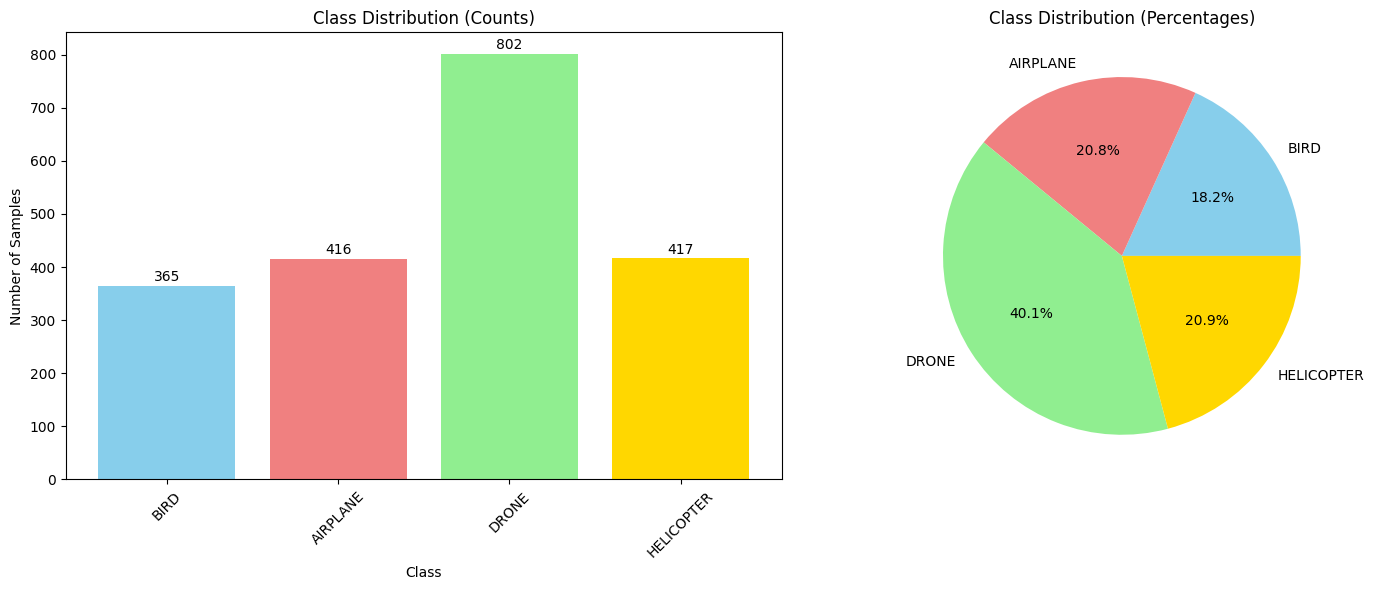

In [258]:
if y_labels is not None:
  class_counts, imbalance_ratio = analyze_class_balance(y_labels, "Training Set")
  eda_results['class_balance'] = {'counts': class_counts, 'imbalance_ratio': imbalance_ratio}

## EDA - Pixel Statistics for Images

Pixel statistics refer to summary statistics computed over the pixel values of images. They help us understand the distribution, intensity, and variation of pixel data.

Pixel statistics help understand:
* Decide whether to normalize or standardize
* Detect outliers or corruption
* Understand contrast and brightness levels
* Compare channels in RGB images

In [259]:
def compute_pixel_statistics(X, y_labels=None):
    '''
    Compute comprehensive pixel statistics for images
    '''
    print("="*60)
    print("Pixel Statistics")
    print("="*60)

    # Overall statistics
    print("Overall Image Statistics:")
    print(f"  Mean pixel value: {np.mean(X):.4f}")
    print(f"  Std pixel value: {np.std(X):.4f}")
    print(f"  Min pixel value: {np.min(X):.4f}")
    print(f"  Max pixel value: {np.max(X):.4f}")

    # Channel-wise statistics
    print("\nChannel-wise Statistics:")
    for i, channel in enumerate(['Red', 'Green', 'Blue']):
        channel_data = X[:, :, :, i]
        print(f"  {channel} channel:")
        print(f"    Mean: {np.mean(channel_data):.4f}")
        print(f"    Std: {np.std(channel_data):.4f}")
        print(f"    Min: {np.min(channel_data):.4f}")
        print(f"    Max: {np.max(channel_data):.4f}")

    # Class-wise statistics if labels provided
    if y_labels is not None:
        print("\nClass-wise Statistics:")
        for class_id in np.unique(y_labels):
            class_images = X[y_labels == class_id]
            if len(class_images) > 0:
                print(f"  {class_names[class_id]}:")
                print(f"    Mean: {np.mean(class_images):.4f}")
                print(f"    Std: {np.std(class_images):.4f}")
                print(f"    Brightness: {np.mean(class_images, axis=(1,2,3)).mean():.4f}")
                print(f"    Contrast: {np.std(class_images, axis=(1,2,3)).mean():.4f}")

    # Visualize pixel distributions
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # Overall pixel histogram
    axes[0, 0].hist(X.flatten(), bins=50, alpha=0.7, color='blue', edgecolor='black')
    axes[0, 0].set_title('Overall Pixel Distribution')
    axes[0, 0].set_xlabel('Pixel Value')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].grid(True, alpha=0.3)

    # Channel-wise histograms
    colors = ['red', 'green', 'blue']
    for i, (channel, color) in enumerate(zip(['Red', 'Green', 'Blue'], colors)):
        axes[0, 1].hist(X[:, :, :, i].flatten(), bins=50, alpha=0.5,
                       label=channel, color=color, edgecolor='black')
    axes[0, 1].set_title('Channel-wise Pixel Distribution')
    axes[0, 1].set_xlabel('Pixel Value')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # Brightness distribution
    brightness = np.mean(X, axis=(1, 2, 3))
    axes[1, 0].hist(brightness, bins=30, alpha=0.7, color='gold', edgecolor='black')
    axes[1, 0].set_title('Image Brightness Distribution')
    axes[1, 0].set_xlabel('Mean Brightness')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].grid(True, alpha=0.3)

    # Contrast distribution
    contrast = np.std(X, axis=(1, 2, 3))
    axes[1, 1].hist(contrast, bins=30, alpha=0.7, color='purple', edgecolor='black')
    axes[1, 1].set_title('Image Contrast Distribution')
    axes[1, 1].set_xlabel('Standard Deviation')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig("images/pixel_statistics.png")
    plt.show()

    return {
        'overall_stats': {'mean': np.mean(X), 'std': np.std(X), 'min': np.min(X), 'max': np.max(X)},
        'brightness': brightness,
        'contrast': contrast
    }

Pixel Statistics
Overall Image Statistics:
  Mean pixel value: 0.5224
  Std pixel value: 0.1708
  Min pixel value: 0.0000
  Max pixel value: 1.0000

Channel-wise Statistics:
  Red channel:
    Mean: 0.4159
    Std: 0.1259
    Min: 0.0000
    Max: 1.0000
  Green channel:
    Mean: 0.5130
    Std: 0.1271
    Min: 0.0000
    Max: 1.0000
  Blue channel:
    Mean: 0.6382
    Std: 0.1752
    Min: 0.0000
    Max: 1.0000

Class-wise Statistics:
  AIRPLANE:
    Mean: 0.5306
    Std: 0.1536
    Brightness: 0.5306
    Contrast: 0.1409
  DRONE:
    Mean: 0.5169
    Std: 0.1892
    Brightness: 0.5169
    Contrast: 0.1824
  HELICOPTER:
    Mean: 0.5301
    Std: 0.1422
    Brightness: 0.5301
    Contrast: 0.1169
  BIRD:
    Mean: 0.5162
    Std: 0.1760
    Brightness: 0.5162
    Contrast: 0.1692


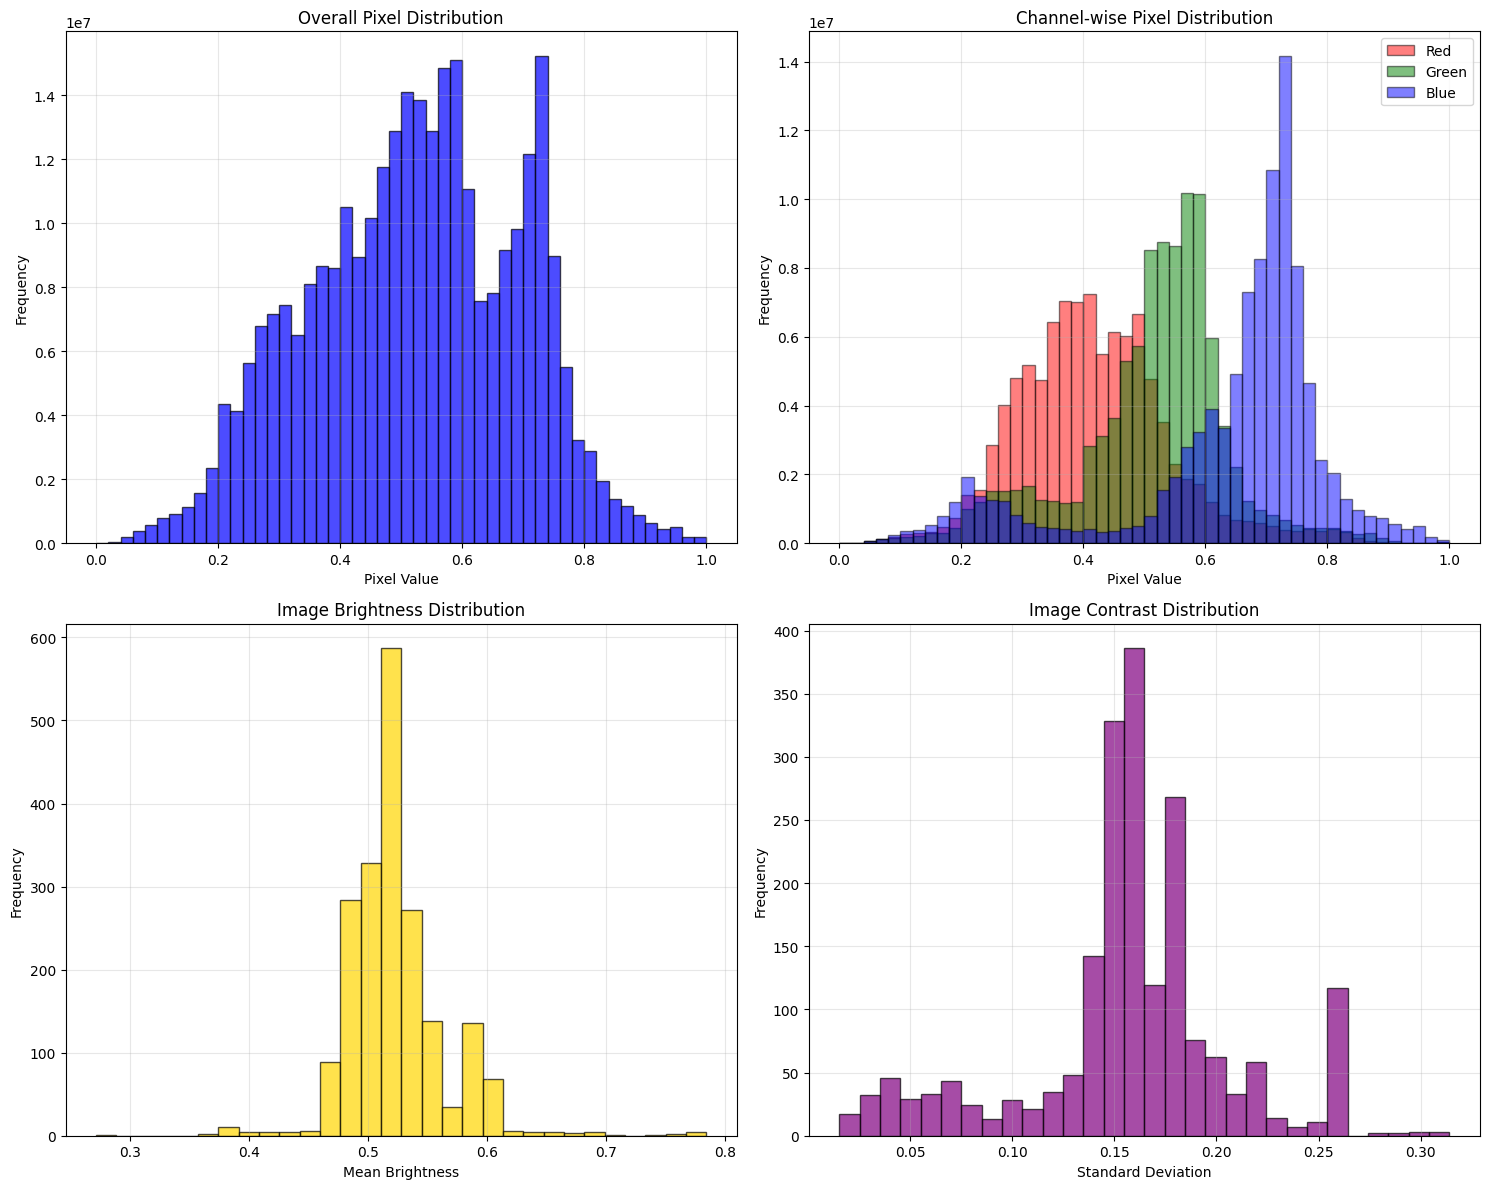

In [260]:
pixel_stats = compute_pixel_statistics(X_train_cls, y_labels)
eda_results['pixel_statistics'] = pixel_stats

### Image Pixel Statistics Summary (with Class-wise Insights)

| **Visualization**                             | **What it Shows**                                                                                                                                              | **Insights**                                                                                                                                               |
|-----------------------------------------------|----------------------------------------------------------------------------------------------------------------------------------------------------------------|------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **Overall & Channel-wise Pixel Distribution** | Shows the overall histogram of pixel values across all images and distributions for each color channel (Red, Green, Blue).                                     | Mean pixel values (~0.51 to 0.53) are similar across classes, indicating a consistent brightness and color balance throughout the dataset.                                        |
| **Image Brightness Distribution**             | Histogram showing the average brightness per image, helping assess lighting consistency.                                                                      | AIRPLANE (0.5306) and HELICOPTER (0.5301) images are slightly brighter on average than DRONE (0.5169) and BIRD (0.5162), but all are close, showing good brightness uniformity. |
| **Image Contrast Distribution**               | Distribution of contrast (standard deviation of pixel values) per image, showing variation in texture and detail.                                              | DRONE images have the highest average contrast (0.1824), indicating sharper features or greater intensity variation. HELICOPTER images have the lowest contrast (0.1169), suggesting smoother appearances. |

---

**Summary**:  
While overall pixel distributions are consistent across classes in brightness and color balance, **contrast** reveals distinct characteristics:  
- **DRONE** and **BIRD** images show **higher contrast**, suggesting more detailed or textured appearances.  
- **HELICOPTER** images show **lower contrast**, suggesting smoother textures or more uniform scenes.  

# EDA - Image Quality Metrics

Image quality metrics are quantitative measures used to assess how good or degraded an image is, often in relation to distortions like noise, blur, compression artifacts, or other imperfections introduced during acquisition, processing, or transmission. These metrics are essential for evaluating the performance of image processing algorithms, camera systems, and computer vision applications.  

We analyzed 6 types of image quality metrics:

* Brightness (mean luminance)
* Contrast (standard deviation)
* Sharpness (variance of Laplacian)
* Entropy (information content)
* Noise level (high frequency energy)
* Color richness (number of unique colors)

In [261]:
def analyze_image_quality_metrics(X, y_labels=None):
    '''
    Analyze various image quality metrics
    '''
    print("="*60)
    print("Image Quality Metrics Analysis")
    print("="*60)

    quality_metrics = {
        'brightness': [],
        'contrast': [],
        'sharpness': [],
        'entropy': [],
        'noise_level': [],
        'color_richness': []
    }

    # Analyze subset of images
    subset_size = min(200, len(X))
    subset_indices = np.random.choice(len(X), subset_size, replace=False)

    print(f"Analyzing {subset_size} images for quality metrics...")

    for i, idx in enumerate(subset_indices):
        img = X[idx]
        gray = rgb2gray(img)

        # 1. Brightness (mean luminance)
        brightness = np.mean(gray)
        quality_metrics['brightness'].append(brightness)

        # 2. Contrast (standard deviation)
        contrast = np.std(gray)
        quality_metrics['contrast'].append(contrast)

        # 3. Sharpness (variance of Laplacian)
        gray_uint8 = (gray * 255).astype(np.uint8)
        laplacian_var = cv2.Laplacian(gray_uint8, cv2.CV_64F).var()
        quality_metrics['sharpness'].append(laplacian_var)

        # 4. Entropy (information content)
        hist, _ = np.histogram(gray.flatten(), bins=256, density=True)
        # Remove zeros to avoid log(0) issues
        hist = hist[hist > 0]
        entropy = -np.sum(hist * np.log2(hist + 1e-10))
        quality_metrics['entropy'].append(entropy)

        # 5. Noise level (high frequency energy)
        # Apply high-pass filter and measure energy
        kernel = np.array([[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]])
        high_freq = cv2.filter2D(gray_uint8, -1, kernel)
        noise_level = np.std(high_freq)
        quality_metrics['noise_level'].append(noise_level)

        # 6. Color richness (number of unique colors)
        img_uint8 = (img * 255).astype(np.uint8)
        # Count unique colors (simplified)
        unique_colors = len(np.unique(img_uint8.reshape(-1, 3), axis=0))
        color_richness = unique_colors / (img_size[0] * img_size[1])  # Normalize
        quality_metrics['color_richness'].append(color_richness)

        if (i + 1) % 50 == 0:
            print(f"Processed {i + 1}/{subset_size} images")

    # Convert to numpy arrays
    for key in quality_metrics:
        quality_metrics[key] = np.array(quality_metrics[key])

    # Print statistics
    print("\nQuality Metrics Statistics:")
    for metric, values in quality_metrics.items():
        print(f"  {metric.replace('_', ' ').title()}:")
        print(f"    Mean: {np.mean(values):.4f}")
        print(f"    Std: {np.std(values):.4f}")
        print(f"    Min: {np.min(values):.4f}")
        print(f"    Max: {np.max(values):.4f}")

    # Visualize quality metrics
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()

    y_subset = y_labels[subset_indices] if y_labels is not None else None
    colors = ['blue', 'red', 'green', 'orange']

    for i, (metric, values) in enumerate(quality_metrics.items()):
        ax = axes[i]

        if y_subset is not None:
            # Plot by class
            for class_id in np.unique(y_subset):
                mask = y_subset == class_id
                if np.sum(mask) > 0:
                    ax.hist(values[mask], bins=20, alpha=0.7,
                           color=colors[class_id], label=class_names[class_id])
            ax.legend()
        else:
            ax.hist(values, bins=20, alpha=0.7, color='skyblue')

        ax.set_title(f'{metric.replace("_", " ").title()} Distribution')
        ax.set_xlabel('Value')
        ax.set_ylabel('Frequency')
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig("images/image_quality_metrics.png")
    plt.show()

    return quality_metrics

Image Quality Metrics Analysis
Analyzing 200 images for quality metrics...
Processed 50/200 images
Processed 100/200 images
Processed 150/200 images
Processed 200/200 images

Quality Metrics Statistics:
  Brightness:
    Mean: 0.5030
    Std: 0.0523
    Min: 0.3320
    Max: 0.7672
  Contrast:
    Mean: 0.0940
    Std: 0.0537
    Min: 0.0156
    Max: 0.2435
  Sharpness:
    Mean: 89.7237
    Std: 109.0941
    Min: 1.1063
    Max: 673.3702
  Entropy:
    Mean: -1647.9343
    Std: 1910.0648
    Min: -11017.5142
    Max: -178.9710
  Noise Level:
    Mean: 13.5028
    Std: 7.8037
    Min: 1.9107
    Max: 38.6621
  Color Richness:
    Mean: 0.1268
    Std: 0.0981
    Min: 0.0067
    Max: 0.5022


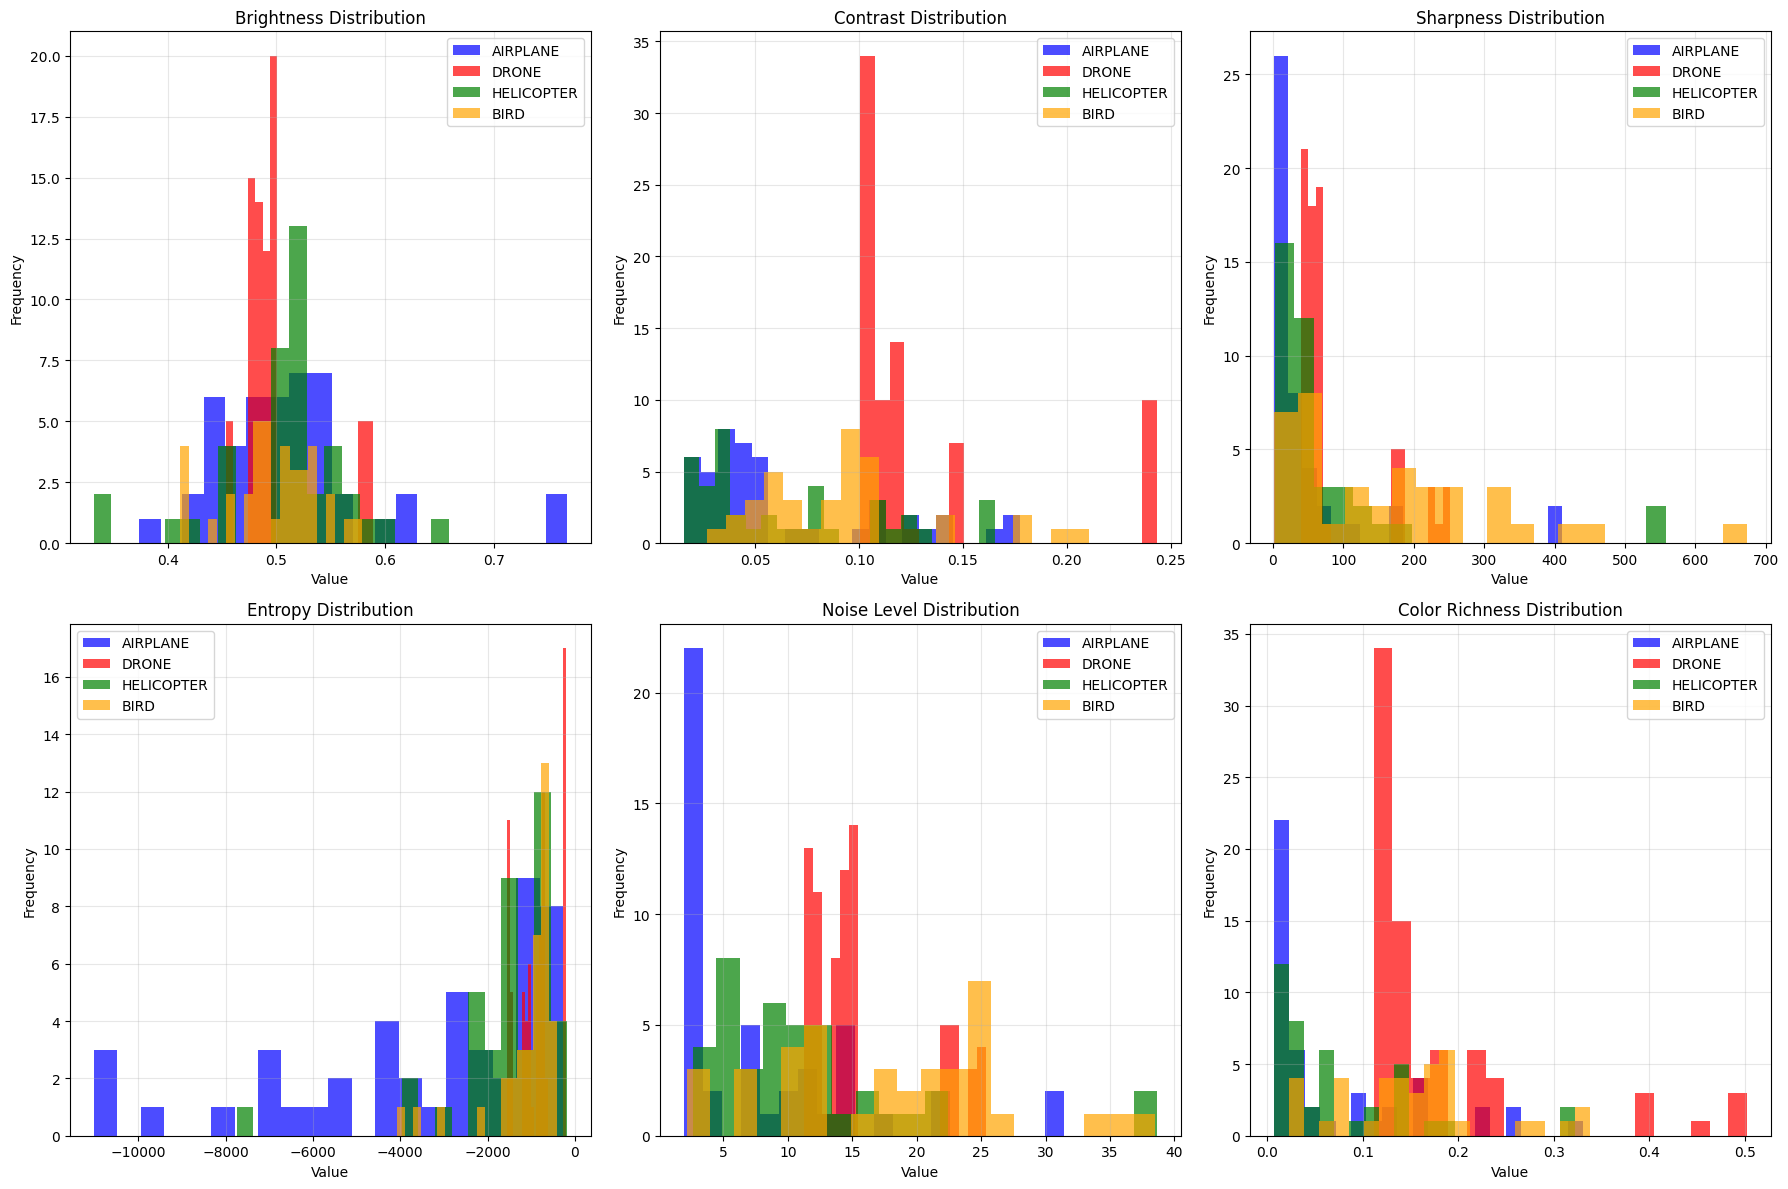

In [262]:
quality_metrics = analyze_image_quality_metrics(X_train_cls, y_labels)
eda_results['quality_metrics'] = quality_metrics

### Class-Wise Image Quality Feature Distributions

| **Visualization**                          | **What it Shows**                                                                                                   | **Insights**                                                                                                                                                                    |
|--------------------------------------------|---------------------------------------------------------------------------------------------------------------------|--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **Brightness Distribution (Colored by Class)** | Histogram of average image brightness, colored by class.                                                            | DRONE images exhibit higher average brightness than BIRD images, indicating they are typically captured against brighter skies.                                                                      |
| **Contrast Distribution (Colored by Class)**    | Histogram of contrast (standard deviation of pixel intensities), per class.                                         | HELICOPTER images show lower contrast than AIRPLANE images, confirming they are often captured in more uniform lighting environments or have smoother textures.                                       |
| **Sharpness Distribution (Colored by Class)**   | Histogram of sharpness using Laplacian variance, indicating image clarity and edge detail.                          | BIRD images show higher sharpness than DRONE images, demonstrating that birds often present finer edge details and textures.                                                                          |
| **Entropy Distribution (Colored by Class)**     | Histogram of image entropy—measuring randomness or information content—across classes.                              | BIRD images exhibit higher entropy than DRONE images, reflecting more complex backgrounds or intricate textures (e.g., feathers or trees).                                                           |
| **Noise Level Distribution (Colored by Class)** | Histogram of estimated noise levels, showing the amount of random variations in the image.                          | DRONE images display higher noise levels compared to BIRD images, suggesting they may be captured from farther distances or under poor lighting conditions.                                           |
| **Color Richness Distribution (Colored by Class)** | Histogram of normalized unique colors in each image, indicating visual diversity.                                   | BIRD images demonstrate higher color richness than DRONE images, confirming that birds often have vibrant plumage and appear in colorful environments like forests or gardens.                        |

---

## EDA - Dimensionality Analysis

PCA (Principal Component Analysis) in image processing is a statistical technique used to reduce the dimensionality of image data while preserving as much important information as possible. In practice, this means transforming a potentially large set of correlated pixel values (features) into a smaller set of uncorrelated variables called principal components.

t-SNE (t-distributed Stochastic Neighbor Embedding) is a nonlinear dimensionality reduction technique primarily used for visualizing high-dimensional data in a lower-dimensional space, typically 2D or 3D. Its main goal is to capture and preserve the local structure and relationships among data points, making it easier to identify patterns, clusters, or groupings that exist in the original high-dimensional space.

In [263]:
def perform_rf_dimensionality_analysis(X_features, y_labels, feature_names):
    '''
    Perform PCA analysis on features
    '''
    print("="*60)
    print("Dimensionality Reduction Analysis - Random Forest")
    print("="*60)

    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_features)

    # PCA Analysis
    pca = PCA()
    X_pca = pca.fit_transform(X_scaled)

    # Plot explained variance
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # Explained variance ratio
    explained_var = pca.explained_variance_ratio_
    cumulative_var = np.cumsum(explained_var)

    axes[0].plot(range(1, min(51, len(explained_var)+1)),
                explained_var[:50], 'b-', linewidth=2)
    axes[0].set_title('PCA: Explained Variance Ratio')
    axes[0].set_xlabel('Principal Component')
    axes[0].set_ylabel('Explained Variance Ratio')
    axes[0].grid(True, alpha=0.3)

    # Cumulative explained variance
    axes[1].plot(range(1, min(51, len(cumulative_var)+1)),
                cumulative_var[:50], 'r-', linewidth=2)
    axes[1].axhline(y=0.95, color='k', linestyle='--', alpha=0.7, label='95% Variance')
    axes[1].set_title('PCA: Cumulative Explained Variance')
    axes[1].set_xlabel('Number of Components')
    axes[1].set_ylabel('Cumulative Explained Variance')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    # 2D PCA visualization
    colors = ['blue', 'red', 'green', 'orange']
    for class_id in np.unique(y_labels):
        mask = y_labels == class_id
        axes[2].scatter(X_pca[mask, 0], X_pca[mask, 1],
                       c=colors[class_id], label=class_names[class_id], alpha=0.7)

    axes[2].set_title('PCA: First Two Components')
    axes[2].set_xlabel(f'PC1 ({explained_var[0]:.2%} variance)')
    axes[2].set_ylabel(f'PC2 ({explained_var[1]:.2%} variance)')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Find number of components for 95% variance
    n_components_95 = np.argmax(cumulative_var >= 0.95) + 1
    print(f"Components needed for 95% variance: {n_components_95}")

    return pca, n_components_95

### Dimensionality Reduction Analysis - CNN

These Dimensionality analysis provide complementary views on the **structure and dimensionality** of the dataset. They help answer:
- How separable are the classes?
- Can dimensionality be reduced without losing key information?

In [264]:
def perform_cnn_dimensionality_analysis(X, y_labels=None):
    '''
    Perform dimensionality reduction and visualization
    '''
    print("="*60)
    print("Dimensionality Reduction Analysis - CNN")
    print("="*60)

    # Flatten images for analysis
    X_flat = X.reshape(X.shape[0], -1)

    # Subsample for computational efficiency
    n_samples = min(500, len(X_flat))
    indices = np.random.choice(len(X_flat), n_samples, replace=False)
    X_subset = X_flat[indices]
    y_subset = y_labels[indices] if y_labels is not None else None

    print(f"Analyzing {n_samples} samples...")

    # 1. PCA Analysis
    print("Performing PCA...")
    pca = PCA()
    X_pca = pca.fit_transform(X_subset)

    # Plot explained variance ratio
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # Explained variance ratio
    explained_var = pca.explained_variance_ratio_
    cumulative_var = np.cumsum(explained_var)

    axes[0, 0].plot(range(1, min(51, len(explained_var)+1)),
                   explained_var[:50], 'b-', linewidth=2)
    axes[0, 0].set_title('PCA: Explained Variance Ratio')
    axes[0, 0].set_xlabel('Principal Component')
    axes[0, 0].set_ylabel('Explained Variance Ratio')
    axes[0, 0].grid(True, alpha=0.3)

    # Cumulative explained variance
    axes[0, 1].plot(range(1, min(51, len(cumulative_var)+1)),
                   cumulative_var[:50], 'r-', linewidth=2)
    axes[0, 1].axhline(y=0.95, color='k', linestyle='--', alpha=0.7, label='95% Variance')
    axes[0, 1].set_title('PCA: Cumulative Explained Variance')
    axes[0, 1].set_xlabel('Number of Components')
    axes[0, 1].set_ylabel('Cumulative Explained Variance')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # Find number of components for 95% variance
    n_components_95 = np.argmax(cumulative_var >= 0.95) + 1
    print(f"Components needed for 95% variance: {n_components_95}")

    # 2D PCA visualization
    if y_subset is not None:
        colors = ['blue', 'red', 'green', 'orange']
        for class_id in np.unique(y_subset):
            mask = y_subset == class_id
            axes[1, 0].scatter(X_pca[mask, 0], X_pca[mask, 1],
                             c=colors[class_id], label=class_names[class_id], alpha=0.7)
        axes[1, 0].legend()
    else:
        axes[1, 0].scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.7)

    axes[1, 0].set_title('PCA: First Two Components')
    axes[1, 0].set_xlabel(f'PC1 ({explained_var[0]:.2%} variance)')
    axes[1, 0].set_ylabel(f'PC2 ({explained_var[1]:.2%} variance)')
    axes[1, 0].grid(True, alpha=0.3)

    # 2. t-SNE Analysis
    print("Performing t-SNE...")
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    X_tsne = tsne.fit_transform(X_subset[:200])
    y_tsne = y_subset[:200] if y_subset is not None else None

    if y_tsne is not None:
        for class_id in np.unique(y_tsne):
            mask = y_tsne == class_id
            axes[1, 1].scatter(X_tsne[mask, 0], X_tsne[mask, 1],
                             c=colors[class_id], label=class_names[class_id], alpha=0.7)
        axes[1, 1].legend()
    else:
        axes[1, 1].scatter(X_tsne[:, 0], X_tsne[:, 1], alpha=0.7)

    axes[1, 1].set_title('t-SNE Visualization')
    axes[1, 1].set_xlabel('t-SNE 1')
    axes[1, 1].set_ylabel('t-SNE 2')
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig("images/cnn_pca_analysis.png")
    plt.show()

    return {
        'pca': pca,
        'explained_variance_ratio': explained_var,
        'n_components_95': n_components_95,
        'X_pca': X_pca,
        'X_tsne': X_tsne
    }

Dimensionality Reduction Analysis - CNN
Analyzing 500 samples...
Performing PCA...
Components needed for 95% variance: 26
Performing t-SNE...


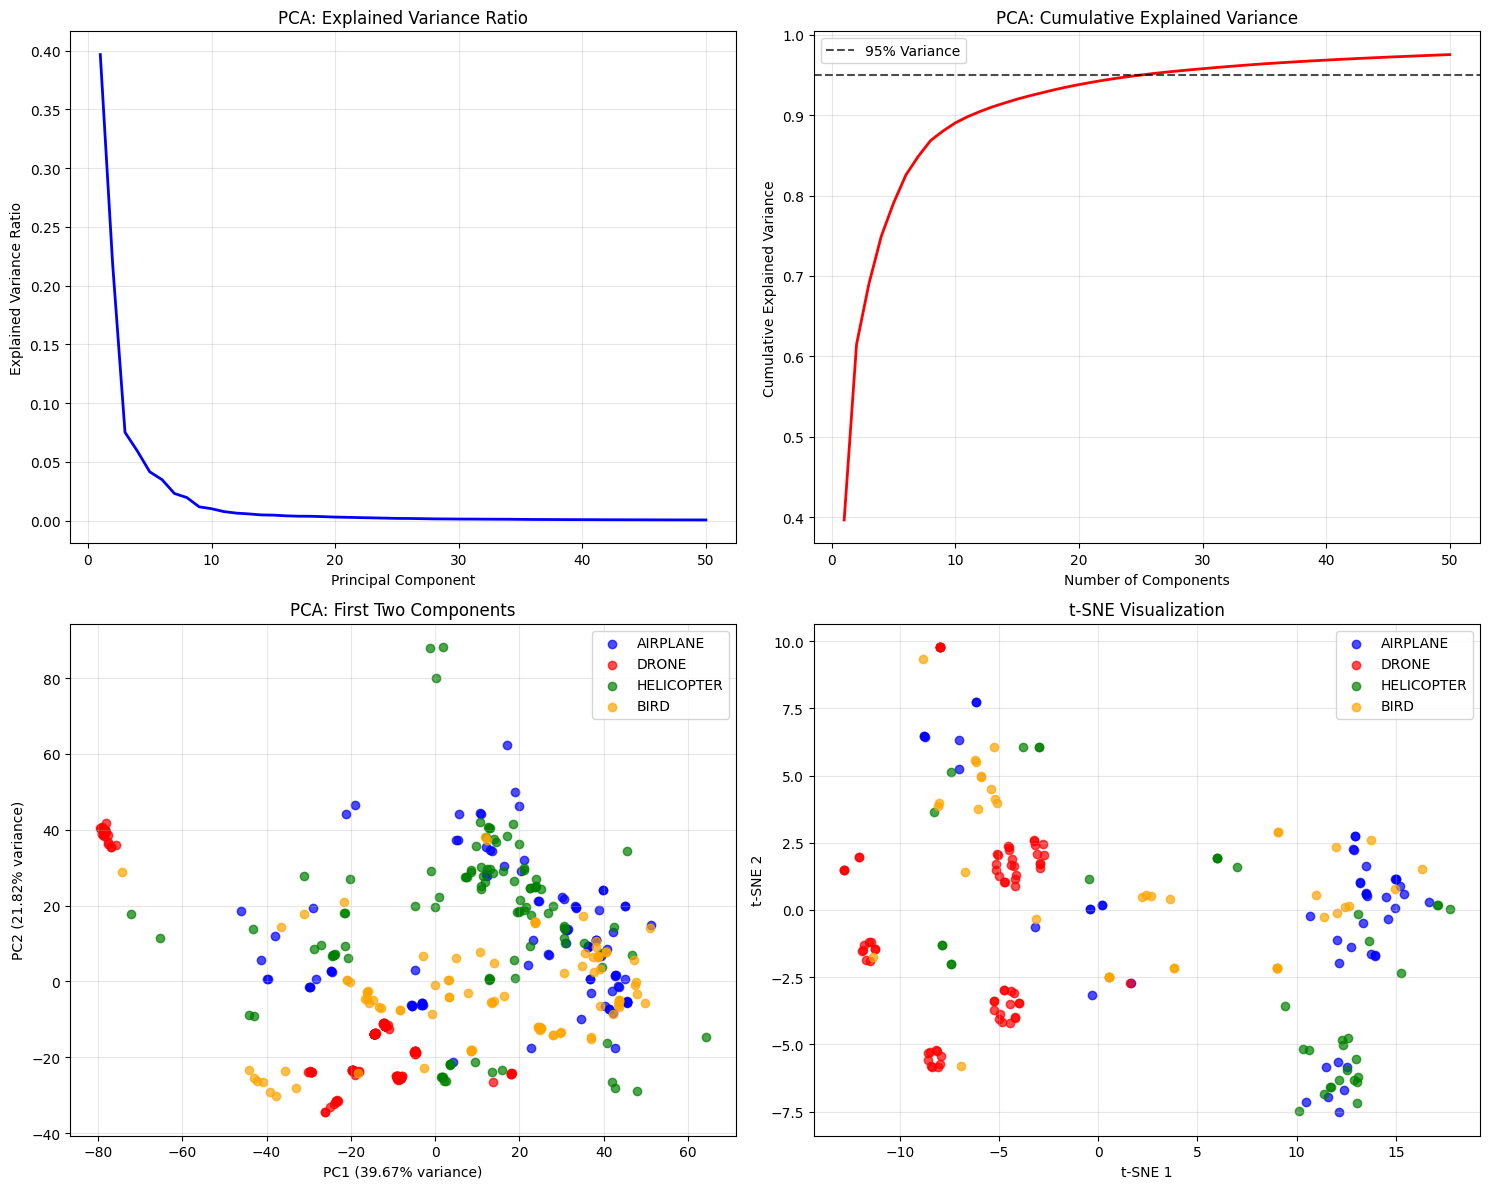

In [265]:
dim_analysis = perform_cnn_dimensionality_analysis(X_train_cls, y_labels)
eda_results['dimensionality'] = dim_analysis

### Dimensionality Reduction Visualization Summary

| **Visualization**                | **What it Shows**                                                                                                                                                                              | **Insights**                                                                                                                                                                                                                                            |
|----------------------------------|------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **PCA: Explained Variance Ratio** | Line plot showing how much variance is captured by each principal component, ordered from highest to lowest.                                                                                  | - Reveals how informative each component is.<br>- A steep drop suggests that few components capture most variance.<br>- Flatter curve means variance is spread more evenly across components.                                                          |
| **PCA: Cumulative Explained Variance** | Line plot showing cumulative variance captured as more components are included, with a common threshold at 95%.                                                                         | - Helps determine how many components retain most of the variance (e.g., 95%).<br>- If few components are needed, data is low-dimensional.<br>- Useful for feature reduction and efficient representation.                                              |
| **PCA: First Two Components**     | Scatter plot of data projected onto the first two principal components. Color indicates class label.                                                                                         | - Provides visual assessment of class separation using linear projection.<br>- Clear clusters → useful features for classification.<br>- Overlap means more components or nonlinear techniques may be needed.                                           |
| **t-SNE Visualization**          | 2D scatter plot of data using t-SNE. Preserves local structure, with color representing class.                                                                                               | - Highlights non-linear relationships and natural clusters.<br>- Better at revealing separability than PCA for complex data.<br>- Helpful for evaluating potential of non-linear models (e.g., deep networks).                                        |

--------------

## EDA - Analyzing Spatial Patterns

Spatial patterns is the process of examining how objects, events, or features are distributed across space to gain insights into underlying processes or relationships.  

These pattern analysis offer a deep look into **spatial and textural characteristics** of the dataset and can inform:
- Feature selection and engineering
- Preprocessing strategies
- Neural network architecture decisions

In [266]:
def analyze_spatial_patterns(X, y_labels=None):
    '''
    Analyze spatial patterns and object distributions
    '''
    print("="*60)
    print("Spatial Pattern Analysis")
    print("="*60)

    # Analyze object positioning from bounding boxes if available
    spatial_stats = {
        'center_positions': [],
        'object_sizes': [],
        'aspect_ratios': [],
        'edge_distances': []
    }

    # For demonstration, create some analysis of spatial patterns
    print("Analyzing spatial distributions in images...")

    # Sample images for spatial analysis
    n_samples = min(50, len(X))
    sample_indices = np.random.choice(len(X), n_samples, replace=False)

    fig, axes = plt.subplots(2, 3, figsize=(18, 12))

    # 1. Center region analysis
    center_intensities = []
    edge_intensities = []

    for idx in sample_indices:
        img = X[idx]
        gray = rgb2gray(img)
        h, w = gray.shape

        # Define center and edge regions
        center_region = gray[h//4:3*h//4, w//4:3*w//4]
        edge_region = np.concatenate([
            gray[:h//4, :].flatten(),
            gray[3*h//4:, :].flatten(),
            gray[:, :w//4].flatten(),
            gray[:, 3*w//4:].flatten()
        ])

        center_intensities.append(np.mean(center_region))
        edge_intensities.append(np.mean(edge_region))

    axes[0, 0].scatter(center_intensities, edge_intensities, alpha=0.7)
    axes[0, 0].plot([0, 1], [0, 1], 'r--', alpha=0.5)
    axes[0, 0].set_xlabel('Center Intensity')
    axes[0, 0].set_ylabel('Edge Intensity')
    axes[0, 0].set_title('Center vs Edge Intensity')
    axes[0, 0].grid(True, alpha=0.3)

    # 2. Gradient magnitude analysis
    gradient_stats = []
    for idx in sample_indices:
        img = X[idx]
        gray = rgb2gray(img)

        # Calculate gradients
        grad_x = np.gradient(gray, axis=1)
        grad_y = np.gradient(gray, axis=0)
        gradient_magnitude = np.sqrt(grad_x**2 + grad_y**2)

        gradient_stats.append(np.mean(gradient_magnitude))

    axes[0, 1].hist(gradient_stats, bins=15, alpha=0.7, color='green')
    axes[0, 1].set_xlabel('Mean Gradient Magnitude')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].set_title('Gradient Magnitude Distribution')
    axes[0, 1].grid(True, alpha=0.3)

    # 3. Corner detection analysis
    corner_counts = []
    for idx in sample_indices[:20]:  # Limit for computational efficiency
        img = X[idx]
        gray = rgb2gray(img)
        gray_uint8 = (gray * 255).astype(np.uint8)

        # Harris corner detection
        corners = cv2.cornerHarris(gray_uint8, blockSize=2, ksize=3, k=0.04)
        corner_count = np.sum(corners > 0.01 * corners.max())
        corner_counts.append(corner_count)

    axes[0, 2].hist(corner_counts, bins=10, alpha=0.7, color='orange')
    axes[0, 2].set_xlabel('Number of Corners')
    axes[0, 2].set_ylabel('Frequency')
    axes[0, 2].set_title('Corner Detection Analysis')
    axes[0, 2].grid(True, alpha=0.3)

    # 4. Symmetry analysis
    symmetry_scores = []
    for idx in sample_indices:
        img = X[idx]
        gray = rgb2gray(img)

        # Vertical symmetry
        left_half = gray[:, :gray.shape[1]//2]
        right_half = np.fliplr(gray[:, gray.shape[1]//2:])

        # Ensure same size for symmetry comparison
        min_width = min(left_half.shape[1], right_half.shape[1])
        min_height = min(left_half.shape[0], right_half.shape[0])
        left_half = left_half[:min_height, :min_width]
        right_half = right_half[:min_height, :min_width]

        symmetry_score = 1 - np.mean(np.abs(left_half - right_half))
        symmetry_scores.append(symmetry_score)

    axes[1, 0].hist(symmetry_scores, bins=15, alpha=0.7, color='purple')
    axes[1, 0].set_xlabel('Symmetry Score')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].set_title('Vertical Symmetry Analysis')
    axes[1, 0].grid(True, alpha=0.3)

    # 5. Frequency domain analysis
    frequency_energies = []
    for idx in sample_indices:
        img = X[idx]
        gray = rgb2gray(img)

        # FFT analysis
        fft = np.fft.fft2(gray)
        fft_shift = np.fft.fftshift(fft)
        magnitude_spectrum = np.log(np.abs(fft_shift) + 1)

        # High frequency energy
        h, w = magnitude_spectrum.shape
        center_h, center_w = h//2, w//2
        high_freq_region = magnitude_spectrum.copy()
        high_freq_region[center_h-h//8:center_h+h//8, center_w-w//8:center_w+w//8] = 0

        high_freq_energy = np.sum(high_freq_region)
        frequency_energies.append(high_freq_energy)

    axes[1, 1].hist(frequency_energies, bins=15, alpha=0.7, color='red')
    axes[1, 1].set_xlabel('High Frequency Energy')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].set_title('Frequency Domain Analysis')
    axes[1, 1].grid(True, alpha=0.3)

    # 6. Texture complexity
    texture_complexity = []
    for idx in sample_indices:
        img = X[idx]
        gray = rgb2gray(img)

        # Calculate local variance as texture measure using a simple approach
        kernel_size = 5
        h, w = gray.shape
        local_vars = []

        for i in range(0, h-kernel_size+1, kernel_size):
            for j in range(0, w-kernel_size+1, kernel_size):
                patch = gray[i:i+kernel_size, j:j+kernel_size]
                local_vars.append(np.var(patch))

        complexity = np.mean(local_vars) if local_vars else 0
        texture_complexity.append(complexity)

    axes[1, 2].hist(texture_complexity, bins=15, alpha=0.7, color='brown')
    axes[1, 2].set_xlabel('Texture Complexity')
    axes[1, 2].set_ylabel('Frequency')
    axes[1, 2].set_title('Texture Complexity Analysis')
    axes[1, 2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig("images/spatial_patterns_analysis.png")
    plt.show()

    return {
        'center_intensities': center_intensities,
        'edge_intensities': edge_intensities,
        'gradient_stats': gradient_stats,
        'corner_counts': corner_counts,
        'symmetry_scores': symmetry_scores,
        'frequency_energies': frequency_energies,
        'texture_complexity': texture_complexity
    }

Spatial Pattern Analysis
Analyzing spatial distributions in images...


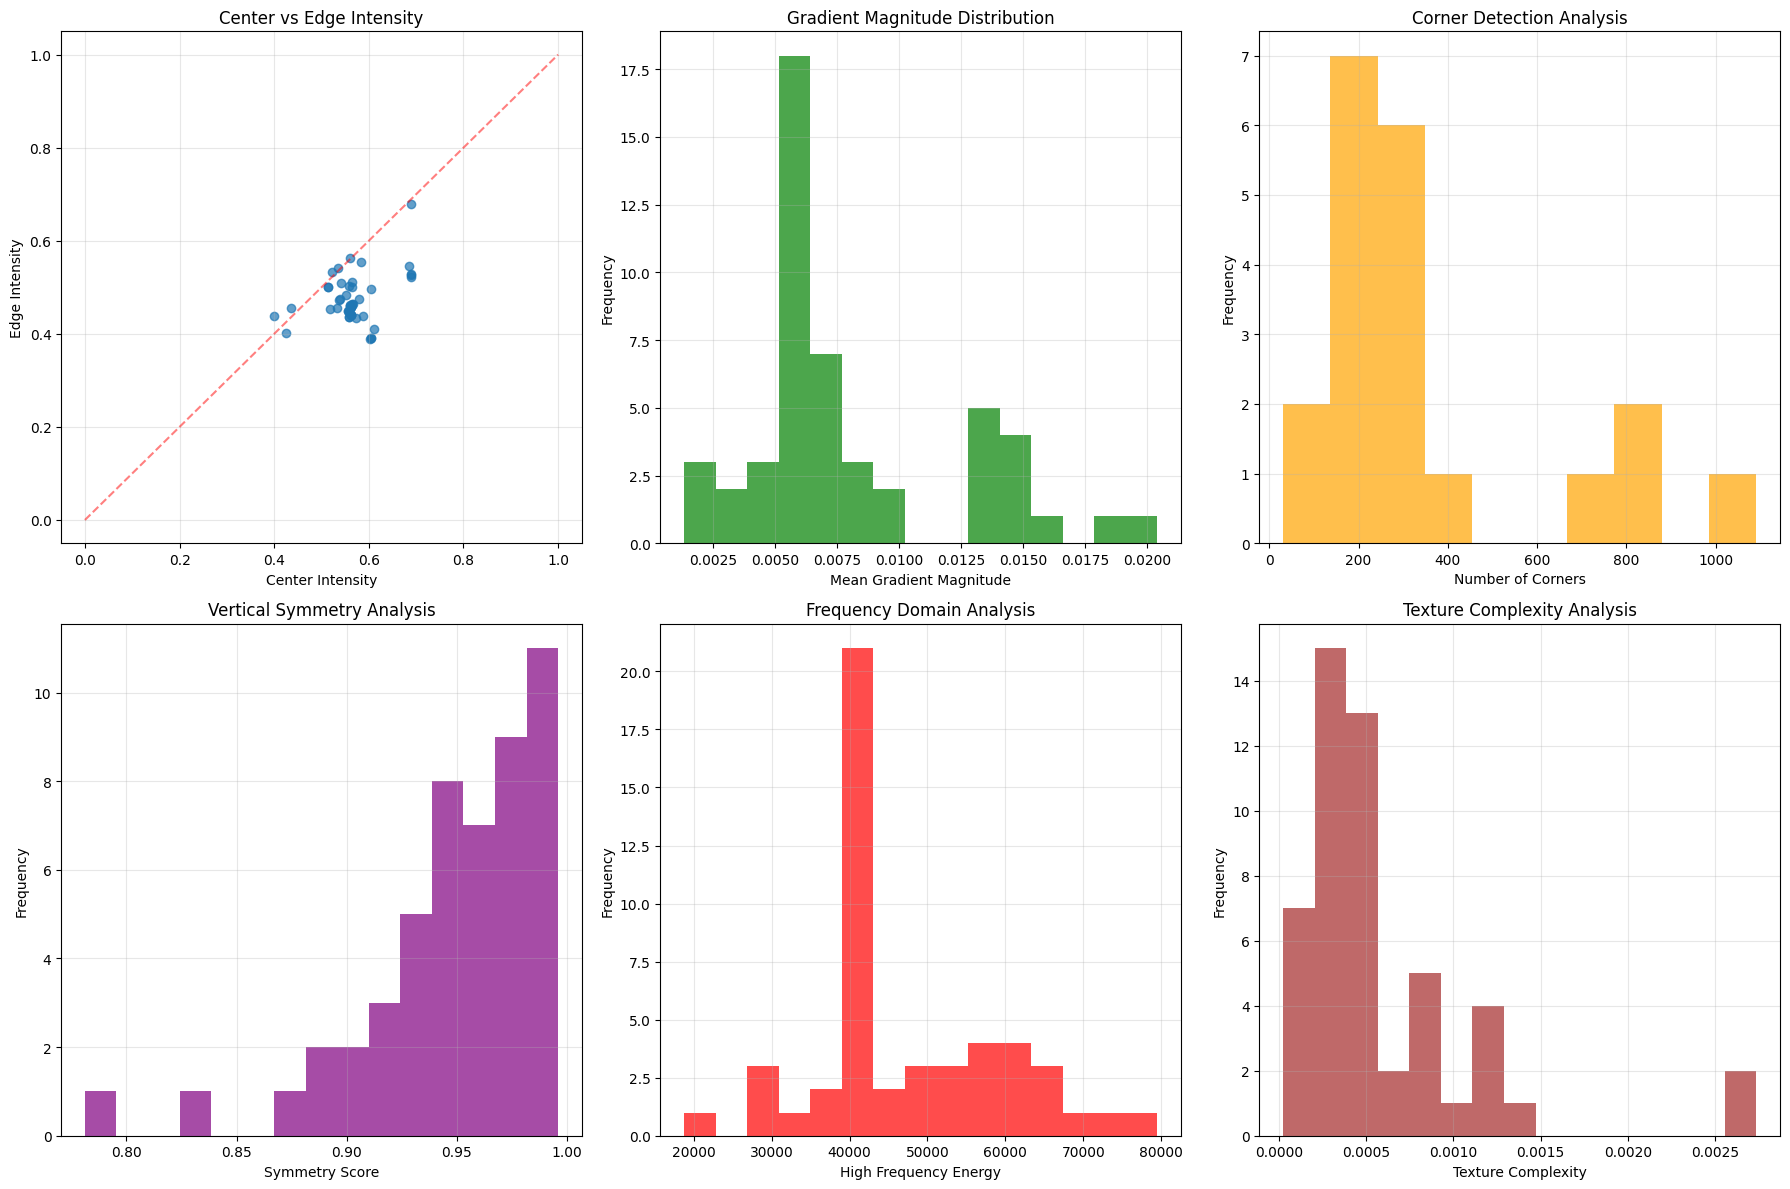

In [267]:
spatial_patterns = analyze_spatial_patterns(X_train_cls, y_labels)
eda_results['spatial_patterns'] = spatial_patterns

### Spatial Patterns Analysis Summary

| **Visualization**                | **What it Shows**                                                                                                                                                       | **Insights**                                                                                                                                                                                                 |
|----------------------------------|-------------------------------------------------------------------------------------------------------------------------------------------------------------------------|-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **Center vs Edge Intensity**     | Compares average pixel intensity in the center of the image vs. the edges.                                                                                              | - Clusters along the diagonal imply uniform intensity.<br>- Deviations suggest contrast between object (center) and background (edges).<br>- Useful for spatial focus clues.                             |
| **Gradient Magnitude Distribution** | Histogram of mean gradient magnitudes (rate of pixel intensity change).                                                                                                  | - Indicates level of detail or texture in images.<br>- Higher values mean sharper, more detailed images.<br>- Helps identify variation in texture or edge density across the dataset.                    |
| **Corner Detection Analysis**    | Histogram of number of detected corners (using Harris detector).                                                                                                        | - Measures shape/structure complexity.<br>- More corners → more intricate shapes.<br>- Differences across classes can reflect object structure (e.g., drones vs airplanes).                              |
| **Vertical Symmetry Analysis**   | Distribution of vertical symmetry score (comparing left and right halves of images).                                                                                    | - Higher scores imply strong symmetry (e.g., frontal view of airplane).<br>- Can help differentiate symmetrical objects from asymmetrical ones.                                                            |
| **Frequency Domain Analysis**    | Histogram of high-frequency energy from Fourier Transform spectrum.                                                                                                     | - Highlights presence of fine details and edges.<br>- Complements gradient analysis.<br>- Useful for understanding texture richness.                                                                      |
| **Texture Complexity Analysis**  | Distribution of mean local variance (a measure of texture).                                                                                                             | - Higher values → more complex textures.<br>- Helps identify texture-heavy objects (e.g., birds with feathers vs smooth drones).                                                                          |

---

In [268]:
def eda_report(X):
    '''
    Generate a EDA report based recommendation
    '''
    # 7. Generate recommendations
    print("\n" + "="*60)
    print("RECOMMENDATIONS BASED ON EDA")
    print("="*60)

    recommendations = []

    # Class imbalance recommendations
    if y_labels is not None and imbalance_ratio > 2:
        recommendations.append(f"• High class imbalance detected (ratio: {imbalance_ratio:.2f}). Consider data augmentation or class weighting.")

    # Brightness recommendations
    brightness_std = np.std(pixel_stats['brightness'])
    if brightness_std > 0.2:
        recommendations.append("• High brightness variation detected. Consider brightness normalization.")

    # Contrast recommendations
    contrast_mean = np.mean(pixel_stats['contrast'])
    if contrast_mean < 0.1:
        recommendations.append("• Low contrast images detected. Consider contrast enhancement techniques.")

    # Sharpness recommendations
    sharpness_values = quality_metrics['sharpness']
    if np.mean(sharpness_values) < 100:
        recommendations.append("• Low sharpness detected in some images. Consider sharpening filters.")

    # Noise recommendations
    noise_values = quality_metrics['noise_level']
    if np.mean(noise_values) > 50:
        recommendations.append("• High noise levels detected. Consider denoising techniques.")

    # Dimensionality recommendations
    if dim_analysis['n_components_95'] < X.shape[1] * X.shape[2] * X.shape[3] * 0.1:
        recommendations.append("• Low intrinsic dimensionality detected. PCA preprocessing might be beneficial.")

    if len(recommendations) == 0:
        recommendations.append("• Dataset appears to be of good quality. Standard preprocessing should be sufficient.")

    for rec in recommendations:
        print(rec)

    eda_results['recommendations'] = recommendations

    return eda_results

In [269]:
eda_results = eda_report(X_train_cls)


RECOMMENDATIONS BASED ON EDA
• High class imbalance detected (ratio: 2.20). Consider data augmentation or class weighting.
• Low sharpness detected in some images. Consider sharpening filters.
• Low intrinsic dimensionality detected. PCA preprocessing might be beneficial.


# Image Preprocessing

## Denoising Images

Denoising is the process of removing noise (unwanted random variations or artifacts) from data — especially images, audio, or signals — to improve quality and clarity.

In image denoising, the goal is to:
* Preserve important features like edges and textures
* Eliminate unwanted variations like grain, blur, or compression artifacts

In [270]:
def apply_denoising_techniques(X, y_labels=None):
    '''
    Apply various denoising and preprocessing techniques
    '''
    print("="*60)
    print("DENOISING AND PREPROCESSING")
    print("="*60)

    # Select a sample image for demonstration
    sample_idx = 0
    sample_img = X[sample_idx]

    # Convert to uint8 for OpenCV operations
    sample_img_uint8 = (sample_img * 255).astype(np.uint8)

    # Apply various denoising techniques
    techniques = {}

    # 1. Gaussian Blur
    gaussian_blur = cv2.GaussianBlur(sample_img_uint8, (5, 5), 0)
    techniques['Gaussian Blur'] = gaussian_blur / 255.0

    # 2. Median Filter
    median_filter = cv2.medianBlur(sample_img_uint8, 5)
    techniques['Median Filter'] = median_filter / 255.0

    # 3. Bilateral Filter
    bilateral_filter = cv2.bilateralFilter(sample_img_uint8, 9, 75, 75)
    techniques['Bilateral Filter'] = bilateral_filter / 255.0

    # 4. Non-local Means Denoising
    nlm_denoised = cv2.fastNlMeansDenoisingColored(sample_img_uint8, None, 10, 10, 7, 21)
    techniques['NLM Denoising'] = nlm_denoised / 255.0

    # 5. Grayscale conversion
    gray_img = cv2.cvtColor(sample_img_uint8, cv2.COLOR_RGB2GRAY)
    techniques['Grayscale'] = gray_img / 255.0

    # 6. Edge Enhancement (Unsharp Masking)
    gaussian = cv2.GaussianBlur(sample_img_uint8, (0, 0), 2.0)
    unsharp_mask = cv2.addWeighted(sample_img_uint8, 1.5, gaussian, -0.5, 0)
    techniques['Edge Enhanced'] = unsharp_mask / 255.0

    # 7. Histogram Equalization
    img_yuv = cv2.cvtColor(sample_img_uint8, cv2.COLOR_RGB2YUV)
    img_yuv[:, :, 0] = cv2.equalizeHist(img_yuv[:, :, 0])
    hist_eq = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB)
    techniques['Histogram Equalized'] = hist_eq / 255.0

    # 8. CLAHE (Contrast Limited Adaptive Histogram Equalization)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    img_lab = cv2.cvtColor(sample_img_uint8, cv2.COLOR_RGB2LAB)
    img_lab[:, :, 0] = clahe.apply(img_lab[:, :, 0])
    clahe_img = cv2.cvtColor(img_lab, cv2.COLOR_LAB2RGB)
    techniques['CLAHE'] = clahe_img / 255.0

    # Visualize all techniques
    fig, axes = plt.subplots(3, 3, figsize=(18, 15))
    axes = axes.flatten()

    # Original image
    axes[0].imshow(sample_img)
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    # Denoised images
    for i, (name, img) in enumerate(techniques.items(), 1):
        if len(img.shape) == 3:
            axes[i].imshow(img)
        else:
            axes[i].imshow(img, cmap='gray')
        axes[i].set_title(name)
        axes[i].axis('off')

    plt.tight_layout()
    plt.savefig("images/denoised_images.png")
    plt.show()

    # Apply denoising to entire dataset
    print("\nApplying Gaussian blur to entire dataset...")
    X_denoised = np.zeros_like(X)
    for i in range(len(X)):
        img_uint8 = (X[i] * 255).astype(np.uint8)
        blurred = cv2.GaussianBlur(img_uint8, (3, 3), 0)
        X_denoised[i] = blurred / 255.0

        if (i + 1) % 100 == 0:
            print(f"Processed {i + 1}/{len(X)} images")

    return X_denoised, techniques

### Apply denoising techniques


Applying denoising techniques...
DENOISING AND PREPROCESSING


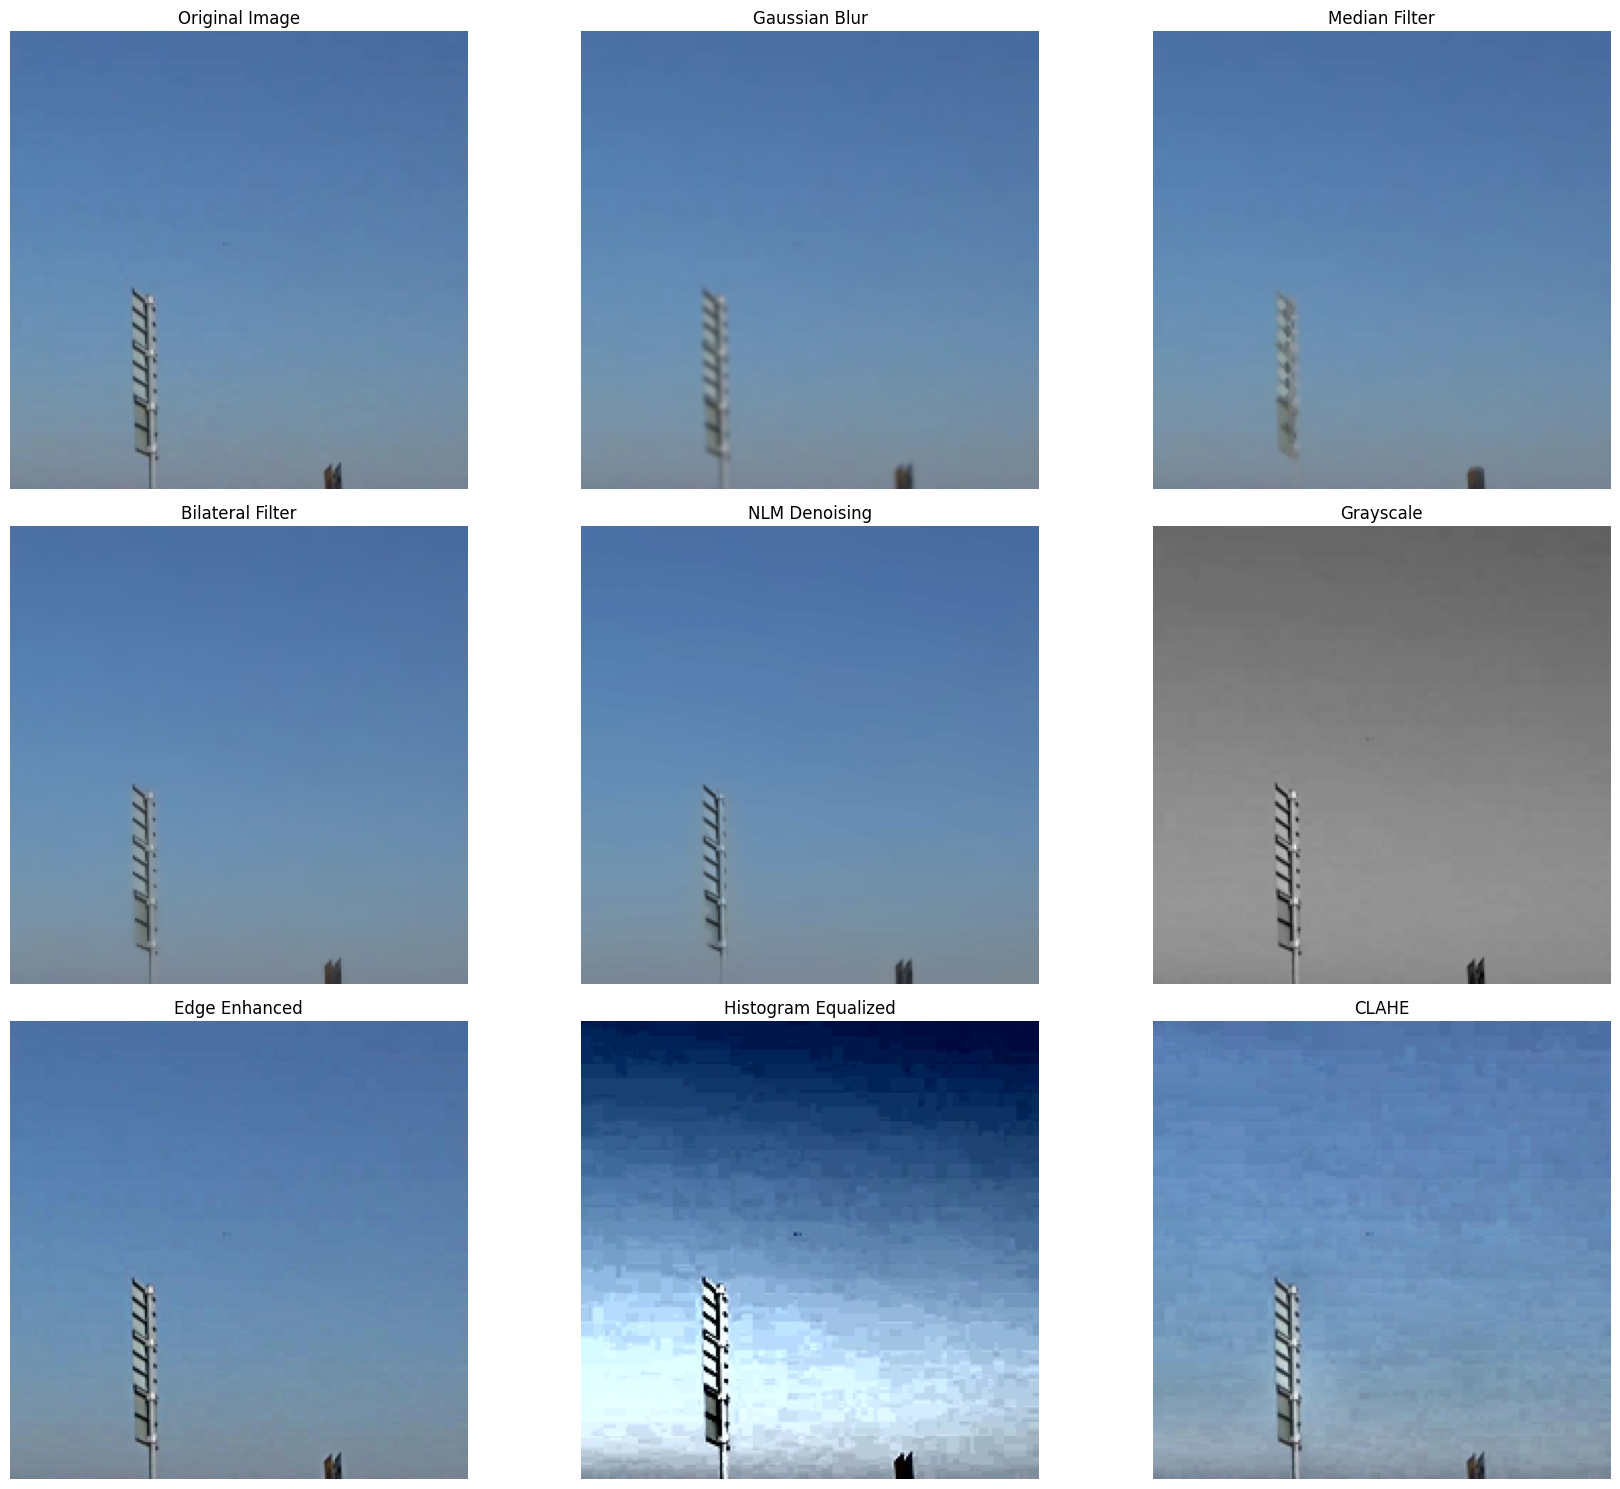


Applying Gaussian blur to entire dataset...
Processed 100/2000 images
Processed 200/2000 images
Processed 300/2000 images
Processed 400/2000 images
Processed 500/2000 images
Processed 600/2000 images
Processed 700/2000 images
Processed 800/2000 images
Processed 900/2000 images
Processed 1000/2000 images
Processed 1100/2000 images
Processed 1200/2000 images
Processed 1300/2000 images
Processed 1400/2000 images
Processed 1500/2000 images
Processed 1600/2000 images
Processed 1700/2000 images
Processed 1800/2000 images
Processed 1900/2000 images
Processed 2000/2000 images


In [271]:
print("\nApplying denoising techniques...")
X_train_denoised, denoising_techniques = apply_denoising_techniques(X_train_cls, y_train_cls)

# Feature Extractions

Image Feature extraction involves transforming raw data into meaningful information that machine learning models can learn from.

## Sobel Filter Edge Detection

The Sobel filter is a edge detection operator used in image processing and computer vision to find edges based on gradients.

It highlights regions of the image with high spatial frequency — i.e., where the intensity (brightness) changes sharply. These are often boundaries or outlines of objects in the image.

In [272]:
def sobel_filter_edge_detection(image):
    '''
    Safe Sobel filter with fallback
    '''
    try:
        return filters.sobel(image)
    except:
        # Fallback: manual Sobel implementation
        sobel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
        sobel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])

        # Apply convolution (simplified)
        grad_x = cv2.filter2D(image.astype(np.float32), -1, sobel_x)
        grad_y = cv2.filter2D(image.astype(np.float32), -1, sobel_y)

        return np.sqrt(grad_x**2 + grad_y**2)

## Feature extraction for Random Forest Classifier

In [273]:
def visualize_rf_feature_distributions(X_features, y_labels, feature_names, num_features=12):
    '''
    Visualize distributions of most important features for Random Forest
    '''
    print("="*60)
    print("VISUALIZING FEATURE DISTRIBUTIONS - RANDOM FOREST")
    print("="*60)

    # For demonstration, show distributions of first num_features features
    features_to_show = min(num_features, len(feature_names))

    rows = (features_to_show + 2) // 3
    cols = 3
    fig, axes = plt.subplots(rows, cols, figsize=(15, 5*rows))
    axes = axes.flatten()

    colors = ['blue', 'red', 'green', 'orange']

    for i in range(features_to_show):
        ax = axes[i]
        feature_data = X_features[:, i]

        # Plot histogram by class
        for class_id in np.unique(y_labels):
            mask = y_labels == class_id
            if np.sum(mask) > 0:
                ax.hist(feature_data[mask], bins=20, alpha=0.7,
                       color=colors[class_id], label=class_names[class_id])

        ax.set_title(f'{feature_names[i]}')
        ax.set_xlabel('Feature Value')
        ax.set_ylabel('Frequency')
        ax.legend()
        ax.grid(True, alpha=0.3)

    # Hide unused subplots
    for i in range(features_to_show, len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.savefig("images/rf_features_distribution.png")
    plt.show()

In [274]:
def extract_rf_features(X, y_labels=None):
    '''
    Extract features for Random Forest model
    '''
    print("="*60)
    print("EXTRACTING FEATURES FOR RANDOM FOREST")
    print("="*60)

    n_samples = len(X)
    print(f"Extracting features from {n_samples} images...")

    all_features = []
    feature_names = []

    for i, img in enumerate(X):
        img_features = []

        # Convert to different color spaces for feature extraction
        gray = rgb2gray(img)

        # 1. Basic Statistical Features (per channel + grayscale)
        for ch_idx, ch_name in enumerate(['R', 'G', 'B']):
            channel = img[:, :, ch_idx]
            img_features.extend([
                np.mean(channel),
                np.std(channel),
                np.min(channel),
                np.max(channel),
                np.median(channel),
                scipy_stats.skew(channel.flatten()),
                scipy_stats.kurtosis(channel.flatten()),
                np.percentile(channel, 25),
                np.percentile(channel, 75)
            ])

            if i == 0:  # Add feature names only once
                feature_names.extend([
                    f'{ch_name}_mean', f'{ch_name}_std', f'{ch_name}_min', f'{ch_name}_max',
                    f'{ch_name}_median', f'{ch_name}_skew', f'{ch_name}_kurtosis',
                    f'{ch_name}_q25', f'{ch_name}_q75'
                ])

        # 2. Grayscale Statistical Features
        hist, _ = np.histogram(gray.flatten(), bins=256, density=True)
        hist = hist[hist > 0]
        entropy_val = -np.sum(hist * np.log2(hist + 1e-10))

        img_features.extend([
            np.mean(gray),
            np.std(gray),
            entropy_val,
            np.var(gray),
            scipy_stats.skew(gray.flatten()),
            scipy_stats.kurtosis(gray.flatten())
        ])

        if i == 0:
            feature_names.extend([
                'gray_mean', 'gray_std', 'gray_entropy', 'gray_var',
                'gray_skew', 'gray_kurtosis'
            ])

        # 3. Color Histogram Features (simplified)
        for ch_idx, ch_name in enumerate(['R', 'G', 'B']):
            channel = img[:, :, ch_idx]
            hist_ch = np.histogram(channel, bins=8, range=(0, 1))[0]
            hist_ch = hist_ch / np.sum(hist_ch + 1e-10)  # Normalize
            img_features.extend(hist_ch)

            if i == 0:
                feature_names.extend([f'{ch_name}_hist_{j}' for j in range(8)])

        # 4. Texture Features (gradient-based)
        grad_x = np.gradient(gray, axis=1)
        grad_y = np.gradient(gray, axis=0)
        gradient_magnitude = np.sqrt(grad_x**2 + grad_y**2)

        # Edge density
        edge_density = np.sum(sobel_filter_edge_detection(gray)) / (gray.shape[0] * gray.shape[1])

        img_features.extend([
            np.mean(gradient_magnitude),
            np.std(gradient_magnitude),
            edge_density,
            np.mean(np.abs(grad_x)),
            np.mean(np.abs(grad_y))
        ])

        if i == 0:
            feature_names.extend([
                'grad_magnitude_mean', 'grad_magnitude_std', 'edge_density',
                'grad_x_mean', 'grad_y_mean'
            ])

        # 5. Local Binary Pattern Features
        try:
            gray_uint8 = img_as_ubyte(gray)
            lbp = local_binary_pattern(gray_uint8, P=8, R=1, method='uniform')
            lbp_hist, _ = np.histogram(lbp.ravel(), bins=10, density=True)
            img_features.extend(lbp_hist)

            if i == 0:
                feature_names.extend([f'lbp_hist_{j}' for j in range(10)])
        except:
            # Fallback: simple texture features
            img_features.extend([0] * 10)
            if i == 0:
                feature_names.extend([f'lbp_fallback_{j}' for j in range(10)])

        # 6. Spatial Features
        h, w = gray.shape

        # Center vs edge intensity
        center_region = gray[h//4:3*h//4, w//4:3*w//4]
        edge_regions = [
            gray[:h//4, :],  # top
            gray[3*h//4:, :],  # bottom
            gray[:, :w//4],  # left
            gray[:, 3*w//4:]  # right
        ]

        center_intensity = np.mean(center_region)
        edge_intensity = np.mean([np.mean(region) for region in edge_regions if region.size > 0])

        # Symmetry features
        left_half = gray[:, :w//2]
        right_half = np.fliplr(gray[:, w//2:])
        min_width = min(left_half.shape[1], right_half.shape[1])
        min_height = min(left_half.shape[0], right_half.shape[0])

        if min_width > 0 and min_height > 0:
            left_half = left_half[:min_height, :min_width]
            right_half = right_half[:min_height, :min_width]
            symmetry_score = 1 - np.mean(np.abs(left_half - right_half))
        else:
            symmetry_score = 0

        img_features.extend([
            center_intensity,
            edge_intensity,
            center_intensity - edge_intensity,
            symmetry_score
        ])

        if i == 0:
            feature_names.extend([
                'center_intensity', 'edge_intensity', 'center_edge_diff', 'symmetry_score'
            ])

        # 7. HOG Features (reduced dimensionality)
        try:
            hog_features = hog(gray, orientations=6, pixels_per_cell=(16, 16),
                             cells_per_block=(2, 2), visualize=False)
            # Take only first 20 HOG features to keep dimensionality manageable
            img_features.extend(hog_features[:20])

            if i == 0:
                feature_names.extend([f'hog_{j}' for j in range(20)])
        except:
            # Fallback: zero features
            img_features.extend([0] * 20)
            if i == 0:
                feature_names.extend([f'hog_fallback_{j}' for j in range(20)])

        all_features.append(img_features)

        if (i + 1) % 100 == 0:
            print(f"Processed {i + 1}/{n_samples} images")

    all_features = np.array(all_features)
    print(f"Extracted {all_features.shape[1]} features from {all_features.shape[0]} images")

    return all_features, feature_names

In [275]:
# Extract features for Random Forest
print("Extracting training features...")
X_train_features, feature_names = extract_rf_features(X_train_cls, y_train_cls)

X_val_features = None
if X_val_cls is not None and len(X_val_cls) > 0:
    print("Extracting validation features...")
    X_val_features, _ = extract_rf_features(X_val_cls, y_val_cls)

X_test_features = None
if X_test_cls is not None and len(X_test_cls) > 0:
    print("Extracting test features...")
    X_test_features, _ = extract_rf_features(X_test_cls, y_test_cls)

Extracting training features...
EXTRACTING FEATURES FOR RANDOM FOREST
Extracting features from 2000 images...
Processed 100/2000 images
Processed 200/2000 images
Processed 300/2000 images
Processed 400/2000 images
Processed 500/2000 images
Processed 600/2000 images
Processed 700/2000 images
Processed 800/2000 images
Processed 900/2000 images
Processed 1000/2000 images
Processed 1100/2000 images
Processed 1200/2000 images
Processed 1300/2000 images
Processed 1400/2000 images
Processed 1500/2000 images
Processed 1600/2000 images
Processed 1700/2000 images
Processed 1800/2000 images
Processed 1900/2000 images
Processed 2000/2000 images
Extracted 96 features from 2000 images
Extracting validation features...
EXTRACTING FEATURES FOR RANDOM FOREST
Extracting features from 400 images...
Processed 100/400 images
Processed 200/400 images
Processed 300/400 images
Processed 400/400 images
Extracted 96 features from 400 images
Extracting test features...
EXTRACTING FEATURES FOR RANDOM FOREST
Extra


RandomForestClassfier Feature Analysis
VISUALIZING FEATURE DISTRIBUTIONS - RANDOM FOREST


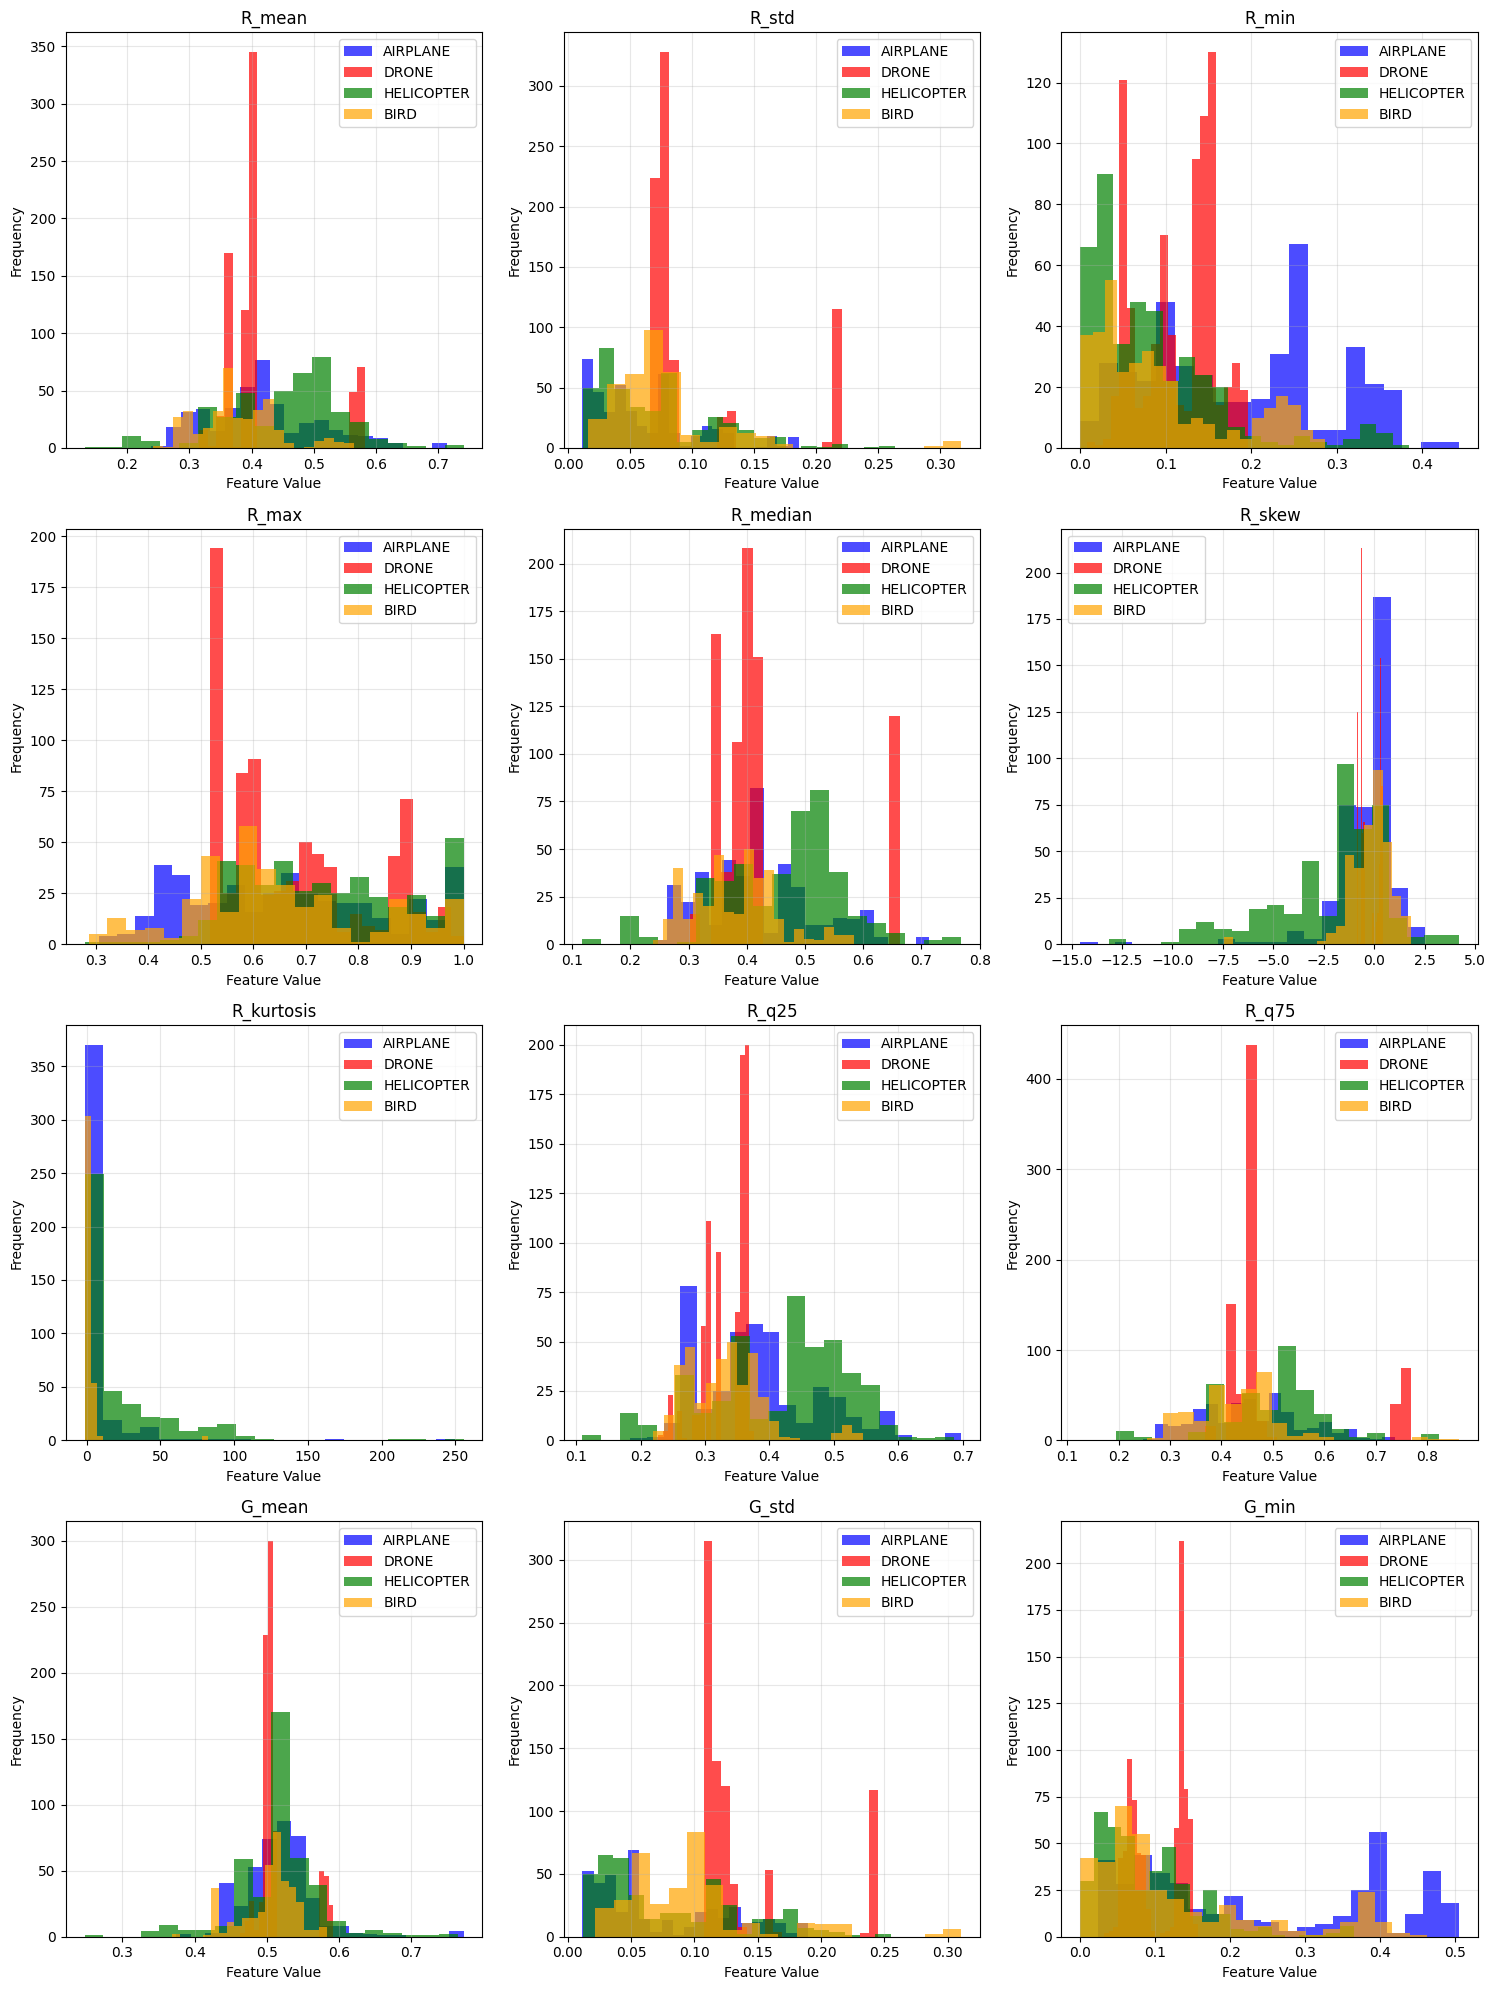

Dimensionality Reduction Analysis - Random Forest


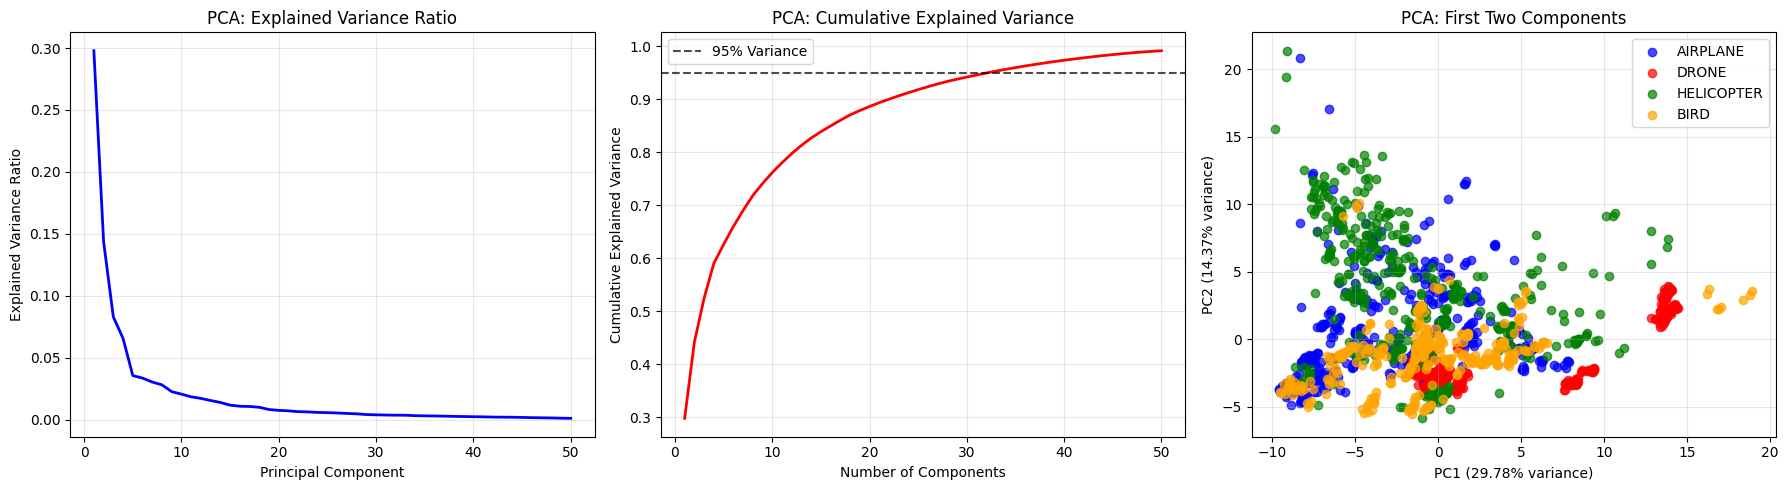

Components needed for 95% variance: 33


In [276]:
print("\n" + "="*80)
print("RandomForestClassfier Feature Analysis")
print("="*80)

# Visualize feature distributions
visualize_rf_feature_distributions(X_train_features, y_train_cls, feature_names)

# Perform dimensionality analysis
pca, n_components_95 = perform_rf_dimensionality_analysis(X_train_features, y_train_cls, feature_names)

## Feature Extraction for Convolutional Neural Networks (CNNs)

For images, this often means extracting things like:
 * Edges
 * Textures
 * Shapes
 * Keypoints

In [277]:
def visualize_cnn_feature_distributions(features_dict, y_labels=None):
    '''
    Visualize distribution of extracted features
    '''
    print("Visualizing feature distributions...")

    n_features = len(features_dict)
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()

    colors = ['blue', 'red', 'green', 'orange']

    for i, (feature_name, features) in enumerate(features_dict.items()):
        if i >= 6:  # Limit to 6 plots
            break

        ax = axes[i]

        # For high-dimensional features, show PCA
        if features.shape[1] > 50:
            # Apply PCA to reduce dimensionality
            pca = PCA(n_components=2)
            features_pca = pca.fit_transform(features)

            if y_labels is not None:
                # Plot by class
                for class_id in np.unique(y_labels):
                    mask = y_labels == class_id
                    ax.scatter(features_pca[mask, 0], features_pca[mask, 1],
                             c=colors[class_id], label=class_names[class_id], alpha=0.7)
                ax.legend()
                ax.set_title(f'{feature_name} Features (PCA)')
            else:
                ax.scatter(features_pca[:, 0], features_pca[:, 1], alpha=0.7)
                ax.set_title(f'{feature_name} Features (PCA)')

            ax.set_xlabel('PC1')
            ax.set_ylabel('PC2')

        else:
            # For low-dimensional features, show histogram
            if y_labels is not None:
                # Plot histogram by class
                for class_id in np.unique(y_labels):
                    mask = y_labels == class_id
                    if np.sum(mask) > 0:
                        ax.hist(features[mask, 0], bins=20, alpha=0.7,
                               color=colors[class_id], label=class_names[class_id])
                ax.legend()
            else:
                ax.hist(features[:, 0], bins=20, alpha=0.7)

            ax.set_title(f'{feature_name} Features (First Dimension)')
            ax.set_xlabel('Feature Value')
            ax.set_ylabel('Frequency')

        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig("images/cnn_features_distribution.png")
    plt.show()

In [278]:
def extract_cnn_features(X, y_labels=None):
    '''
    Extract traditional image features
    '''
    print("="*60)
    print("TRADITIONAL FEATURE EXTRACTION")
    print("="*60)

    features_dict = {}

    # Select subset for feature extraction (to avoid memory issues)
    subset_size = min(100, len(X))
    subset_indices = np.random.choice(len(X), subset_size, replace=False)
    X_subset = X[subset_indices]
    y_subset = y_labels[subset_indices] if y_labels is not None else None

    print(f"Extracting features from {subset_size} images...")

    # 1. HOG (Histogram of Oriented Gradients) Features
    print("Extracting HOG features...")
    hog_features = []
    for i, img in enumerate(X_subset):
        gray = rgb2gray(img)
        hog_feat = hog(gray, orientations=9, pixels_per_cell=(8, 8),
                      cells_per_block=(2, 2), visualize=False)
        hog_features.append(hog_feat)

    hog_features = np.array(hog_features)
    features_dict['HOG'] = hog_features
    print(f"HOG features shape: {hog_features.shape}")

    # 2. LBP (Local Binary Pattern) Features
    print("Extracting LBP features...")
    lbp_features = []
    for i, img in enumerate(X_subset):
        gray = rgb2gray(img)
        gray_uint8 = img_as_ubyte(gray)
        lbp = local_binary_pattern(gray_uint8, P=8, R=1, method='uniform')
        hist, _ = np.histogram(lbp.ravel(), bins=10, density=True)
        lbp_features.append(hist)

    lbp_features = np.array(lbp_features)
    features_dict['LBP'] = lbp_features
    print(f"LBP features shape: {lbp_features.shape}")

    # 3. Color Histogram Features
    print("Extracting color histogram features...")
    color_features = []
    for i, img in enumerate(X_subset):
        # RGB histograms
        hist_r = np.histogram(img[:, :, 0], bins=32, range=(0, 1))[0]
        hist_g = np.histogram(img[:, :, 1], bins=32, range=(0, 1))[0]
        hist_b = np.histogram(img[:, :, 2], bins=32, range=(0, 1))[0]

        # Normalize histograms
        hist_r = hist_r / np.sum(hist_r)
        hist_g = hist_g / np.sum(hist_g)
        hist_b = hist_b / np.sum(hist_b)

        color_feat = np.concatenate([hist_r, hist_g, hist_b])
        color_features.append(color_feat)

    color_features = np.array(color_features)
    features_dict['Color_Histogram'] = color_features
    print(f"Color histogram features shape: {color_features.shape}")

    # 4. Statistical Features
    print("Extracting statistical features...")
    statistical_features = []
    for i, img in enumerate(X_subset):
        # Calculate various statistics
        stats = []

        # Per-channel statistics
        for ch in range(3):
            channel = img[:, :, ch]
            stats.extend([
                np.mean(channel),
                np.std(channel),
                np.min(channel),
                np.max(channel),
                np.median(channel),
                scipy_stats.skew(channel.flatten()),
                scipy_stats.kurtosis(channel.flatten())
            ])

        # Overall image statistics
        gray = rgb2gray(img)

        # Calculate entropy using histogram
        hist, _ = np.histogram(gray.flatten(), bins=256, density=True)
        # Remove zeros to avoid log(0) issues
        hist = hist[hist > 0]
        entropy_val = -np.sum(hist * np.log2(hist + 1e-10))

        # Safe edge density calculation
        edge_density = np.sum(sobel_filter_edge_detection(gray))

        stats.extend([
            np.mean(gray),
            np.std(gray),
            entropy_val,
            edge_density
        ])

        statistical_features.append(stats)

    statistical_features = np.array(statistical_features)
    features_dict['Statistical'] = statistical_features
    print(f"Statistical features shape: {statistical_features.shape}")

    # 5. Texture Features (Alternative implementation without GLCM)
    print("Extracting texture features...")
    texture_features = []
    for i, img in enumerate(X_subset):
        gray = rgb2gray(img)

        # Alternative texture measures without GLCM
        # 1. Standard deviation (simple texture measure)
        texture_std = np.std(gray)

        # 2. Gradient-based texture measures
        grad_x = np.gradient(gray, axis=1)
        grad_y = np.gradient(gray, axis=0)
        gradient_magnitude = np.sqrt(grad_x**2 + grad_y**2)

        # 3. Local variance (texture complexity)
        kernel_size = 5
        h, w = gray.shape
        local_vars = []
        for row in range(0, h-kernel_size+1, kernel_size//2):
            for col in range(0, w-kernel_size+1, kernel_size//2):
                patch = gray[row:row+kernel_size, col:col+kernel_size]
                if patch.size > 0:
                    local_vars.append(np.var(patch))

        local_var_mean = np.mean(local_vars) if local_vars else 0

        # 4. Edge density using Sobel filter
        try:
            edge_density = np.sum(filters.sobel(gray))
        except:
            # Fallback edge detection
            edge_density = np.sum(np.abs(grad_x)) + np.sum(np.abs(grad_y))

        # Combine texture features
        texture_feat = [
            texture_std,
            np.mean(gradient_magnitude),
            local_var_mean,
            edge_density / (gray.shape[0] * gray.shape[1])  # Normalize by image size
        ]

        texture_features.append(texture_feat)

    texture_features = np.array(texture_features)
    features_dict['Texture'] = texture_features
    print(f"Texture features shape: {texture_features.shape}")

    # Visualize feature distributions
    visualize_cnn_feature_distributions(features_dict, y_subset)

    return features_dict

TRADITIONAL FEATURE EXTRACTION
Extracting features from 100 images...
Extracting HOG features...
HOG features shape: (100, 26244)
Extracting LBP features...
LBP features shape: (100, 10)
Extracting color histogram features...
Color histogram features shape: (100, 96)
Extracting statistical features...
Statistical features shape: (100, 25)
Extracting texture features...
Texture features shape: (100, 4)
Visualizing feature distributions...


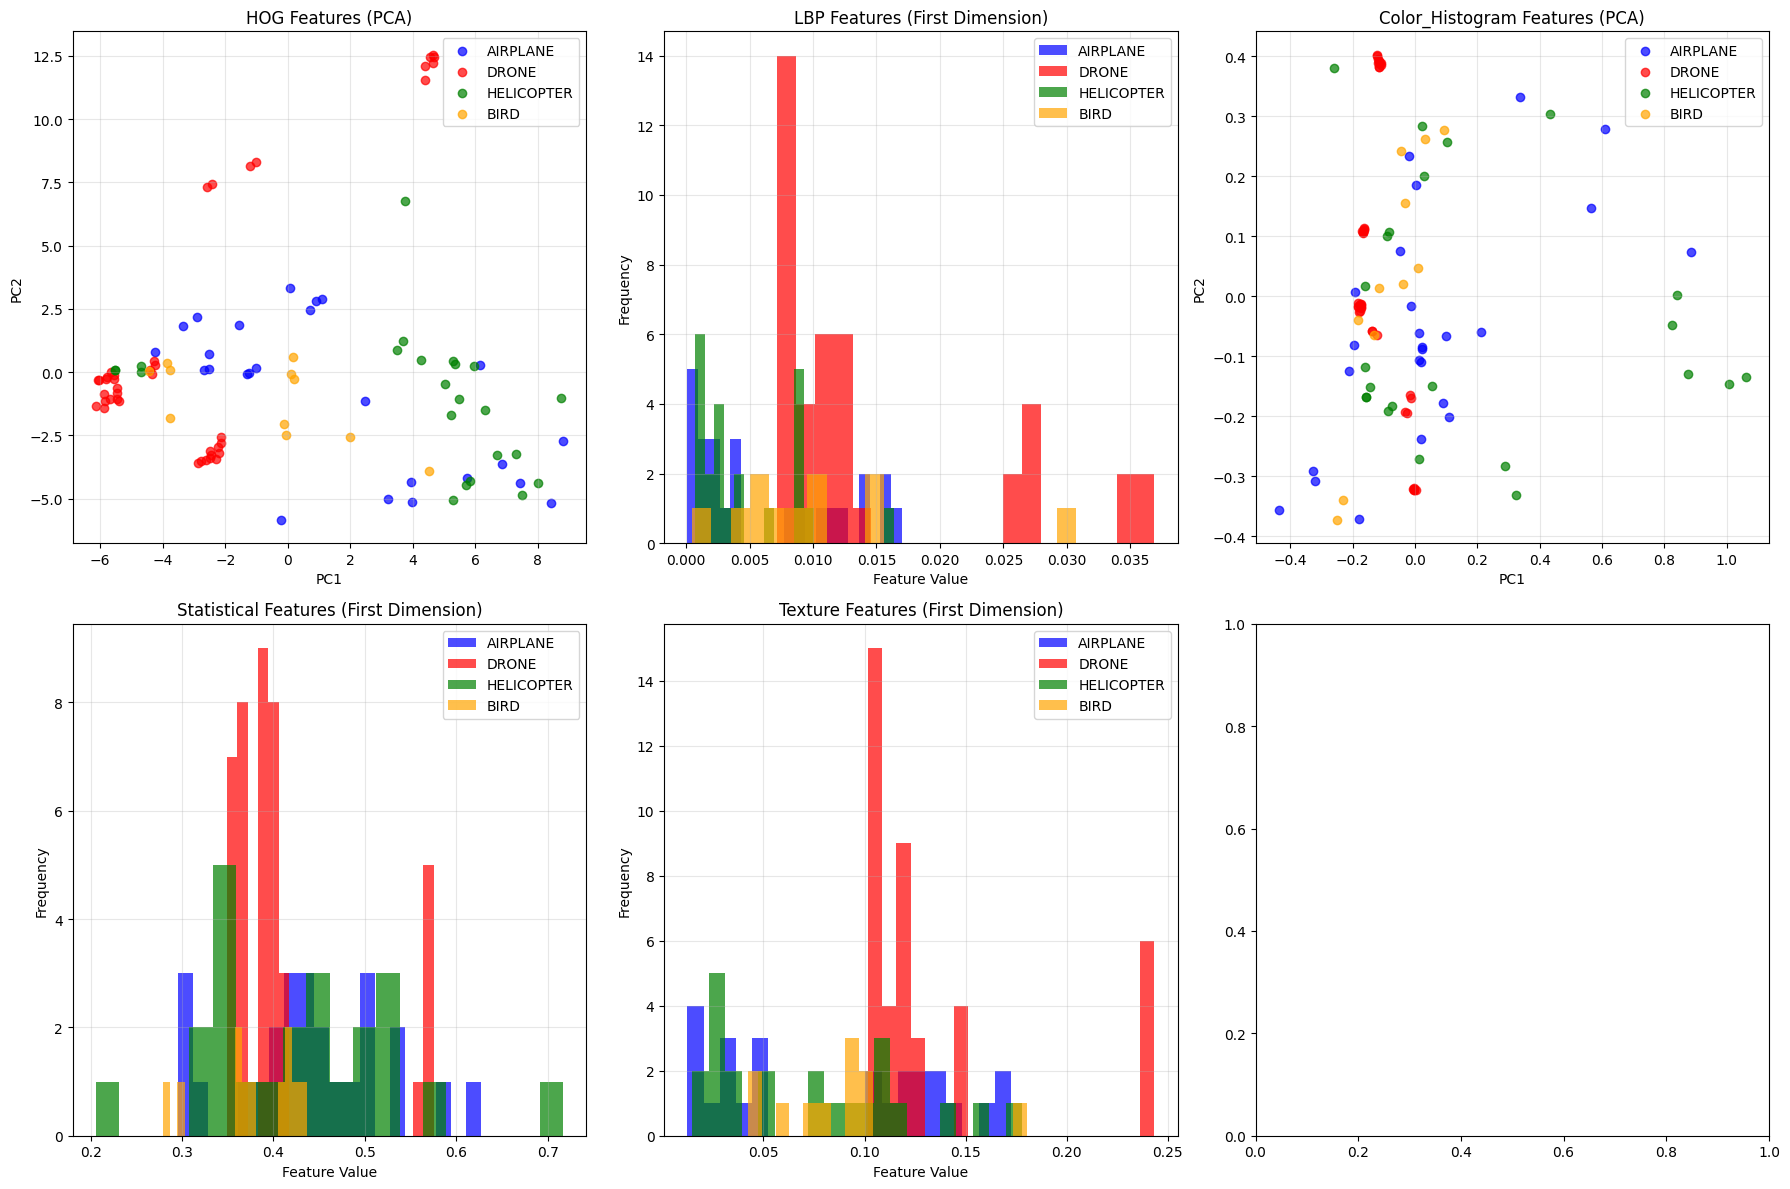

In [279]:
# Extract traditional features
traditional_features = extract_cnn_features(X_train_cls, y_train_cls)

# Model Training

## Random Forest Classifier

In [280]:
def visualize_grid_search_results(results_df, param_grid):
    '''
    Visualize GridSearchCV results to understand parameter importance
    '''
    print("\nVisualizing GridSearchCV Results...")

    # Select parameters with multiple values for visualization
    params_to_plot = []
    for param, values in param_grid.items():
        if len(values) > 1:
            params_to_plot.append(param)

    # Limit to 6 most interesting parameters for visualization
    params_to_plot = params_to_plot[:6]

    if len(params_to_plot) == 0:
        print("No parameters with multiple values to visualize")
        return

    # Create subplots
    n_params = len(params_to_plot)
    cols = min(3, n_params)
    rows = (n_params + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 4*rows))
    if rows == 1:
        axes = axes.reshape(1, -1) if n_params > 1 else [axes]
    elif cols == 1:
        axes = axes.reshape(-1, 1)

    for i, param in enumerate(params_to_plot):
        row = i // cols
        col = i % cols
        ax = axes[row, col] if rows > 1 else axes[col]

        # Group by parameter value and calculate mean score
        param_scores = []
        param_values = []

        for value in param_grid[param]:
            mask = results_df['param_' + param] == value
            if mask.any():
                scores = results_df.loc[mask, 'mean_test_score']
                param_scores.append(scores.mean())
                param_values.append(str(value))

        if param_scores:
            # Create bar plot
            bars = ax.bar(range(len(param_values)), param_scores, alpha=0.7)
            ax.set_xlabel(param)
            ax.set_ylabel('Mean CV Score')
            ax.set_title(f'Effect of {param}')
            ax.set_xticks(range(len(param_values)))
            ax.set_xticklabels(param_values, rotation=45, ha='right')

            # Add value labels on bars
            for j, (bar, score) in enumerate(zip(bars, param_scores)):
                ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
                       f'{score:.3f}', ha='center', va='bottom', fontsize=8)

            ax.grid(True, alpha=0.3)

    # Hide unused subplots
    for i in range(n_params, rows * cols):
        row = i // cols
        col = i % cols
        ax = axes[row, col] if rows > 1 else axes[col]
        ax.axis('off')

    plt.tight_layout()
    plt.show()

In [281]:
def record_performance_metrics(dataset_type, model, X_scaled, y_true, model_name='rf'):
    '''
    Record performance metrics for models
    '''
    # Evaluate on data set
    y_pred = model.predict(X_scaled)

    if model_name == 'cnn' or model_name == 'cnn-d':
      print("Recording Performance Metrics for CNN:")
      if y_true.ndim > 1:
        y_true = np.argmax(y_true, axis=1)
      if y_pred.ndim > 1:
        y_pred = np.argmax(y_pred, axis=1)
    else:
      print("Recording Performance Metrics for RandomForest:")

    if model_name == 'cnn-d':
      accuracy = np.mean(y_true == y_pred)
    else:
      accuracy = accuracy_score(y_true, y_pred)

    mse = mse_loss(y_true, y_pred)
    mae = mae_loss(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

    if dataset_type == 'train':
      mse_train_models.append(mse)
      acc_train_models.append(accuracy)
      mae_train_models.append(mae)
      precision_train_models.append(precision)
      recall_train_models.append(recall)
      f1_train_models.append(f1)
      print(f"\nTraining Accuracy: {accuracy:.4f}")
      print(f"Training MSE: {mse:.4f}")
      print(f"Training MAE: {mae:.4f}")
      print(f"Training Precision: {precision:.4f}")
      print(f"Training Recall: {recall:.4f}")
      print(f"Training F1 Score: {f1:.4f}")
    elif dataset_type == 'valid':
      mse_val_models.append(mse)
      acc_val_models.append(accuracy)
      mae_val_models.append(mae)
      precision_val_models.append(precision)
      recall_val_models.append(recall)
      f1_val_models.append(f1)
      print(f"\nValidation Accuracy: {accuracy:.4f}")
      print(f"Validation MSE: {mse:.4f}")
      print(f"Validation MAE: {mae:.4f}")
      print(f"Validation Precision: {precision:.4f}")
      print(f"Validation Recall: {recall:.4f}")
      print(f"Validation F1 Score: {f1:.4f}")
    elif dataset_type == 'test':
      mse_test_models.append(mse)
      acc_test_models.append(accuracy)
      mae_test_models.append(mae)
      precision_test_models.append(precision)
      recall_test_models.append(recall)
      f1_test_models.append(f1)
      print(f"\Test Accuracy: {accuracy:.4f}")
      print(f"Test MSE: {mse:.4f}")
      print(f"Test MAE: {mae:.4f}")
      print(f"Test Precision: {precision:.4f}")
      print(f"Test Recall: {recall:.4f}")
      print(f"Test F1 Score: {f1:.4f}")
    else:
        raise ValueError("Invalid dataset_type. Must be 'train', 'val', or 'test'.")

    return accuracy

In [282]:
def train_baseline_random_forest(X_train_features, y_train, feature_names, X_val_features=None, y_val=None):
    '''
    Train baseline Random Forest model for comparison with GridSearchCV
    '''
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_features)

    if X_val_features is not None:
        X_val_scaled = scaler.transform(X_val_features)
    else:
        # Create validation split if not provided
        X_train_scaled, X_val_scaled, y_train, y_val = train_test_split(
            X_train_scaled, y_train, test_size=0.2, random_state=42, stratify=y_train
        )

    print(f"Training samples: {len(X_train_scaled)}")
    print(f"Validation samples: {len(X_val_scaled)}")
    print(f"Feature dimension: {X_train_scaled.shape[1]}")

    # Baseline parameters
    baseline_params = {
        'n_estimators': 100,
        'max_depth': None,
        'min_samples_split': 2,
        'min_samples_leaf': 1,
        'max_features': 'sqrt',
        'class_weight': 'balanced',
        'bootstrap': True
    }

    print("Baseline Parameters:")
    for param, value in baseline_params.items():
        print(f"  {param}: {value}")

    # Train baseline Random Forest
    baseline_rf = RandomForestClassifier(
        random_state=42,
        n_jobs=-1,
        **baseline_params
    )

    baseline_rf.fit(X_train_scaled, y_train)

    # Evaluate on train set
    train_accuracy = record_performance_metrics('train', baseline_rf, X_train_scaled, y_train)

    # Evaluate on validation set
    valid_accuracy = record_performance_metrics('valid', baseline_rf, X_val_scaled, y_val)


    return baseline_rf, scaler, train_accuracy, valid_accuracy, baseline_params

In [283]:
%%time
print("\n" + "="*80)
print("Training Baseline RandomForest")

# Train baseline model for comparison
rf_base_start_time = time.time()
try:
    baseline_rf, baseline_scaler, train_accuracy, baseline_accuracy, baseline_params = train_baseline_random_forest(
        X_train_features, y_train_cls, feature_names, X_val_features, y_val_cls
    )

    print(f"Baseline Random Forest Training Accuracy: {train_accuracy:.4f}")
    print(f"Baseline Random Forest Validation Accuracy: {baseline_accuracy:.4f}")

except Exception as e:
    print(f"Error during baseline Random Forest training: {e}")
    import traceback
    traceback.print_exc()
rf_base_end_time = time.time()
model_training_time.append(rf_base_end_time - rf_base_start_time)


Training Baseline RandomForest
Training samples: 2000
Validation samples: 400
Feature dimension: 96
Baseline Parameters:
  n_estimators: 100
  max_depth: None
  min_samples_split: 2
  min_samples_leaf: 1
  max_features: sqrt
  class_weight: balanced
  bootstrap: True
Recording Performance Metrics for RandomForest:

Training Accuracy: 1.0000
Training MSE: 0.0000
Training MAE: 0.0000
Training Precision: 1.0000
Training Recall: 1.0000
Training F1 Score: 1.0000
Recording Performance Metrics for RandomForest:

Validation Accuracy: 0.9775
Validation MSE: 0.0875
Validation MAE: 0.0213
Validation Precision: 0.9780
Validation Recall: 0.9775
Validation F1 Score: 0.9776
Baseline Random Forest Training Accuracy: 1.0000
Baseline Random Forest Validation Accuracy: 0.9775
CPU times: user 1.58 s, sys: 48.5 ms, total: 1.63 s
Wall time: 355 ms


In [284]:
def perform_grid_search(X_train_features, y_train, feature_names, cv_folds=3, n_jobs=-1):
    '''
    Perform comprehensive GridSearchCV for Random Forest hyperparameter tuning
    '''
    # Scale features for grid search
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_features)
    # X_val_scaled = scaler.fit_transform(X_val_features)

    print(f"Training samples: {len(X_train_scaled)}")
    print(f"Feature dimension: {X_train_scaled.shape[1]}")
    print(f"Classes distribution: {Counter(y_train)}")
    print(f"Cross-validation folds: {cv_folds}")

    # Define comprehensive parameter grid
    param_grid = {
        # Number of trees
        'n_estimators': [100, 200, 300],

        # Maximum depth of trees
        'max_depth': [10, 15, 20, None],

        # Minimum samples required to split a node
        'min_samples_split': [2, 5, 10],

        # Minimum samples required at a leaf node
        'min_samples_leaf': [1, 2, 4],

        # Number of features to consider for best split
        'max_features': ['sqrt', 'log2', None],

        # Class weight strategy
        'class_weight': ['balanced', None],

        # Bootstrap sampling
        'bootstrap': [True, False]
    }

    # Calculate total combinations
    total_combinations = 1
    for param, values in param_grid.items():
        total_combinations *= len(values)

    print(f"Total parameter combinations: {total_combinations}")
    print(f"Total CV fits: {total_combinations * cv_folds}")
    print("This may take several minutes to complete...")

    # Create Random Forest classifier
    rf = RandomForestClassifier(random_state=42, n_jobs=1)  # Set n_jobs=1 for GridSearch to control parallelism

    # Create stratified cross-validation
    cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)

    # Create GridSearchCV
    grid_search = GridSearchCV(
        estimator=rf,
        param_grid=param_grid,
        cv=cv,
        scoring='accuracy',
        n_jobs=n_jobs,
        verbose=1,
        return_train_score=True
    )

    # Perform grid search
    grid_search.fit(X_train_scaled, y_train)

    # Extract results
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    best_estimator = grid_search.best_estimator_

    # # Evaluate on train set
    # train_accuracy = record_performance_metrics('train', best_estimator, X_train_scaled, y_train)

    # # Evaluate on validation set
    # valid_accuracy = record_performance_metrics('valid', best_estimator, X_val_scaled, y_val)

    print(f"\nBest Cross-Validation Score: {best_score:.4f}")
    print("\nBest Parameters:")
    for param, value in best_params.items():
        print(f"  {param}: {value}")

    # Analyze grid search results
    results_df = pd.DataFrame(grid_search.cv_results_)

    # Top 10 parameter combinations
    top_10_results = results_df.nlargest(10, 'mean_test_score')[
        ['mean_test_score', 'std_test_score', 'params']
    ]

    print("\nTop 10 Parameter Combinations:")
    for i, (idx, row) in enumerate(top_10_results.iterrows()):
        print(f"\n{i+1:2d}. Score: {row['mean_test_score']:.4f} (±{row['std_test_score']:.4f})")
        for param, value in row['params'].items():
            print(f"    {param}: {value}")

    # Visualize parameter importance
    visualize_grid_search_results(results_df, param_grid)

    return grid_search, scaler, best_params, best_score, results_df


RandomForest + GridSearch Hyperparameter Optimization
Training samples: 2000
Feature dimension: 96
Classes distribution: Counter({np.int64(1): 802, np.int64(2): 417, np.int64(0): 416, np.int64(3): 365})
Cross-validation folds: 3
Total parameter combinations: 1296
Total CV fits: 3888
This may take several minutes to complete...
Fitting 3 folds for each of 1296 candidates, totalling 3888 fits

Best Cross-Validation Score: 0.9795

Best Parameters:
  bootstrap: False
  class_weight: balanced
  max_depth: 15
  max_features: log2
  min_samples_leaf: 1
  min_samples_split: 2
  n_estimators: 100

Top 10 Parameter Combinations:

 1. Score: 0.9795 (±0.0057)
    bootstrap: False
    class_weight: balanced
    max_depth: 15
    max_features: log2
    min_samples_leaf: 1
    min_samples_split: 2
    n_estimators: 100

 2. Score: 0.9790 (±0.0054)
    bootstrap: False
    class_weight: None
    max_depth: 20
    max_features: log2
    min_samples_leaf: 1
    min_samples_split: 2
    n_estimators: 10

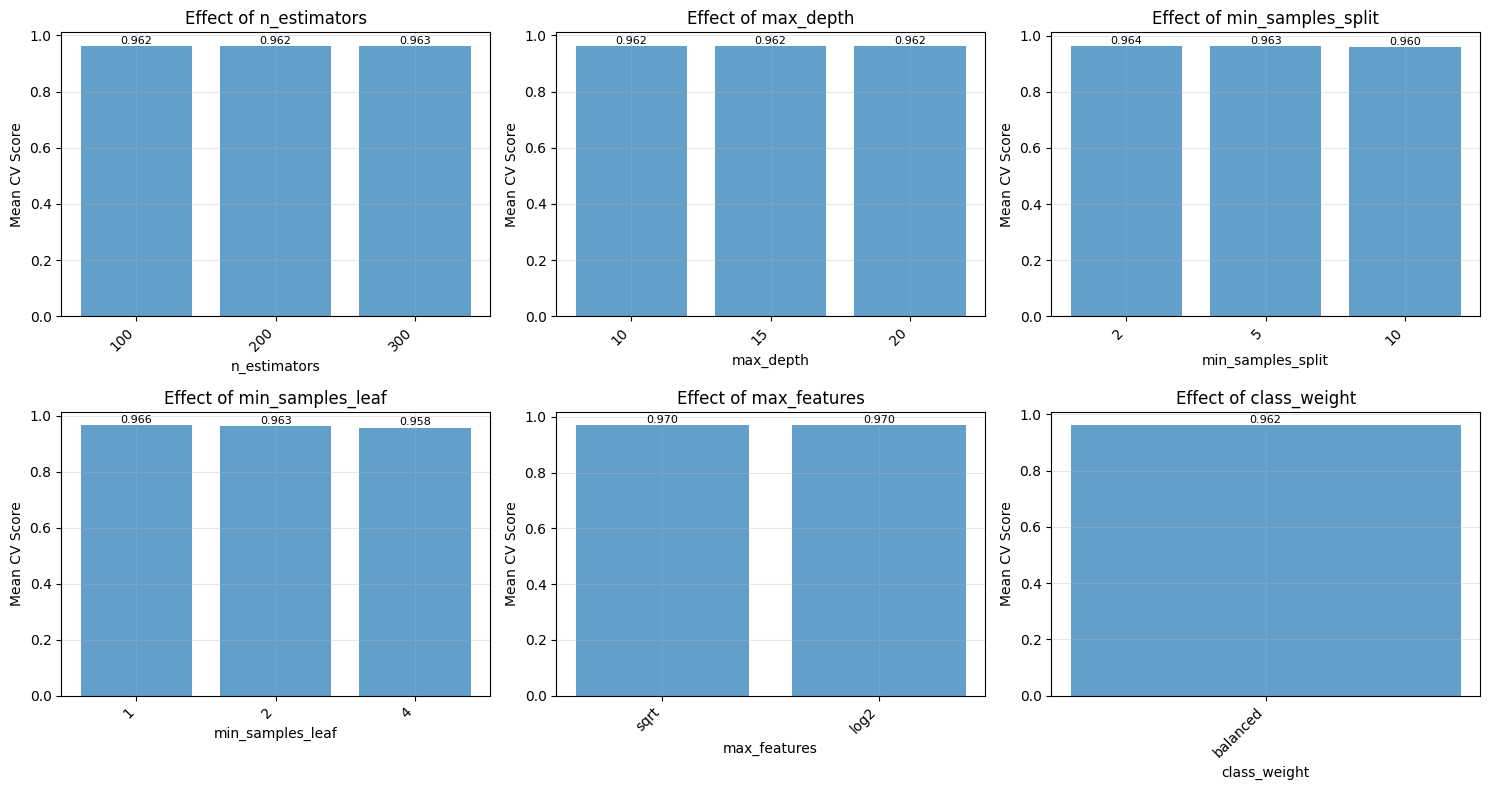

GridSearchCV Best Cross-Validation Score: 0.9795
CPU times: user 7min 18s, sys: 6.42 s, total: 7min 24s
Wall time: 49min 8s


In [285]:
%%time
print("\n" + "="*80)
print("RandomForest + GridSearch Hyperparameter Optimization")
print("="*80)

# Perform GridSearchCV
rf_grid_start_time = time.time()
try:
    if run_grid_search:
      grid_search, grid_scaler, best_params, best_score, results_df = perform_grid_search(
          X_train_features, y_train_cls, feature_names, cv_folds=3, n_jobs=-1
      )

      print(f"GridSearchCV Best Cross-Validation Score: {best_score:.4f}")
except Exception as e:
    print(f"Error during GridSearchCV: {e}")
    import traceback
    traceback.print_exc()
rf_grid_end_time = time.time()

In [286]:
def train_optimized_random_forest_model(X_train_features, y_train, best_params, feature_names,
                                       X_val_features=None, y_val=None, scaler=None):
    '''
    Train Random Forest model with optimized hyperparameters
    '''
    # Use provided scaler or create new one
    if scaler is None:
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_features)
    else:
        X_train_scaled = scaler.transform(X_train_features)

    if X_val_features is not None:
        X_val_scaled = scaler.transform(X_val_features)
    else:
        # Create validation split if not provided
        X_train_scaled, X_val_scaled, y_train, y_val = train_test_split(
            X_train_scaled, y_train, test_size=0.2, random_state=42, stratify=y_train
        )

    print(f"Training samples: {len(X_train_scaled)}")
    print(f"Validation samples: {len(X_val_scaled)}")
    print(f"Feature dimension: {X_train_scaled.shape[1]}")
    print(f"Classes distribution in training: {Counter(y_train)}")

    print("\nOptimized Parameters:")
    for param, value in best_params.items():
        print(f"  {param}: {value}")

    # Train Random Forest with optimized parameters
    rf_model = RandomForestClassifier(
        random_state=42,
        n_jobs=-1,
        **best_params
    )

    rf_model.fit(X_train_scaled, y_train)

    # Evaluate on validation set
    y_val_pred = rf_model.predict(X_val_scaled)

    # Evaluate on train set
    train_accuracy = record_performance_metrics('train', rf_model, X_train_scaled, y_train)

    # Evaluate on validation set
    valid_accuracy = record_performance_metrics('valid', rf_model, X_val_scaled, y_val)

    # Print classification report
    print("\nValidation Classification Report:")
    print(classification_report(y_val, y_val_pred, target_names=class_names))

    # Feature importance analysis
    feature_importance = rf_model.feature_importances_

    # Get top 20 most important features
    top_indices = np.argsort(feature_importance)[-20:]
    top_features = [feature_names[i] for i in top_indices]
    top_importance = feature_importance[top_indices]

    print("\nTop 20 Most Important Features:")
    for feat, imp in zip(reversed(top_features), reversed(top_importance)):
        print(f"  {feat}: {imp:.4f}")

    # Visualize feature importance
    plt.figure(figsize=(12, 8))
    plt.barh(range(len(top_features)), top_importance)
    plt.yticks(range(len(top_features)), top_features)
    plt.xlabel('Feature Importance')
    plt.title('Top 20 Feature Importance (Optimized Random Forest)')
    plt.tight_layout()
    plt.savefig("images/opti_rf_features_distribution.png")
    plt.show()

    # Confusion matrix
    cm = confusion_matrix(y_val, y_val_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Validation Confusion Matrix (Optimized Model)')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    return rf_model, scaler, train_accuracy, valid_accuracy, feature_importance


Training Optimized RandomForest
Training samples: 2000
Validation samples: 400
Feature dimension: 96
Classes distribution in training: Counter({np.int64(1): 802, np.int64(2): 417, np.int64(0): 416, np.int64(3): 365})

Optimized Parameters:
  bootstrap: False
  class_weight: balanced
  max_depth: 15
  max_features: log2
  min_samples_leaf: 1
  min_samples_split: 2
  n_estimators: 100
Recording Performance Metrics for RandomForest:

Training Accuracy: 1.0000
Training MSE: 0.0000
Training MAE: 0.0142
Training Precision: 1.0000
Training Recall: 1.0000
Training F1 Score: 1.0000
Recording Performance Metrics for RandomForest:

Validation Accuracy: 0.9800
Validation MSE: 0.0650
Validation MAE: 0.0194
Validation Precision: 0.9803
Validation Recall: 0.9800
Validation F1 Score: 0.9800

Validation Classification Report:
              precision    recall  f1-score   support

    AIRPLANE       0.98      0.96      0.97        85
       DRONE       0.99      1.00      1.00       144
  HELICOPTER   

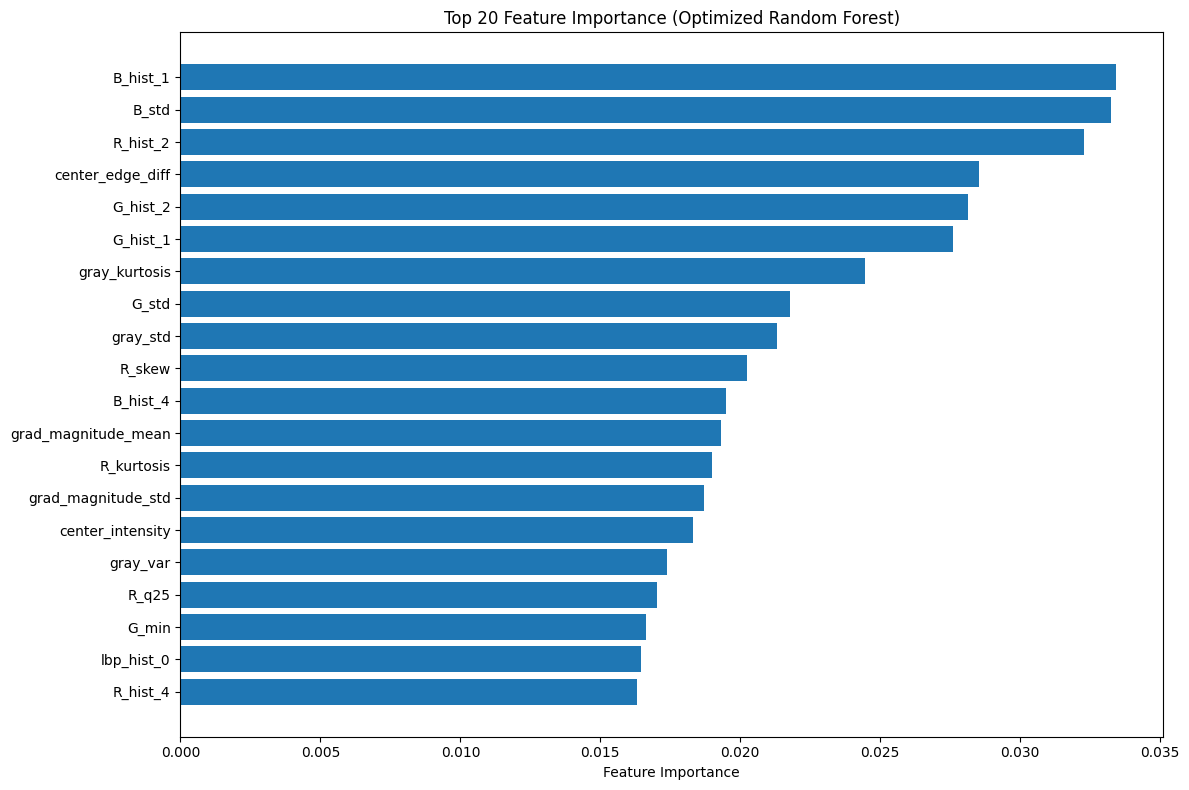

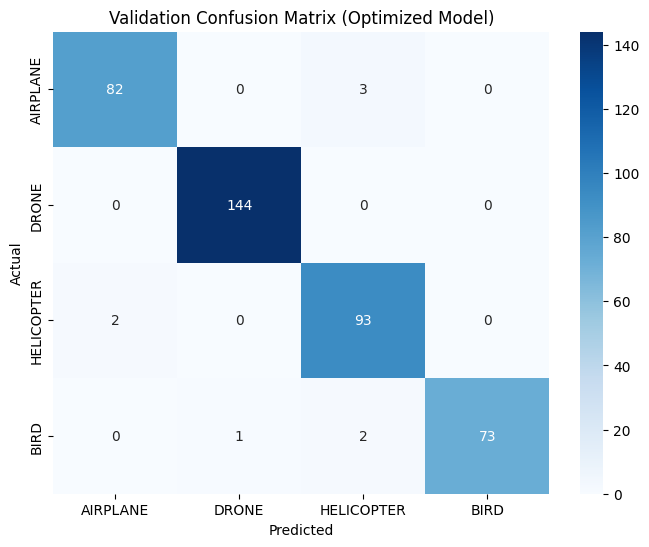

Optimized Random Forest Training Accuracy: 1.0000
Optimized Random Forest Validation Accuracy: 0.9800
CPU times: user 2.41 s, sys: 76.6 ms, total: 2.49 s
Wall time: 1.14 s


In [287]:
%%time
print("\n" + "="*80)
print("Training Optimized RandomForest")
print("="*80)

# Train optimized model with best parameters
rf_opti_start_time = time.time()
try:
    optimized_rf, optimized_scaler, optimized_train_accuracy, optimized_valid_accuracy, feature_importance = train_optimized_random_forest_model(
        X_train_features, y_train_cls, best_params, feature_names, X_val_features, y_val_cls, grid_scaler
    )

    # print(f"Optimized Random Forest Validation Accuracy: {optimized_accuracy:.4f}")
    print(f"Optimized Random Forest Training Accuracy: {optimized_train_accuracy:.4f}")
    print(f"Optimized Random Forest Validation Accuracy: {optimized_valid_accuracy:.4f}")

except Exception as e:
    print(f"Error during optimized Random Forest training: {e}")
    import traceback
    traceback.print_exc()
rf_opti_end_time = time.time()

model_training_time.append(rf_opti_end_time - rf_opti_start_time)

## RandomForest Model Comparision

In [288]:
def compare_baseline_vs_optimized(baseline_accuracy, optimized_accuracy, baseline_params, best_params):
    '''
    Compare baseline Random Forest vs GridSearchCV optimized model
    '''
    improvement = optimized_accuracy - baseline_accuracy
    improvement_pct = (improvement / baseline_accuracy) * 100

    print(f"Baseline Model Accuracy: {baseline_accuracy:.4f}")
    print(f"Optimized Model Accuracy: {optimized_accuracy:.4f}")
    print(f"Improvement: {improvement:.4f} ({improvement_pct:+.2f}%)")

    if improvement > 0:
        print("✅ GridSearchCV improved model performance!")
    elif improvement == 0:
        print("➡️ GridSearchCV maintained baseline performance")
    else:
        print("⚠️ GridSearchCV resulted in lower performance (possible overfitting)")

    print("\nParameter Comparison:")
    print("Baseline Parameters:")
    for param, value in baseline_params.items():
        print(f"  {param}: {value}")

    print("\nOptimized Parameters:")
    for param, value in best_params.items():
        print(f"  {param}: {value}")

    # Visualize comparison
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Accuracy comparison
    models = ['Baseline', 'Optimized']
    accuracies = [baseline_accuracy, optimized_accuracy]
    colors = ['lightcoral', 'lightgreen']

    bars = ax1.bar(models, accuracies, color=colors, alpha=0.7)
    ax1.set_ylabel('Accuracy')
    ax1.set_title('Model Performance Comparison')
    ax1.set_ylim([min(accuracies) - 0.05, max(accuracies) + 0.05])

    # Add value labels on bars
    for bar, acc in zip(bars, accuracies):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
                f'{acc:.4f}', ha='center', va='bottom', fontweight='bold')

    ax1.grid(True, alpha=0.3, axis='y')

    # Improvement visualization
    if improvement != 0:
        ax2.bar(['Improvement'], [improvement_pct],
                color='green' if improvement > 0 else 'red', alpha=0.7)
        ax2.set_ylabel('Improvement (%)')
        ax2.set_title('Performance Improvement')
        ax2.axhline(y=0, color='black', linestyle='-', alpha=0.5)
        ax2.text(0, improvement_pct + (0.1 if improvement_pct > 0 else -0.1),
                f'{improvement_pct:+.2f}%', ha='center', va='bottom' if improvement_pct > 0 else 'top',
                fontweight='bold')
        ax2.grid(True, alpha=0.3, axis='y')
    else:
        ax2.text(0.5, 0.5, 'No Change', ha='center', va='center',
                fontsize=16, fontweight='bold', transform=ax2.transAxes)
        ax2.set_xlim([0, 1])
        ax2.set_ylim([0, 1])
        ax2.axis('off')

    plt.tight_layout()
    plt.savefig("images/rf_baseline_vs_optimized_performance.png")
    plt.show()


Baseline Vs Optimized Model Comparision
Baseline Model Accuracy: 0.9775
Optimized Model Accuracy: 0.9800
Improvement: 0.0025 (+0.26%)
✅ GridSearchCV improved model performance!

Parameter Comparison:
Baseline Parameters:
  n_estimators: 100
  max_depth: None
  min_samples_split: 2
  min_samples_leaf: 1
  max_features: sqrt
  class_weight: balanced
  bootstrap: True

Optimized Parameters:
  bootstrap: False
  class_weight: balanced
  max_depth: 15
  max_features: log2
  min_samples_leaf: 1
  min_samples_split: 2
  n_estimators: 100


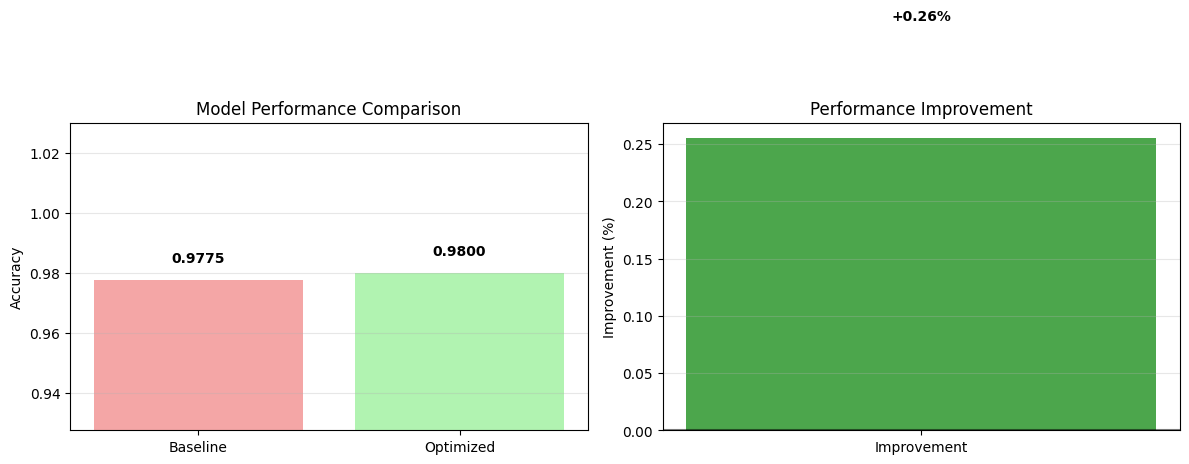

In [289]:
print("\n" + "="*80)
print("Baseline Vs Optimized Model Comparision")
print("="*80)

# Compare baseline vs optimized model
compare_baseline_vs_optimized(baseline_accuracy, optimized_valid_accuracy, baseline_params, best_params)

## RandomForest Model Evaluation

In [290]:
def evaluate_random_forest_model(model, scaler, X_test_features, y_test, feature_names):
    '''
    Evaluate Random Forest model on test set
    '''
    # Scale test features
    X_test_scaled = scaler.transform(X_test_features)

    # Make predictions
    y_test_pred = model.predict(X_test_scaled)
    y_test_proba = model.predict_proba(X_test_scaled)

    # Calculate accuracy
    # test_accuracy = accuracy_score(y_test, y_test_pred)
    # print(f"Test Accuracy: {test_accuracy:.4f}")

    # Evaluate on test set
    test_accuracy = record_performance_metrics('test', model, X_test_scaled, y_test)
    print(f"Test Accuracy: {test_accuracy:.4f}")

    # Classification report
    print("\nTest Classification Report:")
    print(classification_report(y_test, y_test_pred, target_names=class_names))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Test Confusion Matrix (Optimized Model)')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.savefig("images/rf_confusion_matrix.png")
    plt.show()

    # Per-class accuracy
    print("\nPer-class Accuracy:")
    for i, class_name in enumerate(class_names):
        class_mask = (y_test == i)
        if np.sum(class_mask) > 0:
            class_accuracy = accuracy_score(y_test[class_mask], y_test_pred[class_mask])
            print(f"  {class_name}: {class_accuracy:.4f} ({np.sum(class_mask)} samples)")

    return test_accuracy, y_test_pred, y_test_proba

In [291]:
def analyze_prediction_errors(X_test, y_test, y_pred, y_proba, num_samples=8):
    '''
    Analyze and visualize prediction errors
    '''
    print("="*60)
    print("Analyzing Prediction Errors")
    print("="*60)

    # Find misclassified samples
    misclassified_mask = (y_test != y_pred)
    misclassified_indices = np.where(misclassified_mask)[0]

    if len(misclassified_indices) == 0:
        print("No misclassifications found!")
        return

    print(f"Found {len(misclassified_indices)} misclassified samples out of {len(y_test)}")

    # Select random misclassified samples for visualization
    sample_indices = np.random.choice(misclassified_indices,
                                     min(num_samples, len(misclassified_indices)),
                                     replace=False)

    # Visualize misclassified samples
    rows = (num_samples + 3) // 4
    cols = min(4, num_samples)
    fig, axes = plt.subplots(rows, cols, figsize=(16, 4*rows))
    if rows == 1:
        axes = axes.reshape(1, -1)

    for i, idx in enumerate(sample_indices):
        row = i // cols
        col = i % cols

        # Display image
        axes[row, col].imshow(X_test[idx])
        axes[row, col].set_title(
            f'True: {class_names[y_test[idx]]}\n'
            f'Pred: {class_names[y_pred[idx]]}\n'
            f'Conf: {y_proba[idx, y_pred[idx]]:.3f}'
        )
        axes[row, col].axis('off')

    # Hide unused subplots
    for i in range(len(sample_indices), rows * cols):
        row = i // cols
        col = i % cols
        axes[row, col].axis('off')

    plt.suptitle('Misclassified Samples (Optimized Model)', fontsize=16)
    plt.tight_layout()
    plt.savefig("images/rf_prediction_errors_analysis.png")
    plt.show()

    # Analyze error patterns
    error_analysis = {}
    for true_class in range(NUM_CLASSES):
        for pred_class in range(NUM_CLASSES):
            if true_class != pred_class:
                mask = (y_test == true_class) & (y_pred == pred_class)
                count = np.sum(mask)
                if count > 0:
                    error_analysis[f'{class_names[true_class]} → {class_names[pred_class]}'] = count

    if error_analysis:
        print("\nMost Common Error Patterns:")
        sorted_errors = sorted(error_analysis.items(), key=lambda x: x[1], reverse=True)
        for pattern, count in sorted_errors[:5]:
            print(f"  {pattern}: {count} cases")


RandomForest Model Evaluation
Recording Performance Metrics for RandomForest:
\Test Accuracy: 0.9675
Test MSE: 0.1450
Test MAE: 0.0285
Test Precision: 0.9686
Test Recall: 0.9675
Test F1 Score: 0.9676
Test Accuracy: 0.9675

Test Classification Report:
              precision    recall  f1-score   support

    AIRPLANE       0.97      0.92      0.94        90
       DRONE       1.00      1.00      1.00       165
  HELICOPTER       0.89      0.97      0.93        70
        BIRD       0.97      0.95      0.96        75

    accuracy                           0.97       400
   macro avg       0.96      0.96      0.96       400
weighted avg       0.97      0.97      0.97       400



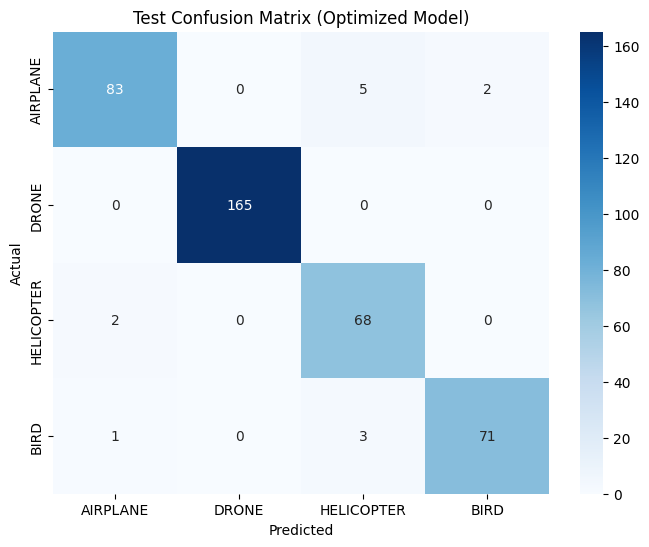


Per-class Accuracy:
  AIRPLANE: 0.9222 (90 samples)
  DRONE: 1.0000 (165 samples)
  HELICOPTER: 0.9714 (70 samples)
  BIRD: 0.9467 (75 samples)
Optimized Random Forest Test Accuracy: 0.9675
Analyzing Prediction Errors
Found 13 misclassified samples out of 400


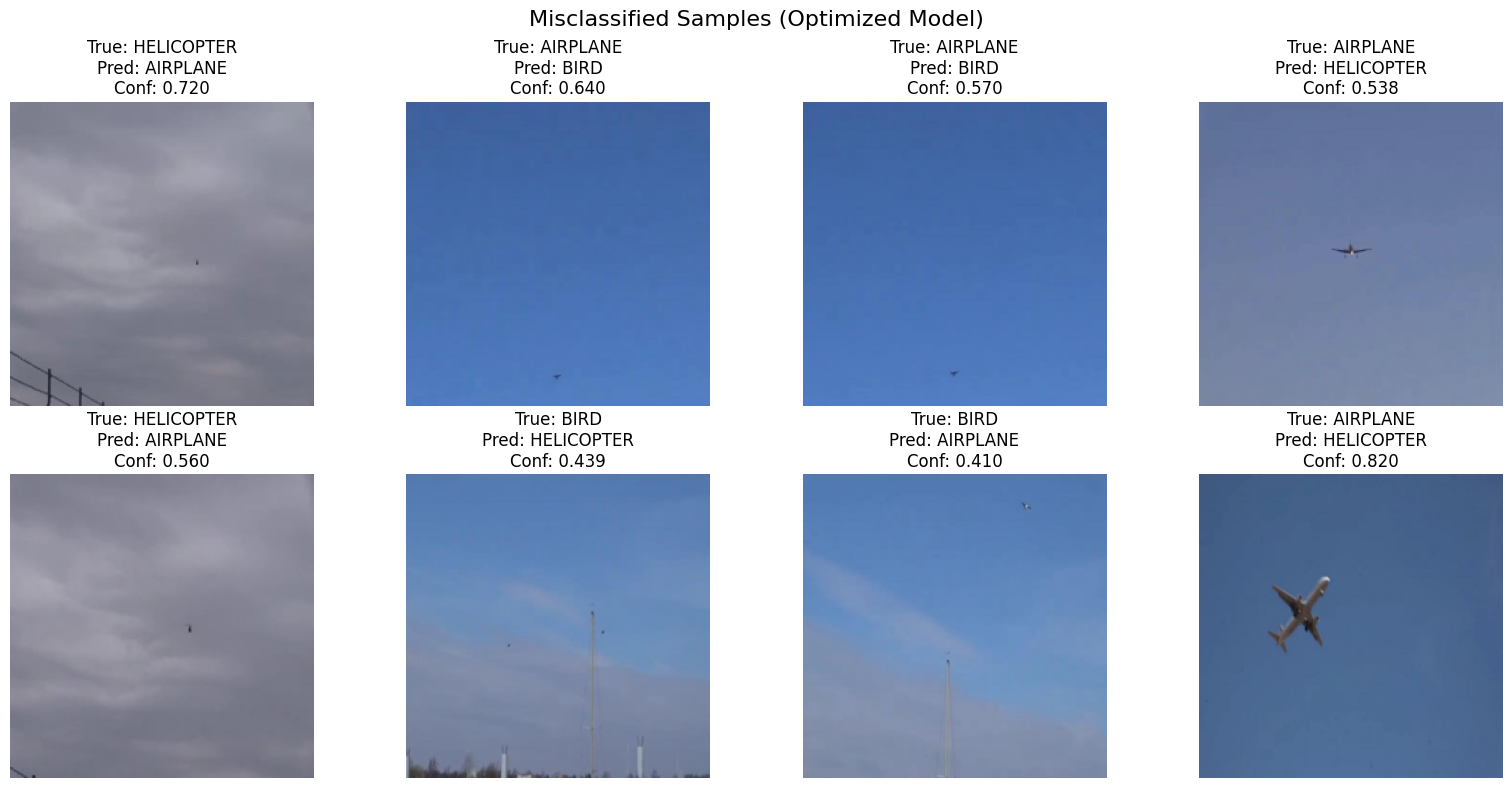


Most Common Error Patterns:
  AIRPLANE → HELICOPTER: 5 cases
  BIRD → HELICOPTER: 3 cases
  AIRPLANE → BIRD: 2 cases
  HELICOPTER → AIRPLANE: 2 cases
  BIRD → AIRPLANE: 1 cases


In [292]:
print("\n" + "="*80)
print("RandomForest Model Evaluation")
print("="*80)

# Evaluate on test set
if X_test_features is not None and len(X_test_cls) > 0:
    test_accuracy, y_test_pred, y_test_proba = evaluate_random_forest_model(
        optimized_rf, optimized_scaler, X_test_features, y_test_cls, feature_names
    )

    print(f"Optimized Random Forest Test Accuracy: {test_accuracy:.4f}")

    # Analyze prediction errors
    analyze_prediction_errors(X_test_cls, y_test_cls, y_test_pred, y_test_proba)

else:
    test_accuracy = optimized_valid_accuracy
    y_test_pred = None
    y_test_proba = None
    print("Using validation accuracy as final score (no test set available)")

## Concolutional Neural Networks (CNNs) Model Training

In [293]:
def create_classification_model(input_shape=(224, 224, 3), num_classes=4):
    '''
    Create a classification model
    '''
    model = Sequential([
        InputLayer(input_shape=input_shape),

        # Feature extraction
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        Conv2D(256, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        # Global average pooling
        tf.keras.layers.GlobalAveragePooling2D(),

        # Dense layers
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(256, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])

    return model

In [294]:
def train_classification_model(X_train, y_train, X_val=None, y_val=None):
    '''
    Train classification model
    '''
    print("="*60)
    print("Training CNN Classification Model")
    print("="*60)

    model = create_classification_model()

    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    # Print model summary
    model.summary()

    # Callbacks
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7),
        ModelCheckpoint('best_classification_model.h5', save_best_only=True, monitor='val_loss')
    ]

    # Prepare validation data
    if X_val is None or y_val is None:
        X_train, X_val, y_train, y_val = train_test_split(
            X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
        )

    print(f"Training samples: {len(X_train)}")
    print(f"Validation samples: {len(X_val)}")
    print(f"Classes distribution in training: {Counter(y_train)}")

    # Train model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks=callbacks,
        verbose=1
    )
    training_accuracy = record_performance_metrics('train', model, X_train, y_train, model_name='cnn')
    validation_accuracy = record_performance_metrics('valid', model, X_val, y_val, model_name='cnn')
    print(f"Training Accuracy - CNN: {training_accuracy:.4f}")
    print(f"Validation Accuracy - CNN: {validation_accuracy:.4f}")

    return model, history

In [295]:
def plot_training_history(history, title="Training History", filename='cnn_training_history'):
    '''
    Plot training history
    '''
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Plot loss
    axes[0].plot(history.history['loss'], label='Training Loss')
    axes[0].plot(history.history['val_loss'], label='Validation Loss')
    axes[0].set_title('Model Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(True)

    # Plot accuracy (if available)
    if 'accuracy' in history.history:
        axes[1].plot(history.history['accuracy'], label='Training Accuracy')
        axes[1].plot(history.history['val_accuracy'], label='Validation Accuracy')
        axes[1].set_title('Model Accuracy')
        axes[1].set_xlabel('Epoch')
        axes[1].set_ylabel('Accuracy')
        axes[1].legend()
        axes[1].grid(True)
    else:
        # Plot MAE for detection model
        if 'mae' in history.history:
            axes[1].plot(history.history['mae'], label='Training MAE')
            axes[1].plot(history.history['val_mae'], label='Validation MAE')
            axes[1].set_title('Model MAE')
            axes[1].set_xlabel('Epoch')
            axes[1].set_ylabel('MAE')
            axes[1].legend()
            axes[1].grid(True)

    plt.suptitle(title)
    plt.tight_layout()
    plt.savefig(f"images/{filename}.png")
    plt.show()

In [296]:
def evaluate_classification_model(model, X_test, y_test, filename="cnn_confusion_matrix"):
    '''
    Evaluate classification model
    '''
    print("="*60)
    print("Evaluating CNN Classfication Model")
    print("="*60)

    # Make predictions
    predictions = model.predict(X_test)
    predicted_classes = np.argmax(predictions, axis=1)

    # Calculate accuracy
    accuracy = np.mean(predicted_classes == y_test)
    print(f"Test Accuracy: {accuracy:.4f}")

    print("\nClassification Report:")
    print(classification_report(y_test, predicted_classes, target_names=class_names))

    # Confusion matrix
    cm = confusion_matrix(y_test, predicted_classes)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.savefig(f"images/{filename}.png")
    plt.show()

    return accuracy

## Train classification model on original data


Starting classification model training on original data...
Training CNN Classification Model


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_72 (Conv2D)              │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_72          │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_72 (MaxPooling2D) │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_73 (Conv2D)              │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_73          │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_73 (MaxPooling2D) │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_74 (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_74          │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_74 (MaxPooling2D) │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_75 (Conv2D)              │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_75          │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_75 (MaxPooling2D) │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_18     │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_56 (Dense)                │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 654,276 (2.50 MB)

 Trainable params: 653,316 (2.49 MB)

 Non-trainable params: 960 (3.75 KB)

Training samples: 2000
Validation samples: 400
Classes distribution in training: Counter({np.int64(1): 802, np.int64(2): 417, np.int64(0): 416, np.int64(3): 365})
Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.5935 - loss: 0.9983

63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 148ms/step - accuracy: 0.5946 - loss: 0.9953 - val_accuracy: 0.2450 - val_loss: 2.0011 - learning_rate: 0.0010
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.7322 - loss: 0.6436 - val_accuracy: 0.2375 - val_loss: 2.3251 - learning_rate: 0.0010
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.7725 - loss: 0.5370 - val_accuracy: 0.1900 - val_loss: 3.0656 - learning_rate: 0.0010
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.7987 - loss: 0.4879 - val_accuracy: 0.3175 - val_loss: 3.2265 - learning_rate: 0.0010
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.7957 - loss: 0.4943 - val_accuracy: 0.2725 - val_loss: 3.0829 - learning_rate: 0.0010
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.8451 - loss: 0.3679

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.8450 - loss: 0.3681 - val_accuracy: 0.3675 - val_loss: 1.9480 - learning_rate: 0.0010
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.8402 - loss: 0.3816 - val_accuracy: 0.2300 - val_loss: 4.6683 - learning_rate: 0.0010
Epoch 8/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.8544 - loss: 0.3320

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.8542 - loss: 0.3325 - val_accuracy: 0.6875 - val_loss: 0.7759 - learning_rate: 0.0010
Epoch 9/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8420 - loss: 0.3595

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.8422 - loss: 0.3592 - val_accuracy: 0.8125 - val_loss: 0.5603 - learning_rate: 0.0010
Epoch 10/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.8661 - loss: 0.3191

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.8660 - loss: 0.3196 - val_accuracy: 0.8350 - val_loss: 0.4965 - learning_rate: 0.0010
Epoch 11/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.8849 - loss: 0.2786 - val_accuracy: 0.4925 - val_loss: 2.0629 - learning_rate: 0.0010
Epoch 12/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.9001 - loss: 0.2645 - val_accuracy: 0.7325 - val_loss: 0.7265 - learning_rate: 0.0010
Epoch 13/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.8885 - loss: 0.2739 - val_accuracy: 0.3075 - val_loss: 4.5146 - learning_rate: 0.0010
Epoch 14/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9079 - loss: 0.2414

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.9078 - loss: 0.2416 - val_accuracy: 0.8700 - val_loss: 0.4509 - learning_rate: 0.0010
Epoch 15/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.8921 - loss: 0.2342

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.8922 - loss: 0.2341 - val_accuracy: 0.9000 - val_loss: 0.2405 - learning_rate: 0.0010
Epoch 16/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.8876 - loss: 0.2604 - val_accuracy: 0.3925 - val_loss: 1.9704 - learning_rate: 0.0010
Epoch 17/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.9220 - loss: 0.2024 - val_accuracy: 0.8025 - val_loss: 0.5320 - learning_rate: 0.0010
Epoch 18/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.8962 - loss: 0.2539 - val_accuracy: 0.6375 - val_loss: 1.3963 - learning_rate: 0.0010
Epoch 19/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.9030 - loss: 0.2543 - val_accuracy: 0.6675 - val_loss: 0.9610 - learning_rate: 0.0010
Epoch 20/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.9201 - loss: 0.2212 - val_accuracy: 0.8100 - val_loss: 0.4007 - learning_rate: 0.0010
Epoch 21/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.9307 - loss: 0.1634 - val_accuracy

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.9292 - loss: 0.1629 - val_accuracy: 0.9150 - val_loss: 0.1736 - learning_rate: 5.0000e-04
Epoch 23/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9417 - loss: 0.1620

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.9416 - loss: 0.1619 - val_accuracy: 0.9275 - val_loss: 0.1554 - learning_rate: 5.0000e-04
Epoch 24/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.9469 - loss: 0.1309 - val_accuracy: 0.8900 - val_loss: 0.2587 - learning_rate: 5.0000e-04
Epoch 25/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.9596 - loss: 0.1209 - val_accuracy: 0.9050 - val_loss: 0.2050 - learning_rate: 5.0000e-04
Epoch 26/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.9433 - loss: 0.1360 - val_accuracy: 0.8750 - val_loss: 0.3149 - learning_rate: 5.0000e-04
Epoch 27/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.9387 - loss: 0.1513 - val_accuracy: 0.5750 - val_loss: 2.3439 - learning_rate: 5.0000e-04
Epoch 28/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.9468 - loss: 0.1496 - val_accuracy: 0.9175 - val_loss: 0.2037 - learning_rate: 5.0000e-04
Epoch 29/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.9558 - los

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.9675 - loss: 0.0854 - val_accuracy: 0.9600 - val_loss: 0.1102 - learning_rate: 2.5000e-04
Epoch 31/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.9545 - loss: 0.1074 - val_accuracy: 0.9625 - val_loss: 0.1271 - learning_rate: 2.5000e-04
Epoch 32/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.9548 - loss: 0.0974 - val_accuracy: 0.9025 - val_loss: 0.2664 - learning_rate: 2.5000e-04
Epoch 33/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.9558 - loss: 0.1062 - val_accuracy: 0.9100 - val_loss: 0.2057 - learning_rate: 2.5000e-04
Epoch 34/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9624 - loss: 0.0979

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.9623 - loss: 0.0978 - val_accuracy: 0.9600 - val_loss: 0.1070 - learning_rate: 2.5000e-04
Epoch 35/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.9611 - loss: 0.0785 - val_accuracy: 0.9350 - val_loss: 0.1646 - learning_rate: 2.5000e-04
Epoch 36/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9671 - loss: 0.0915

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.9672 - loss: 0.0915 - val_accuracy: 0.9600 - val_loss: 0.1023 - learning_rate: 2.5000e-04
Epoch 37/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.9600 - loss: 0.0934 - val_accuracy: 0.9500 - val_loss: 0.1225 - learning_rate: 2.5000e-04
Epoch 38/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.9707 - loss: 0.0810 - val_accuracy: 0.9650 - val_loss: 0.1074 - learning_rate: 2.5000e-04
Epoch 39/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.9633 - loss: 0.0894 - val_accuracy: 0.9500 - val_loss: 0.1430 - learning_rate: 2.5000e-04
Epoch 40/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.9698 - loss: 0.0816 - val_accuracy: 0.9450 - val_loss: 0.1414 - learning_rate: 2.5000e-04
Epoch 41/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - accuracy: 0.9711 - loss: 0.0792 - val_accuracy: 0.9650 - val_loss: 0.1040 - learning_rate: 2.5000e-04
Epoch 42/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.9767 - los

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.9688 - loss: 0.0752 - val_accuracy: 0.9700 - val_loss: 0.0987 - learning_rate: 1.2500e-04
Epoch 44/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.9625 - loss: 0.0818 - val_accuracy: 0.9650 - val_loss: 0.1146 - learning_rate: 1.2500e-04
Epoch 45/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9728 - loss: 0.0627

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.9728 - loss: 0.0628 - val_accuracy: 0.9775 - val_loss: 0.0941 - learning_rate: 1.2500e-04
Epoch 46/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.9660 - loss: 0.0796 - val_accuracy: 0.9675 - val_loss: 0.1047 - learning_rate: 1.2500e-04
Epoch 47/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.9757 - loss: 0.0614 - val_accuracy: 0.9800 - val_loss: 0.0948 - learning_rate: 1.2500e-04
Epoch 48/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.9778 - loss: 0.0531 - val_accuracy: 0.9550 - val_loss: 0.1104 - learning_rate: 1.2500e-04
Epoch 49/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.9756 - loss: 0.0602 - val_accuracy: 0.9750 - val_loss: 0.0974 - learning_rate: 1.2500e-04
Epoch 50/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9791 - loss: 0.0521

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.9790 - loss: 0.0523 - val_accuracy: 0.9825 - val_loss: 0.0831 - learning_rate: 1.2500e-04
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step
Recording Performance Metrics for CNN:

Training Accuracy: 0.9880
Training MSE: 0.0880
Training MAE: 0.0291
Training Precision: 0.9880
Training Recall: 0.9880
Training F1 Score: 0.9880
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Recording Performance Metrics for CNN:

Validation Accuracy: 0.9825
Validation MSE: 0.1200
Validation MAE: 0.0314
Validation Precision: 0.9826
Validation Recall: 0.9825
Validation F1 Score: 0.9824
Training Accuracy - CNN: 0.9880
Validation Accuracy - CNN: 0.9825


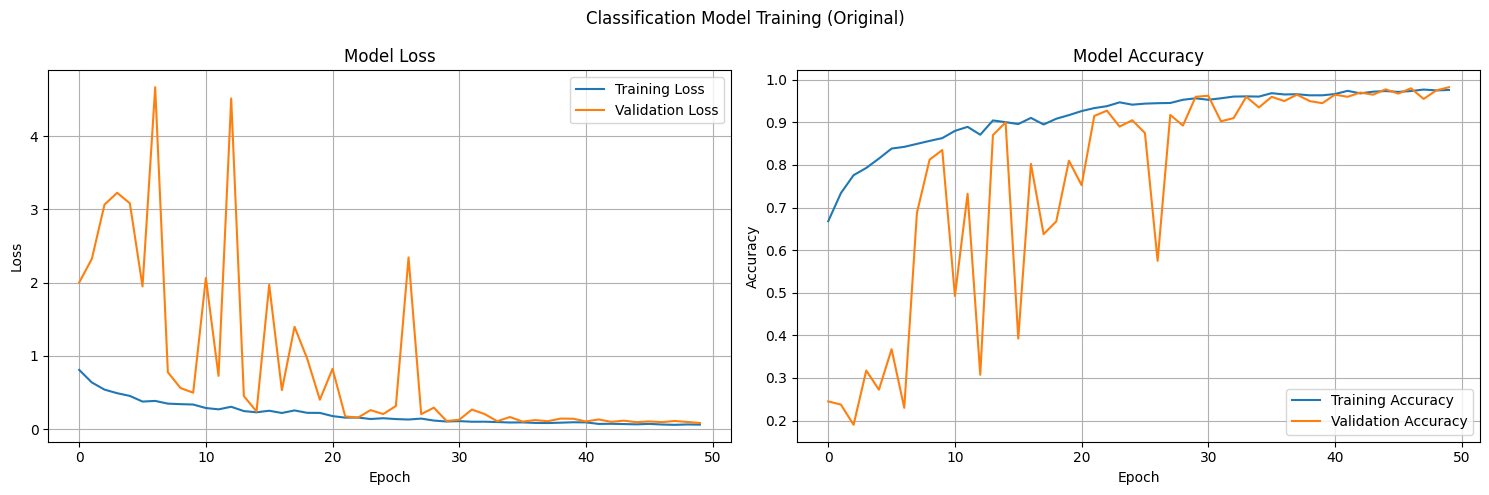

Evaluating CNN Classfication Model
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Test Accuracy: 0.9675

Classification Report:
              precision    recall  f1-score   support

    AIRPLANE       0.94      0.93      0.94        90
       DRONE       0.99      1.00      0.99       165
  HELICOPTER       0.95      1.00      0.97        70
        BIRD       0.97      0.91      0.94        75

    accuracy                           0.97       400
   macro avg       0.96      0.96      0.96       400
weighted avg       0.97      0.97      0.97       400



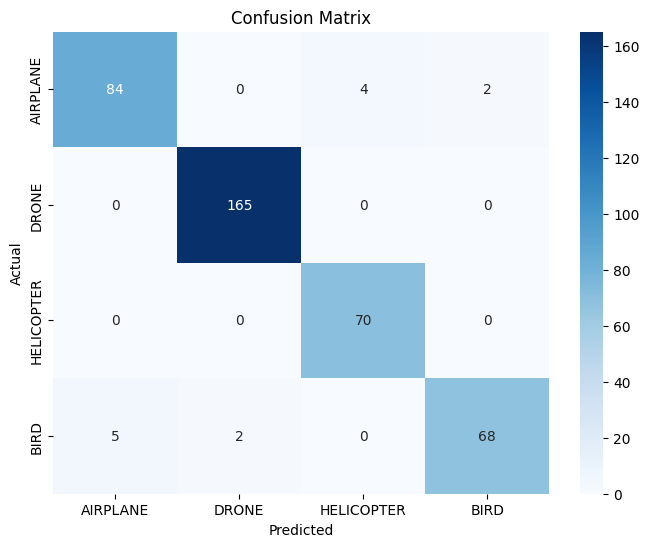

Final Classification Test Accuracy (Original): 0.9675
CPU times: user 1min 54s, sys: 4.24 s, total: 1min 58s
Wall time: 3min 3s


In [297]:
%%time
# Train classification model on original data
def train_classification_model_original(X_train, y_train, X_val=None, y_val=None):
    '''
    Train classification model on original data
    '''
    print("\nStarting classification model training on original data...")
    try:
        cls_model, cls_history = train_classification_model(
            X_train_cls, y_train_cls, X_val_cls, y_val_cls
        )

        # Plot training history
        plot_training_history(cls_history, "Classification Model Training (Original)")

        # Evaluate on test set
        if X_test_cls is not None and len(X_test_cls) > 0:
            accuracy_original = evaluate_classification_model(cls_model, X_test_cls, y_test_cls)
            print(f"Final Classification Test Accuracy (Original): {accuracy_original:.4f}")
        return cls_model, cls_history
    except Exception as e:
        print(f"Error during classification training: {e}")
        import traceback
        traceback.print_exc()
        cls_model = None

cnn_start_time = time.time()
cls_model, cls_history = train_classification_model_original(X_train_cls, y_train_cls, X_val_cls, y_val_cls)
cnn_end_time = time.time()
model_training_time.append(cnn_end_time - cnn_start_time)

## Train Classification Model Denoised


Starting classification model training on denoised data...
Training CNN Classification Model


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_76 (Conv2D)              │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_76          │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_76 (MaxPooling2D) │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_77 (Conv2D)              │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_77          │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_77 (MaxPooling2D) │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_78 (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_78          │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_78 (MaxPooling2D) │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_79 (Conv2D)              │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_79          │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_79 (MaxPooling2D) │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_19     │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_57 (Dense)                │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_38 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_58 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_39 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_59 (Dense)                │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 654,276 (2.50 MB)

 Trainable params: 653,316 (2.49 MB)

 Non-trainable params: 960 (3.75 KB)

Training samples: 2000
Validation samples: 400
Classes distribution in training: Counter({np.int64(1): 802, np.int64(2): 417, np.int64(0): 416, np.int64(3): 365})
Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.5782 - loss: 1.0501

63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 136ms/step - accuracy: 0.5792 - loss: 1.0476 - val_accuracy: 0.2175 - val_loss: 2.2159 - learning_rate: 0.0010
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.7281 - loss: 0.6464 - val_accuracy: 0.1900 - val_loss: 2.6047 - learning_rate: 0.0010
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.7549 - loss: 0.5840 - val_accuracy: 0.2375 - val_loss: 2.7046 - learning_rate: 0.0010
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.7938 - loss: 0.4871 - val_accuracy: 0.2500 - val_loss: 2.7409 - learning_rate: 0.0010
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.8326 - loss: 0.4126 - val_accuracy: 0.2925 - val_loss: 2.9673 - learning_rate: 0.0010
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.8140 - loss: 0.4423 - val_accuracy: 0.3050 - val_loss: 4.1240 - learning_rate: 0.0010
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.8650 - loss: 0.3327 - val_accuracy: 0.

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.8666 - loss: 0.3263 - val_accuracy: 0.4650 - val_loss: 1.7779 - learning_rate: 5.0000e-04
Epoch 9/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.8929 - loss: 0.2719

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.8927 - loss: 0.2722 - val_accuracy: 0.6825 - val_loss: 0.6703 - learning_rate: 5.0000e-04
Epoch 10/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.8917 - loss: 0.2607

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.8917 - loss: 0.2607 - val_accuracy: 0.8800 - val_loss: 0.3152 - learning_rate: 5.0000e-04
Epoch 11/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.8803 - loss: 0.2786 - val_accuracy: 0.8500 - val_loss: 0.3779 - learning_rate: 5.0000e-04
Epoch 12/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.8963 - loss: 0.2328 - val_accuracy: 0.7750 - val_loss: 0.4540 - learning_rate: 5.0000e-04
Epoch 13/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.9029 - loss: 0.2345 - val_accuracy: 0.8450 - val_loss: 0.4263 - learning_rate: 5.0000e-04
Epoch 14/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.8938 - loss: 0.2459

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.8937 - loss: 0.2460 - val_accuracy: 0.8725 - val_loss: 0.2824 - learning_rate: 5.0000e-04
Epoch 15/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9032 - loss: 0.2376

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.9033 - loss: 0.2376 - val_accuracy: 0.8950 - val_loss: 0.2311 - learning_rate: 5.0000e-04
Epoch 16/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.9198 - loss: 0.2003 - val_accuracy: 0.8525 - val_loss: 0.3136 - learning_rate: 5.0000e-04
Epoch 17/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.9017 - loss: 0.2353 - val_accuracy: 0.9000 - val_loss: 0.2473 - learning_rate: 5.0000e-04
Epoch 18/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.9084 - loss: 0.2265 - val_accuracy: 0.8375 - val_loss: 0.3441 - learning_rate: 5.0000e-04
Epoch 19/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.9139 - loss: 0.2176 - val_accuracy: 0.5725 - val_loss: 0.9915 - learning_rate: 5.0000e-04
Epoch 20/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.9268 - loss: 0.1867 - val_accuracy: 0.8525 - val_loss: 0.3240 - learning_rate: 5.0000e-04
Epoch 21/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.9191 - los

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.9276 - loss: 0.1743 - val_accuracy: 0.9075 - val_loss: 0.1872 - learning_rate: 2.5000e-04
Epoch 24/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.9316 - loss: 0.1632 - val_accuracy: 0.7900 - val_loss: 0.5240 - learning_rate: 2.5000e-04
Epoch 25/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.9405 - loss: 0.1522 - val_accuracy: 0.5675 - val_loss: 1.0955 - learning_rate: 2.5000e-04
Epoch 26/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9440 - loss: 0.1461

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.9438 - loss: 0.1462 - val_accuracy: 0.9325 - val_loss: 0.1672 - learning_rate: 2.5000e-04
Epoch 27/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.9467 - loss: 0.1320 - val_accuracy: 0.6550 - val_loss: 0.9473 - learning_rate: 2.5000e-04
Epoch 28/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.9560 - loss: 0.1220 - val_accuracy: 0.9325 - val_loss: 0.1830 - learning_rate: 2.5000e-04
Epoch 29/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.9347 - loss: 0.1643 - val_accuracy: 0.9075 - val_loss: 0.1824 - learning_rate: 2.5000e-04
Epoch 30/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.9504 - loss: 0.1261 - val_accuracy: 0.8000 - val_loss: 0.4769 - learning_rate: 2.5000e-04
Epoch 31/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.9466 - loss: 0.1425 - val_accuracy: 0.8925 - val_loss: 0.2714 - learning_rate: 2.5000e-04
Epoch 32/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9501 - los

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.9501 - loss: 0.1261 - val_accuracy: 0.9500 - val_loss: 0.1457 - learning_rate: 1.2500e-04
Epoch 33/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.9485 - loss: 0.1189 - val_accuracy: 0.8725 - val_loss: 0.3706 - learning_rate: 1.2500e-04
Epoch 34/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.9598 - loss: 0.1081 - val_accuracy: 0.9275 - val_loss: 0.2388 - learning_rate: 1.2500e-04
Epoch 35/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.9541 - loss: 0.1073 - val_accuracy: 0.9450 - val_loss: 0.1497 - learning_rate: 1.2500e-04
Epoch 36/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9586 - loss: 0.1256

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.9587 - loss: 0.1251 - val_accuracy: 0.9550 - val_loss: 0.1428 - learning_rate: 1.2500e-04
Epoch 37/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9567 - loss: 0.1028

63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - accuracy: 0.9567 - loss: 0.1028 - val_accuracy: 0.9575 - val_loss: 0.1328 - learning_rate: 1.2500e-04
Epoch 38/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.9636 - loss: 0.0995 - val_accuracy: 0.9400 - val_loss: 0.1332 - learning_rate: 1.2500e-04
Epoch 39/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.9610 - loss: 0.0940 - val_accuracy: 0.8925 - val_loss: 0.2756 - learning_rate: 1.2500e-04
Epoch 40/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.9457 - loss: 0.1190 - val_accuracy: 0.9500 - val_loss: 0.1562 - learning_rate: 1.2500e-04
Epoch 41/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.9583 - loss: 0.1059 - val_accuracy: 0.9225 - val_loss: 0.2282 - learning_rate: 1.2500e-04
Epoch 42/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9506 - loss: 0.1256

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.9506 - loss: 0.1256 - val_accuracy: 0.9475 - val_loss: 0.1300 - learning_rate: 1.2500e-04
Epoch 43/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.9601 - loss: 0.1020 - val_accuracy: 0.9300 - val_loss: 0.1425 - learning_rate: 1.2500e-04
Epoch 44/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.9613 - loss: 0.1036 - val_accuracy: 0.8975 - val_loss: 0.2000 - learning_rate: 1.2500e-04
Epoch 45/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.9560 - loss: 0.1048 - val_accuracy: 0.9175 - val_loss: 0.1994 - learning_rate: 1.2500e-04
Epoch 46/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.9580 - loss: 0.1041 - val_accuracy: 0.9475 - val_loss: 0.1357 - learning_rate: 1.2500e-04
Epoch 47/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.9588 - loss: 0.0930 - val_accuracy: 0.9100 - val_loss: 0.2121 - learning_rate: 1.2500e-04
Epoch 48/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9611 - los

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.9611 - loss: 0.0893 - val_accuracy: 0.9600 - val_loss: 0.1292 - learning_rate: 6.2500e-05
Epoch 49/50
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.9625 - loss: 0.0920

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.9627 - loss: 0.0920 - val_accuracy: 0.9625 - val_loss: 0.1208 - learning_rate: 6.2500e-05
Epoch 50/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.9647 - loss: 0.0893 - val_accuracy: 0.9550 - val_loss: 0.1383 - learning_rate: 6.2500e-05
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step
Recording Performance Metrics for CNN:

Training Accuracy: 0.9810
Training MSE: 0.1235
Training MAE: 0.0334
Training Precision: 0.9813
Training Recall: 0.9810
Training F1 Score: 0.9810
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Recording Performance Metrics for CNN:

Validation Accuracy: 0.9625
Validation MSE: 0.2375
Validation MAE: 0.0399
Validation Precision: 0.9641
Validation Recall: 0.9625
Validation F1 Score: 0.9627
Training Accuracy - CNN: 0.9810
Validation Accuracy - CNN: 0.9625


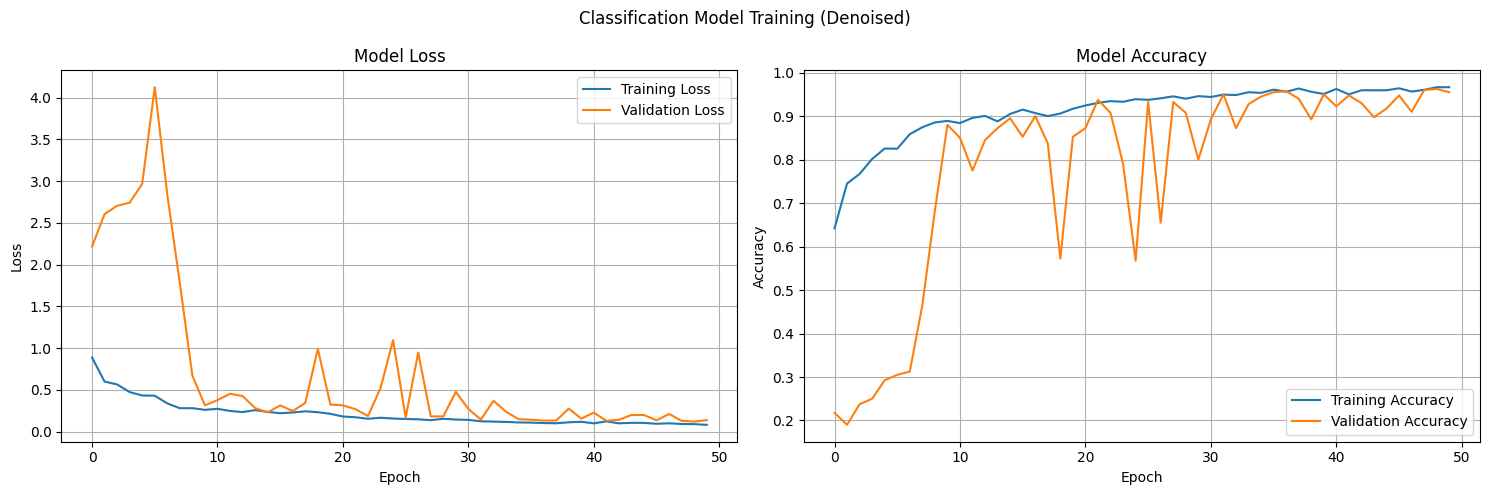

Evaluating CNN Classfication Model
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Test Accuracy: 0.9600

Classification Report:
              precision    recall  f1-score   support

    AIRPLANE       0.90      0.96      0.92        90
       DRONE       0.99      1.00      0.99       165
  HELICOPTER       0.94      0.94      0.94        70
        BIRD       1.00      0.89      0.94        75

    accuracy                           0.96       400
   macro avg       0.96      0.95      0.95       400
weighted avg       0.96      0.96      0.96       400



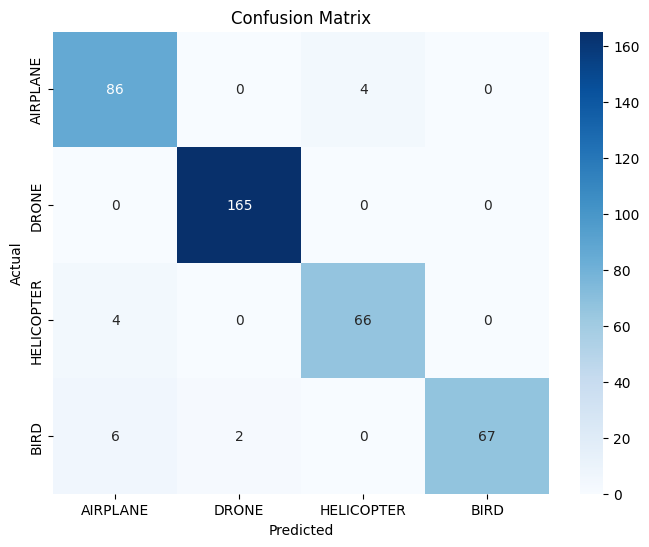

Final Classification Test Accuracy (Denoised): 0.9600
CPU times: user 1min 55s, sys: 6.02 s, total: 2min 1s
Wall time: 3min 3s


In [298]:
%%time
# Train classification model on denoised data
def train_classification_model_denoised(X_train_denoised, y_train):
    '''
    Train classification model on denoised data
    '''
    print("\nStarting classification model training on denoised data...")
    try:
        cls_model_denoised, cls_history_denoised = train_classification_model(
            X_train_denoised, y_train_cls, X_val_cls, y_val_cls
        )

        # Plot training history
        plot_training_history(cls_history_denoised, "Classification Model Training (Denoised)", "cnn_denoised_training_history")

        # Evaluate on test set
        if X_test_cls is not None and len(X_test_cls) > 0:
            # Apply denoising to test set
            X_test_denoised = np.zeros_like(X_test_cls)
            for i in range(len(X_test_cls)):
                img_uint8 = (X_test_cls[i] * 255).astype(np.uint8)
                blurred = cv2.GaussianBlur(img_uint8, (3, 3), 0)
                X_test_denoised[i] = blurred / 255.0

            accuracy_denoised = evaluate_classification_model(cls_model_denoised, X_test_denoised, y_test_cls, "cnn_denoised_confusion_matrix")
            print(f"Final Classification Test Accuracy (Denoised): {accuracy_denoised:.4f}")

            return cls_model_denoised, cls_history_denoised
    except Exception as e:
        print(f"Error during denoised classification training: {e}")
        import traceback
        traceback.print_exc()
        cls_model_denoised = None

cnn_denoised_start_time = time.time()
cls_model_denoised, cls_history_denoised = train_classification_model_denoised(X_train_denoised, y_train_cls)
cnn_denoised_end_time = time.time()
model_training_time.append(cnn_denoised_end_time - cnn_denoised_start_time)

## Train Detection Model

In [299]:
# Model creation functions (keeping original functions)
def create_detection_model(input_shape=(224, 224, 3), num_classes=4, max_boxes=10):
    '''
    Create a simplified detection model that predicts class + bounding box for multiple objects
    '''
    inputs = Input(shape=input_shape)

    # Feature extraction backbone
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    # Global average pooling
    x = tf.keras.layers.GlobalAveragePooling2D()(x)

    # Dense layers
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)

    # Output layer for multiple object detection
    # Output shape: (batch_size, max_boxes * 5) where each box has [class, x, y, w, h]
    x = Dense(max_boxes * 5, activation='linear')(x)

    # Reshape to (batch_size, max_boxes, 5)
    outputs = Reshape((max_boxes, 5), name='detection_output')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

In [300]:
def visualize_detection_predictions(X_test, Y_true, Y_pred, num_samples=6):
    '''
    Visualize detection predictions
    '''
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Detection Model Predictions vs Ground Truth', fontsize=16, fontweight='bold')
    axes = axes.flatten()

    # Select random samples
    indices = np.random.choice(len(X_test), min(num_samples, len(X_test)), replace=False)

    for i, idx in enumerate(indices):
        if i >= num_samples:
            break

        img = X_test[idx]
        true_boxes = Y_true[idx]
        pred_boxes = Y_pred[idx]

        # Display image
        axes[i].imshow(img)
        axes[i].set_title(f'Image {idx}')
        axes[i].axis('off')

        img_height, img_width = img.shape[:2]

        # Draw ground truth boxes in blue
        for j, box in enumerate(true_boxes):
            if np.sum(np.abs(box)) > 0:  # Valid box
                class_id, x_center, y_center, width, height = box

                # Convert to pixel coordinates
                x_center *= img_width
                y_center *= img_height
                width *= img_width
                height *= img_height

                # Calculate top-left corner
                x1 = x_center - width / 2
                y1 = y_center - height / 2

                # Draw ground truth rectangle (blue)
                rect = Rectangle((x1, y1), width, height,
                               linewidth=2, edgecolor='blue', facecolor='none')
                axes[i].add_patch(rect)

                # Add class label
                if int(class_id) < len(class_names):
                    axes[i].text(x1, y1-5, f'GT: {class_names[int(class_id)]}',
                               color='blue', fontsize=8, fontweight='bold',
                               bbox=dict(facecolor='white', alpha=0.8, pad=1))

        # Draw predicted boxes in red
        for j, box in enumerate(pred_boxes):
            if np.sum(np.abs(box)) > 0.1:  # Valid prediction (threshold)
                class_id, x_center, y_center, width, height = box

                # Convert to pixel coordinates
                x_center *= img_width
                y_center *= img_height
                width *= img_width
                height *= img_height

                # Calculate top-left corner
                x1 = x_center - width / 2
                y1 = y_center - height / 2

                # Draw prediction rectangle (red)
                rect = Rectangle((x1, y1), width, height,
                               linewidth=2, edgecolor='red', facecolor='none', linestyle='--')
                axes[i].add_patch(rect)

                # Add class label
                pred_class = int(np.round(class_id))
                if 0 <= pred_class < len(class_names):
                    axes[i].text(x1, y1+height+5, f'Pred: {class_names[pred_class]}',
                               color='red', fontsize=8, fontweight='bold',
                               bbox=dict(facecolor='white', alpha=0.8, pad=1))

    plt.tight_layout()
    plt.savefig("images/detection_predictions.png")
    plt.show()

In [301]:
def evaluate_detection_model(model, X_test, Y_test):
    '''
    Evaluate detection model
    '''
    print("="*60)
    print("EVALUATING DETECTION MODEL")
    print("="*60)

    # Make predictions
    predictions = model.predict(X_test)

    # Calculate various metrics
    mae = mae_loss(Y_test, predictions)
    mse = mse_loss(Y_test, predictions)

    print(f"Test MAE: {tf.reduce_mean(mae):.4f}")
    print(f"Test MSE: {tf.reduce_mean(mse):.4f}")

    # Visualize some predictions
    visualize_detection_predictions(X_test, Y_test, predictions, num_samples=6)

    return tf.reduce_mean(mae).numpy()

In [302]:
def detection_loss(y_true, y_pred):
    '''
    Detection loss using MSE
    '''
    # Calculate MSE loss between predictions and ground truth
    loss = mse_loss(y_true, y_pred)

    # Create mask for valid boxes
    valid_mask = tf.reduce_sum(tf.abs(y_true), axis=-1) > 0
    valid_mask_float = tf.cast(valid_mask, tf.float32)

    # Apply mask and return mean loss
    masked_loss = loss * valid_mask_float

    # Calculate mean only over valid samples
    num_valid = tf.reduce_sum(valid_mask_float, axis=-1)
    num_valid = tf.maximum(num_valid, 1.0)

    sample_loss = tf.reduce_sum(masked_loss, axis=-1) / num_valid

    return tf.reduce_mean(sample_loss)

In [303]:
def train_detection_model(X_train, Y_train, X_val=None, Y_val=None):
    '''
    Train detection model
    '''
    print("="*60)
    print("TRAINING DETECTION MODEL")
    print("="*60)

    model = create_detection_model()

    # Compile model with simplified loss
    model.compile(
        optimizer=Adam(learning_rate=0.0001),  # Lower learning rate
        loss=detection_loss,
        metrics=['accuracy', 'mse', 'mae']
    )

    # Print model summary
    model.summary()

    # Callbacks
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=1e-8),
        ModelCheckpoint('best_detection_model.h5', save_best_only=True, monitor='val_loss')
    ]

    # Prepare validation data
    if X_val is None or Y_val is None:
        X_train, X_val, Y_train, Y_val = train_test_split(
            X_train, Y_train, test_size=0.2, random_state=42
        )

    print(f"Training samples: {len(X_train)}")
    print(f"Validation samples: {len(X_val)}")
    print(f"Input shape: {X_train.shape}")
    print(f"Output shape: {Y_train.shape}")

    # Train model
    history = model.fit(
        X_train, Y_train,
        validation_data=(X_val, Y_val),
        epochs=EPOCHS,  # Reduced epochs for initial training
        batch_size=SMALL_BATCH_SIZE,   # Smaller batch size
        callbacks=callbacks,
        verbose=1
    )
    return model, history


Starting detection model training...
TRAINING DETECTION MODEL


Model: "functional_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_20 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_80 (Conv2D)              │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_80          │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_80 (MaxPooling2D) │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_81 (Conv2D)              │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_81          │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_81 (MaxPooling2D) │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_82 (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_82          │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_82 (MaxPooling2D) │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_83 (Conv2D)              │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_83          │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_83 (MaxPooling2D) │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_20     │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_60 (Dense)                │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_40 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_61 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_41 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_62 (Dense)                │ (None, 50)             │        12,850 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ detection_output (Reshape)      │ (None, 10, 5)          │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 666,098 (2.54 MB)

 Trainable params: 665,138 (2.54 MB)

 Non-trainable params: 960 (3.75 KB)

Training samples: 2000
Validation samples: 400
Input shape: (2000, 224, 224, 3)
Output shape: (2000, 10, 5)
Epoch 1/50
247/250 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.2308 - loss: 0.1429 - mae: 0.2383 - mse: 0.1429

250/250 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - accuracy: 0.2310 - loss: 0.1419 - mae: 0.2372 - mse: 0.1419 - val_accuracy: 0.4498 - val_loss: 0.0859 - val_mae: 0.1726 - val_mse: 0.0859 - learning_rate: 1.0000e-04
Epoch 2/50
248/250 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.2638 - loss: 0.0346 - mae: 0.1046 - mse: 0.0346

250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.2639 - loss: 0.0346 - mae: 0.1046 - mse: 0.0346 - val_accuracy: 0.3530 - val_loss: 0.0460 - val_mae: 0.1001 - val_mse: 0.0460 - learning_rate: 1.0000e-04
Epoch 3/50
249/250 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.2762 - loss: 0.0292 - mae: 0.0884 - mse: 0.0292

250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.2762 - loss: 0.0292 - mae: 0.0884 - mse: 0.0292 - val_accuracy: 0.2783 - val_loss: 0.0212 - val_mae: 0.0421 - val_mse: 0.0212 - learning_rate: 1.0000e-04
Epoch 4/50
248/250 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.2865 - loss: 0.0264 - mae: 0.0801 - mse: 0.0264

250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.2865 - loss: 0.0264 - mae: 0.0801 - mse: 0.0264 - val_accuracy: 0.3320 - val_loss: 0.0186 - val_mae: 0.0394 - val_mse: 0.0186 - learning_rate: 1.0000e-04
Epoch 5/50
249/250 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.2753 - loss: 0.0225 - mae: 0.0730 - mse: 0.0225

250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.2754 - loss: 0.0225 - mae: 0.0729 - mse: 0.0225 - val_accuracy: 0.3350 - val_loss: 0.0149 - val_mae: 0.0351 - val_mse: 0.0149 - learning_rate: 1.0000e-04
Epoch 6/50
247/250 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.2771 - loss: 0.0210 - mae: 0.0681 - mse: 0.0210

250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.2771 - loss: 0.0210 - mae: 0.0681 - mse: 0.0210 - val_accuracy: 0.2437 - val_loss: 0.0141 - val_mae: 0.0336 - val_mse: 0.0141 - learning_rate: 1.0000e-04
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.2796 - loss: 0.0201 - mae: 0.0653 - mse: 0.0201 - val_accuracy: 0.2905 - val_loss: 0.0148 - val_mae: 0.0332 - val_mse: 0.0148 - learning_rate: 1.0000e-04
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.2786 - loss: 0.0195 - mae: 0.0613 - mse: 0.0195 - val_accuracy: 0.3272 - val_loss: 0.0144 - val_mae: 0.0336 - val_mse: 0.0144 - learning_rate: 1.0000e-04
Epoch 9/50
248/250 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.2911 - loss: 0.0172 - mae: 0.0577 - mse: 0.0172

250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.2911 - loss: 0.0172 - mae: 0.0577 - mse: 0.0172 - val_accuracy: 0.2610 - val_loss: 0.0130 - val_mae: 0.0291 - val_mse: 0.0130 - learning_rate: 1.0000e-04
Epoch 10/50
249/250 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.2915 - loss: 0.0178 - mae: 0.0559 - mse: 0.0178

250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.2915 - loss: 0.0178 - mae: 0.0559 - mse: 0.0178 - val_accuracy: 0.3708 - val_loss: 0.0123 - val_mae: 0.0292 - val_mse: 0.0123 - learning_rate: 1.0000e-04
Epoch 11/50
248/250 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.2915 - loss: 0.0169 - mae: 0.0528 - mse: 0.0169

250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.2915 - loss: 0.0169 - mae: 0.0528 - mse: 0.0169 - val_accuracy: 0.3295 - val_loss: 0.0114 - val_mae: 0.0277 - val_mse: 0.0114 - learning_rate: 1.0000e-04
Epoch 12/50
246/250 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.2883 - loss: 0.0157 - mae: 0.0500 - mse: 0.0157

250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.2883 - loss: 0.0157 - mae: 0.0500 - mse: 0.0157 - val_accuracy: 0.4015 - val_loss: 0.0110 - val_mae: 0.0258 - val_mse: 0.0110 - learning_rate: 1.0000e-04
Epoch 13/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.2861 - loss: 0.0155 - mae: 0.0492 - mse: 0.0155 - val_accuracy: 0.3050 - val_loss: 0.0125 - val_mae: 0.0265 - val_mse: 0.0125 - learning_rate: 1.0000e-04
Epoch 14/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.2970 - loss: 0.0160 - mae: 0.0473 - mse: 0.0160 - val_accuracy: 0.3770 - val_loss: 0.0111 - val_mae: 0.0249 - val_mse: 0.0111 - learning_rate: 1.0000e-04
Epoch 15/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.2926 - loss: 0.0154 - mae: 0.0465 - mse: 0.0154 - val_accuracy: 0.3150 - val_loss: 0.0131 - val_mae: 0.0257 - val_mse: 0.0131 - learning_rate: 1.0000e-04
Epoch 16/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3076 - loss: 0.0151 - mae: 0.0436 - mse: 0.0151

250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.3076 - loss: 0.0151 - mae: 0.0436 - mse: 0.0151 - val_accuracy: 0.2812 - val_loss: 0.0107 - val_mae: 0.0242 - val_mse: 0.0107 - learning_rate: 1.0000e-04
Epoch 17/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.3011 - loss: 0.0138 - mae: 0.0423 - mse: 0.0138 - val_accuracy: 0.3418 - val_loss: 0.0118 - val_mae: 0.0238 - val_mse: 0.0118 - learning_rate: 1.0000e-04
Epoch 18/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.2967 - loss: 0.0143 - mae: 0.0410 - mse: 0.0143 - val_accuracy: 0.2960 - val_loss: 0.0112 - val_mae: 0.0247 - val_mse: 0.0112 - learning_rate: 1.0000e-04
Epoch 19/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.3087 - loss: 0.0138 - mae: 0.0394 - mse: 0.0138 - val_accuracy: 0.3700 - val_loss: 0.0120 - val_mae: 0.0243 - val_mse: 0.0120 - learning_rate: 1.0000e-04
Epoch 20/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.3120 - loss: 0.0127 - mae: 0.0376 - mse: 0.0127 - val_ac

250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.3105 - loss: 0.0129 - mae: 0.0371 - mse: 0.0129 - val_accuracy: 0.3512 - val_loss: 0.0090 - val_mae: 0.0213 - val_mse: 0.0090 - learning_rate: 1.0000e-04
Epoch 22/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.3119 - loss: 0.0119 - mae: 0.0350 - mse: 0.0119 - val_accuracy: 0.3738 - val_loss: 0.0096 - val_mae: 0.0215 - val_mse: 0.0096 - learning_rate: 1.0000e-04
Epoch 23/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.3107 - loss: 0.0119 - mae: 0.0351 - mse: 0.0119 - val_accuracy: 0.2818 - val_loss: 0.0102 - val_mae: 0.0211 - val_mse: 0.0102 - learning_rate: 1.0000e-04
Epoch 24/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.3169 - loss: 0.0121 - mae: 0.0341 - mse: 0.0121 - val_accuracy: 0.2960 - val_loss: 0.0106 - val_mae: 0.0206 - val_mse: 0.0106 - learning_rate: 1.0000e-04
Epoch 25/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.3226 - loss: 0.0140 - mae: 0.0341 - mse: 0.0140 - val_ac

250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.3089 - loss: 0.0110 - mae: 0.0319 - mse: 0.0110 - val_accuracy: 0.4332 - val_loss: 0.0080 - val_mae: 0.0191 - val_mse: 0.0080 - learning_rate: 1.0000e-04
Epoch 27/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.3323 - loss: 0.0117 - mae: 0.0319 - mse: 0.0117 - val_accuracy: 0.3662 - val_loss: 0.0080 - val_mae: 0.0190 - val_mse: 0.0080 - learning_rate: 1.0000e-04
Epoch 28/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.3240 - loss: 0.0105 - mae: 0.0303 - mse: 0.0105 - val_accuracy: 0.3823 - val_loss: 0.0086 - val_mae: 0.0188 - val_mse: 0.0086 - learning_rate: 1.0000e-04
Epoch 29/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.3281 - loss: 0.0110 - mae: 0.0292 - mse: 0.0110 - val_accuracy: 0.4840 - val_loss: 0.0086 - val_mae: 0.0194 - val_mse: 0.0086 - learning_rate: 1.0000e-04
Epoch 30/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.3335 - loss: 0.0109 - mae: 0.0286 - mse: 0.0109 - val_ac

250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.3557 - loss: 0.0107 - mae: 0.0269 - mse: 0.0107 - val_accuracy: 0.3502 - val_loss: 0.0075 - val_mae: 0.0167 - val_mse: 0.0075 - learning_rate: 1.0000e-04
Epoch 34/50
249/250 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3353 - loss: 0.0103 - mae: 0.0258 - mse: 0.0103

250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.3353 - loss: 0.0103 - mae: 0.0258 - mse: 0.0103 - val_accuracy: 0.3933 - val_loss: 0.0069 - val_mae: 0.0163 - val_mse: 0.0069 - learning_rate: 1.0000e-04
Epoch 35/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.3342 - loss: 0.0085 - mae: 0.0239 - mse: 0.0085 - val_accuracy: 0.3765 - val_loss: 0.0081 - val_mae: 0.0179 - val_mse: 0.0081 - learning_rate: 1.0000e-04
Epoch 36/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3485 - loss: 0.0096 - mae: 0.0244 - mse: 0.0096

250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.3485 - loss: 0.0096 - mae: 0.0244 - mse: 0.0096 - val_accuracy: 0.3308 - val_loss: 0.0062 - val_mae: 0.0145 - val_mse: 0.0062 - learning_rate: 1.0000e-04
Epoch 37/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.3519 - loss: 0.0085 - mae: 0.0230 - mse: 0.0085 - val_accuracy: 0.4907 - val_loss: 0.0066 - val_mae: 0.0157 - val_mse: 0.0066 - learning_rate: 1.0000e-04
Epoch 38/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.3579 - loss: 0.0084 - mae: 0.0226 - mse: 0.0084 - val_accuracy: 0.3357 - val_loss: 0.0070 - val_mae: 0.0163 - val_mse: 0.0070 - learning_rate: 1.0000e-04
Epoch 39/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.3779 - loss: 0.0103 - mae: 0.0231 - mse: 0.0103 - val_accuracy: 0.4145 - val_loss: 0.0089 - val_mae: 0.0180 - val_mse: 0.0089 - learning_rate: 1.0000e-04
Epoch 40/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.3519 - loss: 0.0091 - mae: 0.0220 - mse: 0.0091 - val_ac

250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.3694 - loss: 0.0089 - mae: 0.0216 - mse: 0.0089 - val_accuracy: 0.4205 - val_loss: 0.0058 - val_mae: 0.0145 - val_mse: 0.0058 - learning_rate: 1.0000e-04
Epoch 42/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.3791 - loss: 0.0082 - mae: 0.0203 - mse: 0.0082 - val_accuracy: 0.3758 - val_loss: 0.0087 - val_mae: 0.0179 - val_mse: 0.0087 - learning_rate: 1.0000e-04
Epoch 43/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.3546 - loss: 0.0079 - mae: 0.0204 - mse: 0.0079 - val_accuracy: 0.4918 - val_loss: 0.0067 - val_mae: 0.0166 - val_mse: 0.0067 - learning_rate: 1.0000e-04
Epoch 44/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3780 - loss: 0.0078 - mae: 0.0200 - mse: 0.0078

250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.3780 - loss: 0.0078 - mae: 0.0200 - mse: 0.0078 - val_accuracy: 0.3630 - val_loss: 0.0055 - val_mae: 0.0142 - val_mse: 0.0055 - learning_rate: 1.0000e-04
Epoch 45/50
247/250 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.3615 - loss: 0.0075 - mae: 0.0196 - mse: 0.0075

250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.3613 - loss: 0.0075 - mae: 0.0196 - mse: 0.0075 - val_accuracy: 0.3530 - val_loss: 0.0049 - val_mae: 0.0133 - val_mse: 0.0049 - learning_rate: 1.0000e-04
Epoch 46/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.3555 - loss: 0.0072 - mae: 0.0186 - mse: 0.0072 - val_accuracy: 0.3628 - val_loss: 0.0071 - val_mae: 0.0155 - val_mse: 0.0071 - learning_rate: 1.0000e-04
Epoch 47/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.3680 - loss: 0.0071 - mae: 0.0186 - mse: 0.0071 - val_accuracy: 0.3408 - val_loss: 0.0054 - val_mae: 0.0129 - val_mse: 0.0054 - learning_rate: 1.0000e-04
Epoch 48/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.3799 - loss: 0.0072 - mae: 0.0189 - mse: 0.0072 - val_accuracy: 0.4285 - val_loss: 0.0059 - val_mae: 0.0157 - val_mse: 0.0059 - learning_rate: 1.0000e-04
Epoch 49/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.3563 - loss: 0.0067 - mae: 0.0178 - mse: 0.0067 - val_ac

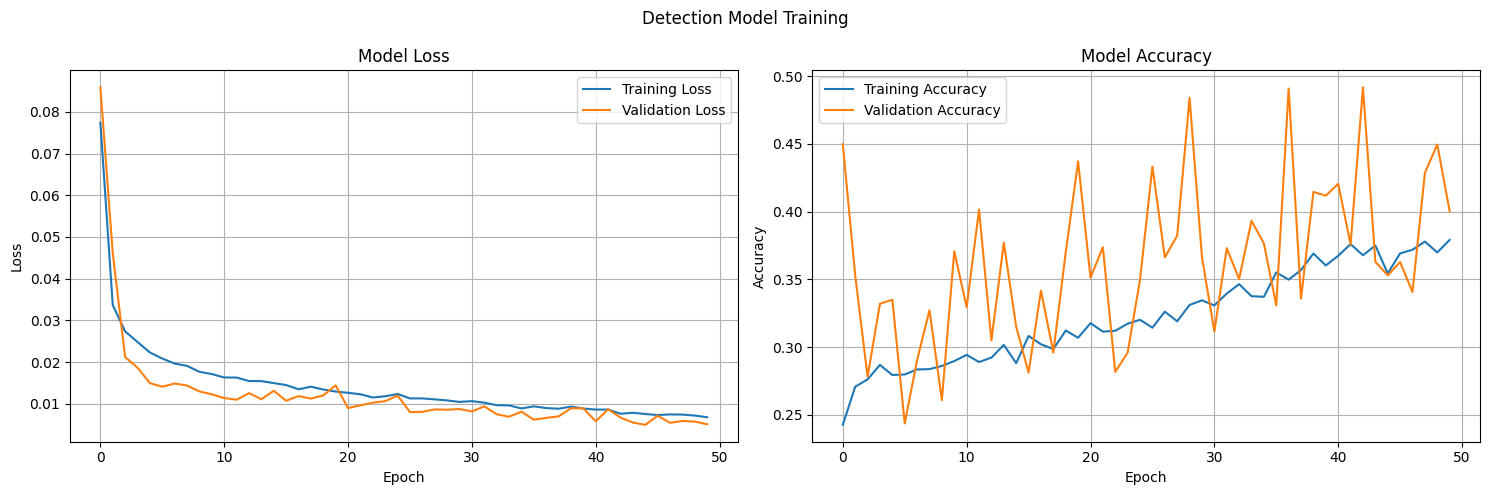

EVALUATING DETECTION MODEL
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step
Test MAE: 0.0143
Test MSE: 0.0063


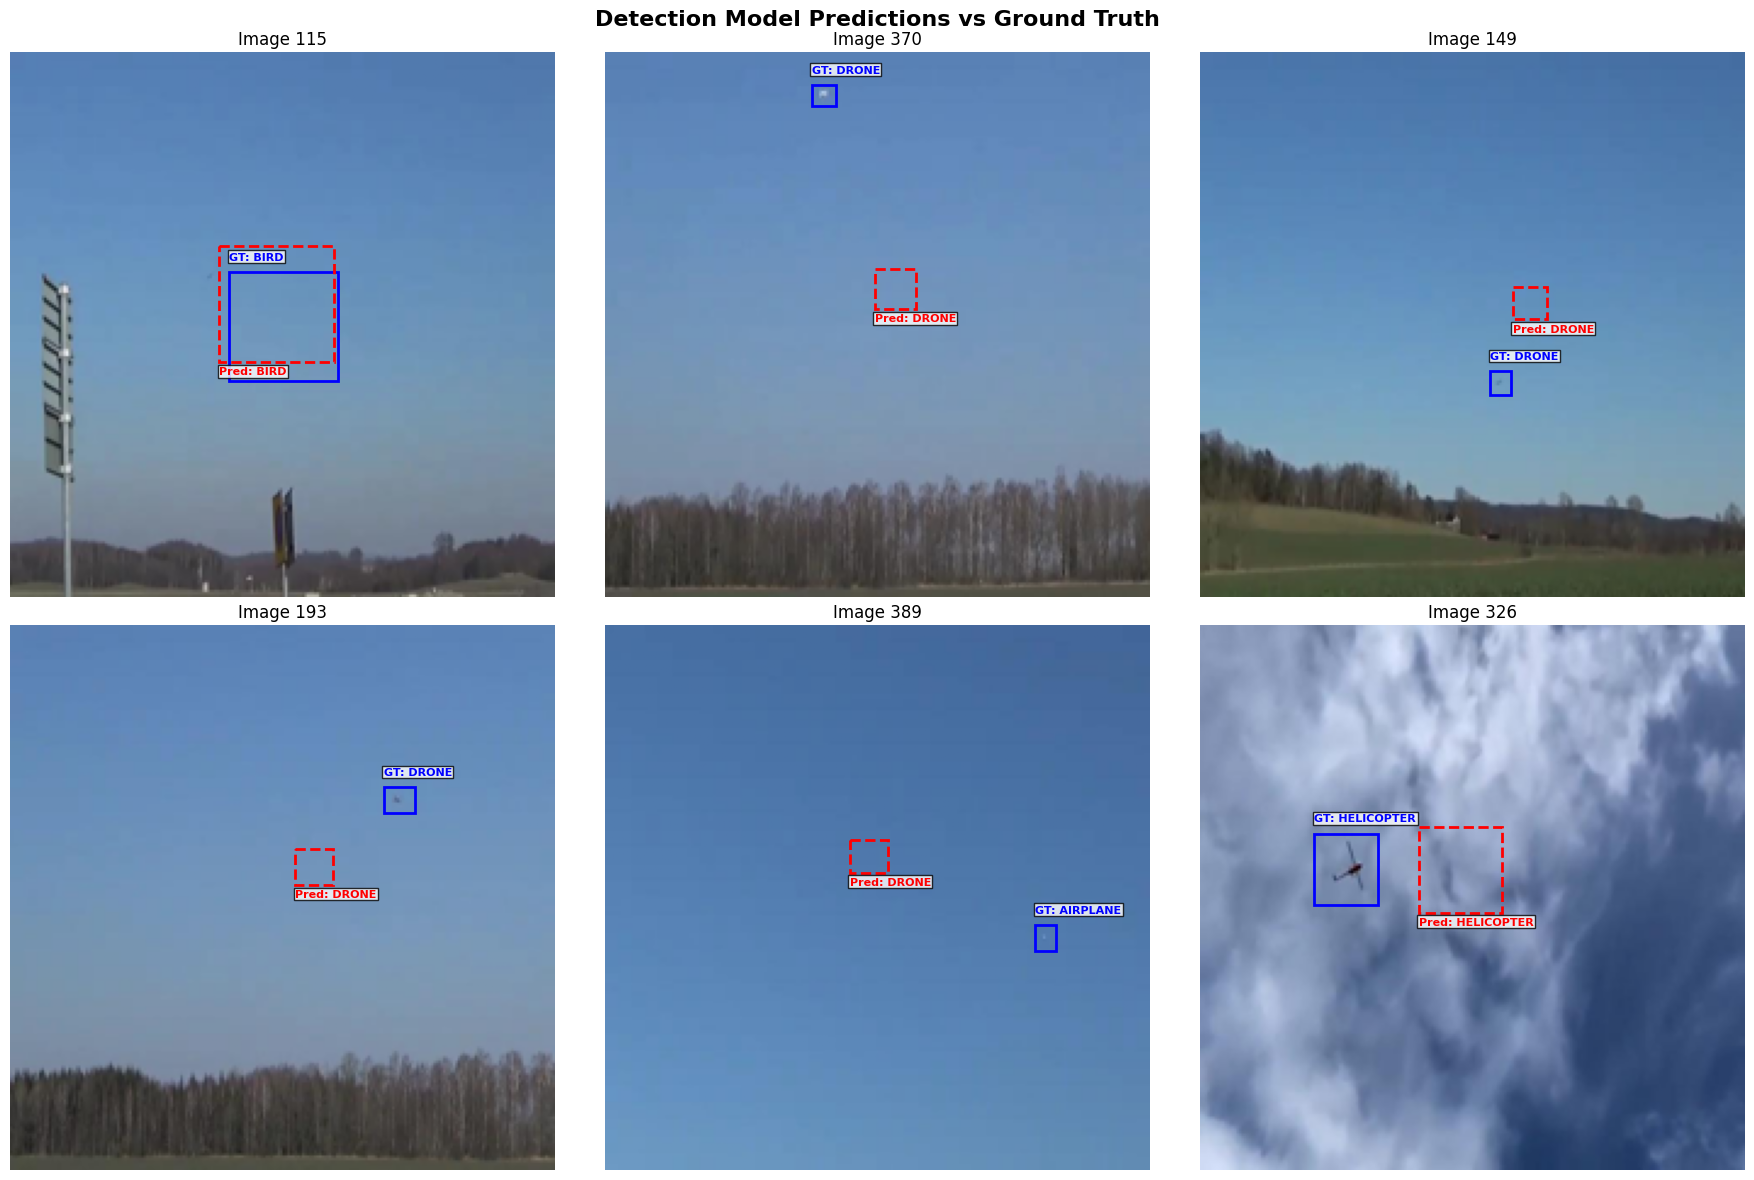

Final Detection Test MAE: 0.0143
CPU times: user 2min 31s, sys: 7.23 s, total: 2min 38s
Wall time: 3min 7s


In [304]:
%%time
# Train and evaluate detection model (simplified)
def train_and_evaluate_detection_model(X_train, Y_train, X_val=None, Y_val=None):
    '''
    Train detection model (simplified)
    '''
    print("\nStarting detection model training...")
    try:
        det_model, det_history = train_detection_model(
            X_train, Y_train, X_val, Y_val
        )

        # Plot training history
        plot_training_history(det_history, "Detection Model Training")

        # Evaluate on test set
        if X_test is not None and len(X_test) > 0:
            mae = evaluate_detection_model(det_model, X_test, Y_test)
            print(f"Final Detection Test MAE: {mae:.4f}")

        return det_model, det_history
    except Exception as e:
        print(f"Error during detection training: {e}")
        import traceback
        traceback.print_exc()
        det_model = None

cnn_detection_start_time = time.time()
det_model, det_history = train_and_evaluate_detection_model(X_train, Y_train, X_val, Y_val)
cnn_detection_end_time = time.time()
model_training_time.append(cnn_detection_end_time - cnn_detection_start_time)

In [305]:
print(f"🕒 Base Model Training Duration (seconds): {(rf_base_end_time - rf_base_start_time):.2f}")
print(f"🕒 GridSearch + RandomForest Model Training Duration (seconds): {(rf_grid_end_time - rf_grid_start_time):.2f}")
print(f"🕒 RandomForest Optimized Training Duration (seconds): {(rf_opti_end_time - rf_opti_start_time):.2f}")

print(f"🕒 CNN Model Training Duration (seconds): {(cnn_end_time - cnn_start_time):.2f}")
print(f"🕒 CNN Denoised Model Training Duration (seconds): {(cnn_denoised_end_time - cnn_denoised_start_time):.2f}")
print(f"🕒 CNN Detection Model Training Duration (seconds): {(cnn_detection_end_time - cnn_detection_start_time):.2f}")

🕒 Base Model Training Duration (seconds): 0.35
🕒 GridSearch + RandomForest Model Training Duration (seconds): 2948.57
🕒 RandomForest Optimized Training Duration (seconds): 1.14
🕒 CNN Model Training Duration (seconds): 183.49
🕒 CNN Denoised Model Training Duration (seconds): 183.22
🕒 CNN Detection Model Training Duration (seconds): 187.45
